All packages loaded.
Nature style configured.
Mounted at /content/drive
File: /content/drive/MyDrive/GHS_UCDB_GLOBE_R2024A.gpkg (283.2 MB)

Loading layers...

  gc    → GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A... (11,422 × 14)
  sc    → GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A... (11,422 × 183)
  ex    → GHS_UCDB_THEME_EXPOSURE_GLOBE_R2024A... (11,422 × 1,066)
  em    → GHS_UCDB_THEME_EMISSIONS_GLOBE_R2024A... (11,422 × 458)
  hl    → GHS_UCDB_THEME_HEALTH_GLOBE_R2024A... (11,422 × 17)
  infr  → GHS_UCDB_THEME_INFRASTRUCTURES_GLOBE_R2024A... (11,422 × 17)

All layers loaded. Urban centres: 11,422
Socioeconomic: 11/11
Exposure: 17/17
Emissions: 4/4
Health: 2/2
Infrastructure: 2/2

Income groups after standardisation:
income_group
Lower Middle    4591
Upper Middle    4179
High            1593
Low             1050
NaN                9
Name: count, dtype: int64

Compound Hazard Index (5/5):
  ✓ share_pop_flood_100yr (n=11,422)
  ✓ share_pop_lecz_below10m (n=5,163)
  ✓ share_pop

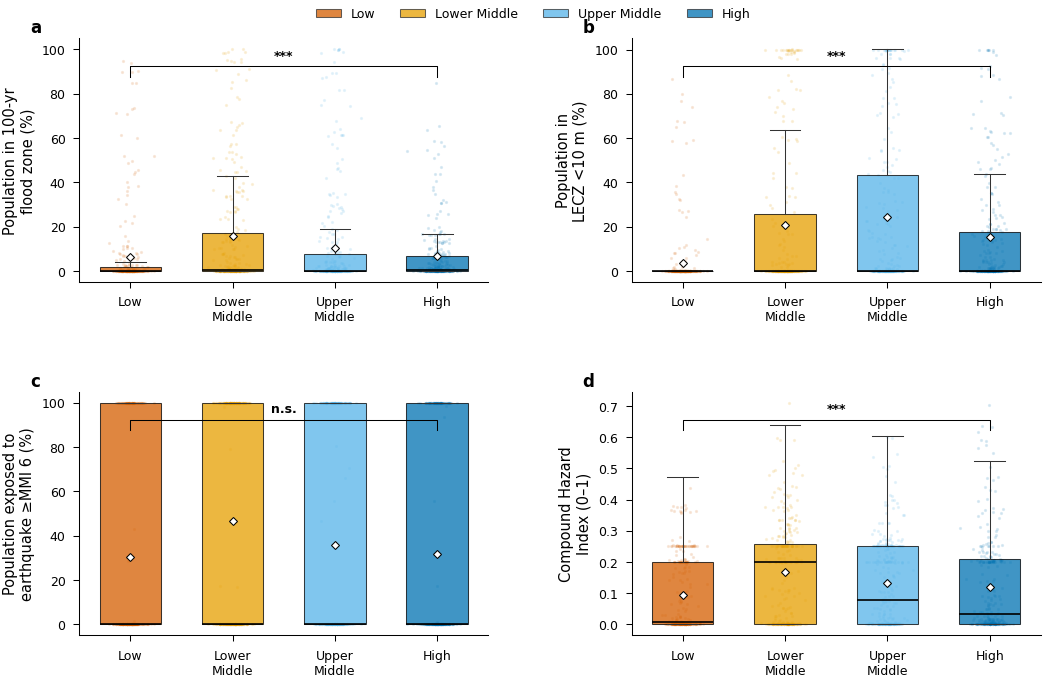


Generating Figure 2...
  Saved: figures/Figure2_LECZ_vs_HDI.pdf, figures/Figure2_LECZ_vs_HDI.png


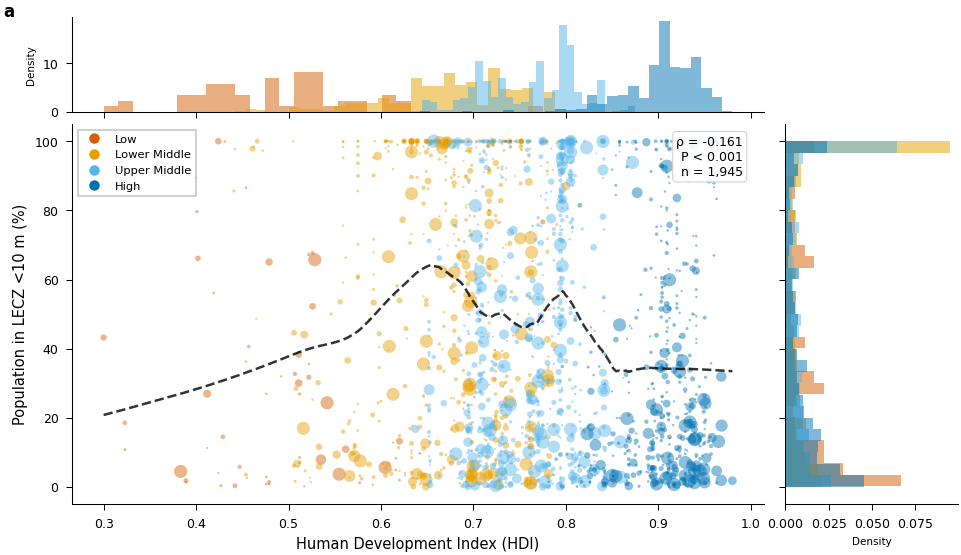


Generating Figure 3...
  Saved: figures/Figure3_hazard_HDI_heatmap.pdf, figures/Figure3_hazard_HDI_heatmap.png


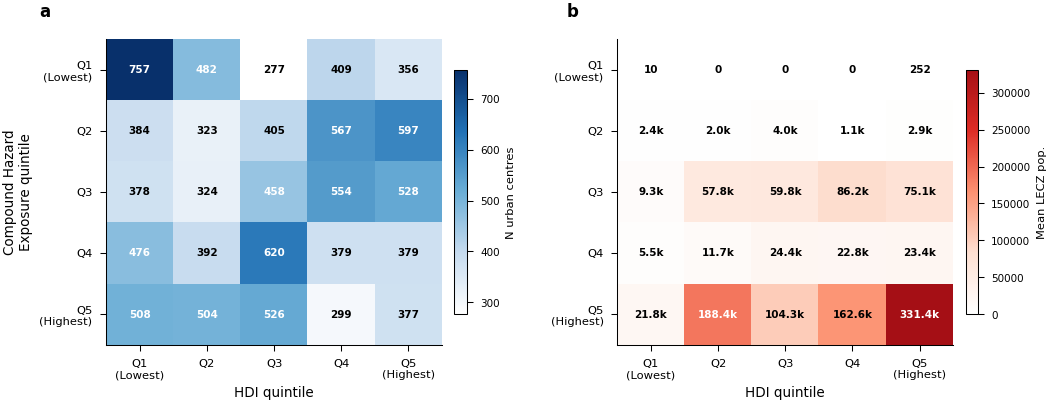


Generating Figure 4...
  Saved: figures/Figure4_demographics.pdf, figures/Figure4_demographics.png


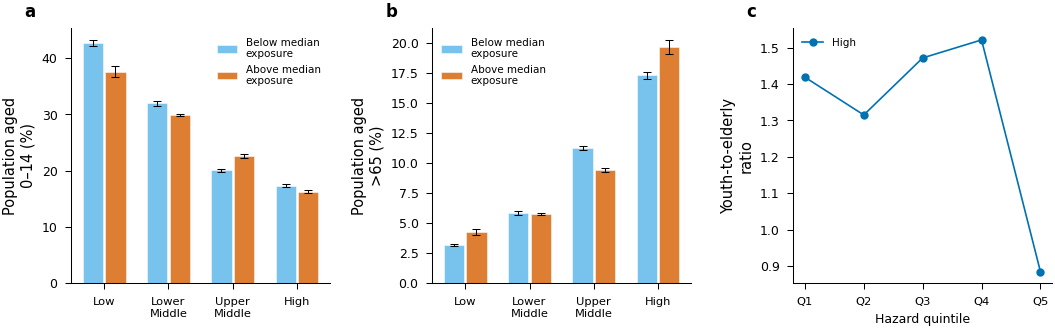


Generating Figure 5...
  Quantile regressions...
    τ=0.10 done
    τ=0.25 done
    τ=0.50 done
    τ=0.75 done
    τ=0.90 done
  Saved: figures/Figure5_quantile_regression.pdf, figures/Figure5_quantile_regression.png


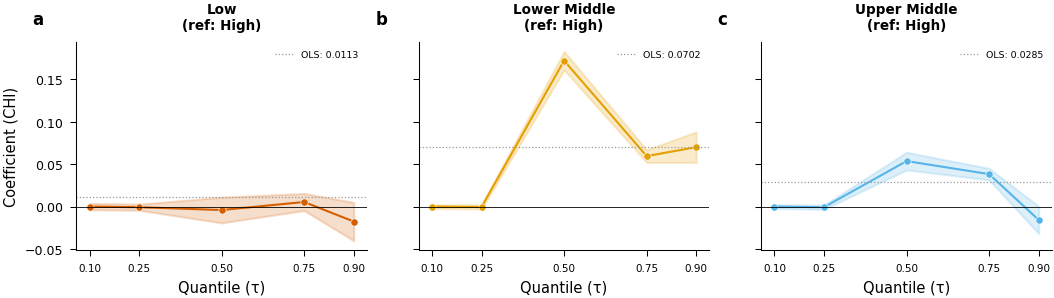


Running regressions...

REGRESSION RESULTS

                                                             (1) Bivariate (2) Controls (3) Region FE  (4) HDI  
----------------------------------------------------------------------------------------------------------------
Intercept                                                    0.1167***     0.3097***    0.3195***     0.3406*** 
                                                             (0.0037)      (0.0284)     (0.0316)      (0.0353)  
C(income_group, Treatment(reference="High"))[T.Low]          -0.0367***    0.0028       0.0008                  
                                                             (0.0051)      (0.0062)     (0.0080)                
C(income_group, Treatment(reference="High"))[T.Lower Middle] 0.0494***     0.0761***    -0.0001                 
                                                             (0.0044)      (0.0051)     (0.0069)                
C(income_group, Treatment(reference="High"))[T.Uppe

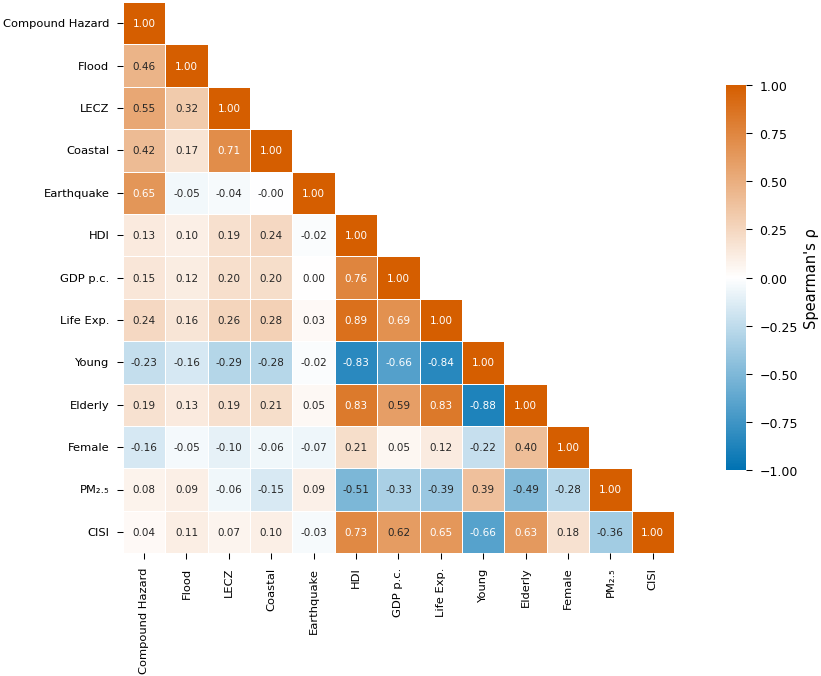


ANALYSIS COMPLETE

Outputs:
  figures/  Figure1–5 + ExtendedData_correlation_matrix (.pdf/.png)
  tables/   Table1, regression, regional, top50 (.csv/.xlsx)

Dataset: GHS-UCDB R2024A V1.1 (GeoPackage)
  doi: 10.2905/1a338be6-7eaf-480c-9664-3a8ade88cbcd



In [ ]:
#!/usr/bin/env python3
"""
===============================================================================
Climate Justice & Urban Inequality: Global Analysis of 11,422 Urban Centres
===============================================================================
Target: Nature Climate Change (Analysis)
Dataset: GHS-UCDB R2024A V1.1 — GeoPackage (.gpkg)
===============================================================================
"""

# =============================================================================
# CELL 1: ENVIRONMENT SETUP
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap, Normalize, BoundaryNorm
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu, spearmanr, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import OrderedDict
import os

try:
    import geopandas as gpd
except ImportError:
    os.system('pip install geopandas pyogrio --quiet')
    import geopandas as gpd

print("All packages loaded.")

# =============================================================================
# CELL 2: NATURE CLIMATE CHANGE STYLE
# =============================================================================

MM_TO_INCH = 1 / 25.4
NATURE_SINGLE_COL = 89 * MM_TO_INCH
NATURE_DOUBLE_COL = 183 * MM_TO_INCH
NATURE_MAX_HEIGHT = 247 * MM_TO_INCH
FIGURE_DPI = 300

WONG_PALETTE = {
    'black': '#000000', 'orange': '#E69F00', 'sky_blue': '#56B4E9',
    'green': '#009E73', 'yellow': '#F0E442', 'blue': '#0072B2',
    'vermilion': '#D55E00', 'purple': '#CC79A7',
}

INCOME_COLORS = OrderedDict([
    ('Low',          WONG_PALETTE['vermilion']),
    ('Lower Middle', WONG_PALETTE['orange']),
    ('Upper Middle', WONG_PALETTE['sky_blue']),
    ('High',         WONG_PALETTE['blue']),
])
INCOME_ORDER = ['Low', 'Lower Middle', 'Upper Middle', 'High']

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 7, 'axes.labelsize': 7, 'axes.titlesize': 8,
    'axes.linewidth': 0.5, 'axes.labelpad': 3,
    'axes.spines.top': False, 'axes.spines.right': False,
    'xtick.labelsize': 6, 'ytick.labelsize': 6,
    'xtick.major.size': 3, 'xtick.major.width': 0.5,
    'ytick.major.size': 3, 'ytick.major.width': 0.5,
    'xtick.direction': 'out', 'ytick.direction': 'out',
    'legend.fontsize': 6, 'legend.frameon': False,
    'lines.linewidth': 0.8, 'lines.markersize': 3,
    'figure.dpi': 150, 'savefig.dpi': FIGURE_DPI,
    'savefig.bbox': 'tight', 'savefig.pad_inches': 0.02,
    'grid.linewidth': 0.3, 'grid.alpha': 0.3,
})


def add_panel_label(ax, label, x=-0.12, y=1.08):
    ax.text(x, y, label, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='left')


def save_figure(fig, filename, formats=('pdf', 'png')):
    os.makedirs('figures', exist_ok=True)
    for fmt in formats:
        fig.savefig(f'figures/{filename}.{fmt}', format=fmt, dpi=FIGURE_DPI,
                    bbox_inches='tight', pad_inches=0.02,
                    facecolor='white', edgecolor='none')
    print(f"  Saved: {', '.join(f'figures/{filename}.{f}' for f in formats)}")


print("Nature style configured.")

# =============================================================================
# CELL 3: DATA LOADING (GeoPackage — multi-layer)
# =============================================================================

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/GHS_UCDB_GLOBE_R2024A.gpkg'  # UPDATE IF NEEDED

if not os.path.exists(DATA_PATH):
    import glob
    matches = glob.glob('/content/drive/MyDrive/**/*.gpkg', recursive=True)
    if matches:
        DATA_PATH = matches[0]
        print(f"Auto-detected: {DATA_PATH}")
    else:
        raise FileNotFoundError("No .gpkg found. Upload and update DATA_PATH.")

print(f"File: {DATA_PATH} ({os.path.getsize(DATA_PATH)/1e6:.1f} MB)")

LAYERS_TO_LOAD = {
    'gc':   'GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A',
    'sc':   'GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A',
    'ex':   'GHS_UCDB_THEME_EXPOSURE_GLOBE_R2024A',
    'em':   'GHS_UCDB_THEME_EMISSIONS_GLOBE_R2024A',
    'hl':   'GHS_UCDB_THEME_HEALTH_GLOBE_R2024A',
    'infr': 'GHS_UCDB_THEME_INFRASTRUCTURES_GLOBE_R2024A',
}


def strip_bom(text):
    if isinstance(text, str):
        return text.replace('\ufeff', '').strip()
    return text


def load_gpkg_layer(path, layer_name, keep_geometry=False):
    gdf_layer = gpd.read_file(path, layer=layer_name)
    gdf_layer.columns = [strip_bom(c) for c in gdf_layer.columns]
    for col in gdf_layer.select_dtypes(include=['object']).columns:
        if col != 'geometry':
            gdf_layer[col] = gdf_layer[col].apply(strip_bom)
    if not keep_geometry and 'geometry' in gdf_layer.columns:
        gdf_layer = pd.DataFrame(gdf_layer.drop(columns='geometry'))
    return gdf_layer


print("\nLoading layers...\n")
raw = {}
for key, layer_name in LAYERS_TO_LOAD.items():
    print(f"  {key:5s} → {layer_name}...", end=' ', flush=True)
    raw[key] = load_gpkg_layer(DATA_PATH, layer_name, keep_geometry=(key == 'gc'))
    print(f"({raw[key].shape[0]:,} × {raw[key].shape[1]:,})")

print(f"\nAll layers loaded. Urban centres: {raw['gc'].shape[0]:,}")

# =============================================================================
# CELL 4: DATA PREPARATION
# =============================================================================

ID_COL = 'ID_UC_G0'


def find_col(dataframe, pattern, exclude=None):
    for c in sorted(dataframe.columns, reverse=True):
        if pattern.upper() in c.upper():
            if exclude and any(ex.upper() in c.upper() for ex in exclude):
                continue
            return c
    return None


# --- General Characteristics ---
gc = raw['gc']
gc_cols = {
    'name': find_col(gc, 'GC_UCN_MAI'),
    'country_gadm': find_col(gc, 'GC_CNT_GAD'),
    'country_un': find_col(gc, 'GC_CNT_UNN'),
    'area_km2': find_col(gc, 'GC_UCA_KM2'),
    'population': find_col(gc, 'GC_POP_TOT'),
    'income_group': find_col(gc, 'GC_DEV_WIG'),
    'sdg_region': find_col(gc, 'GC_DEV_USR'),
}

gc_select = [ID_COL] + [v for v in gc_cols.values() if v]
gc_rename = {ID_COL: 'id'}
gc_rename.update({v: k for k, v in gc_cols.items() if v})
df = gc[gc_select + ['geometry']].copy().rename(columns=gc_rename)

# --- Socioeconomic ---
sc = raw['sc']
sc_map = {
    'hdi':           find_col(sc, 'SC_SEC_HDI', exclude=['GDF', 'GDM']),
    'gdp_avg':       find_col(sc, 'SC_GDP_AVG'),
    'gdp_total':     find_col(sc, 'SC_GDP_SUM'),
    'life_exp':      find_col(sc, 'SC_SEC_LET', exclude=['LEF', 'LEM']),
    'schooling_exp': find_col(sc, 'SC_SEC_SET', exclude=['SEF', 'SEM']),
    'pct_young':     find_col(sc, 'SC_SEC_PCY'),
    'pct_adult':     find_col(sc, 'SC_SEC_PCA'),
    'pct_old':       find_col(sc, 'SC_SEC_PCO'),
    'pct_female':    find_col(sc, 'SC_SEC_PCF'),
    'pct_male':      find_col(sc, 'SC_SEC_PCM'),
    'gdi':           find_col(sc, 'SC_SEC_GDI', exclude=['GDF', 'GDM']),
}
sc_r = {v: k for k, v in sc_map.items() if v}
df = df.merge(sc[[ID_COL]+list(sc_r.keys())].rename(columns={**sc_r, ID_COL:'id'}),
              on='id', how='left')
print(f"Socioeconomic: {len(sc_r)}/{len(sc_map)}")

# --- Exposure ---
ex = raw['ex']
ex_map = {
    'pop_flood_100yr':            find_col(ex, 'EX_100_POP'),
    'pop_flood_10yr':             find_col(ex, 'EX_010_POP'),
    'share_pop_flood_100yr':      find_col(ex, 'EX_100_SHP'),
    'share_pop_flood_10yr':       find_col(ex, 'EX_010_SHP'),
    'pop_lecz_5m':                find_col(ex, 'EX_L05_POP'),
    'pop_lecz_10m':               find_col(ex, 'EX_L10_POP'),
    'share_pop_lecz_5m':          find_col(ex, 'EX_L05_SHP'),
    'share_pop_lecz_10m':         find_col(ex, 'EX_L10_SHP'),
    'share_pop_lecz_below10m':    find_col(ex, 'EX_LEC_SHP'),
    'builtup_lecz_5m':            find_col(ex, 'EX_L05_BUS', exclude=['B1', 'B2']),
    'pop_coastal_100yr':          find_col(ex, 'EX_CF1_POP'),
    'pop_coastal_20yr':           find_col(ex, 'EX_CF2_POP'),
    'share_pop_coastal_100yr':    find_col(ex, 'EX_CF1_SHP'),
    'share_pop_coastal_20yr':     find_col(ex, 'EX_CF2_SHP'),
    'share_pop_earthquake_mmi6':  find_col(ex, 'EX_SHA_POP'),
    'pop_cyclone_100yr':          find_col(ex, 'EX_100_S1P'),
    'pop_cyclone_400yr_ss3':      find_col(ex, 'EX_400_S3P'),
}
ex_r = {v: k for k, v in ex_map.items() if v}
df = df.merge(ex[[ID_COL]+list(ex_r.keys())].rename(columns={**ex_r, ID_COL:'id'}),
              on='id', how='left')
print(f"Exposure: {len(ex_r)}/{len(ex_map)}")

# --- Emissions ---
em = raw['em']
em_map = {
    'pm25_deaths':    find_col(em, 'EM_PM2_MOR'),
    'pm25_conc':      find_col(em, 'EM_PM2_CON'),
    'co2_total':      find_col(em, 'EM_CO2_TOT'),
    'co2_per_capita': find_col(em, 'EM_CO2_PEC'),
}
em_r = {v: k for k, v in em_map.items() if v}
if em_r:
    df = df.merge(em[[ID_COL]+list(em_r.keys())].rename(columns={**em_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Emissions: {len(em_r)}/{len(em_map)}")

# --- Health ---
hl = raw['hl']
hl_map = {
    'hospitals_per_cap':       find_col(hl, 'HL_FPC_HOS'),
    'share_pop_near_hospital': find_col(hl, 'HL_SHP_HOS'),
}
hl_r = {v: k for k, v in hl_map.items() if v}
if hl_r:
    df = df.merge(hl[[ID_COL]+list(hl_r.keys())].rename(columns={**hl_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Health: {len(hl_r)}/{len(hl_map)}")

# --- Infrastructure ---
infr = raw['infr']
infr_map = {
    'cisi_all':    find_col(infr, 'IN_CIS_ALL'),
    'cisi_energy': find_col(infr, 'IN_CIS_ENE'),
}
infr_r = {v: k for k, v in infr_map.items() if v}
if infr_r:
    df = df.merge(infr[[ID_COL]+list(infr_r.keys())].rename(columns={**infr_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Infrastructure: {len(infr_r)}/{len(infr_map)}")

# --- Numeric conversion ---
skip = {'id', 'name', 'country_gadm', 'country_un', 'income_group', 'sdg_region', 'geometry'}
for col in df.columns:
    if col not in skip:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Standardise income groups (BOM already stripped from values) ---
income_map = {
    'Low': 'Low', 'Low Income': 'Low', 'Low income': 'Low',
    'Lower Middle': 'Lower Middle', 'Lower Middle Income': 'Lower Middle',
    'Lower middle income': 'Lower Middle', 'Lower-middle income': 'Lower Middle',
    'Upper Middle': 'Upper Middle', 'Upper Middle Income': 'Upper Middle',
    'Upper middle income': 'Upper Middle', 'Upper-middle income': 'Upper Middle',
    'High': 'High', 'High Income': 'High', 'High income': 'High',
}
df['income_group'] = df['income_group'].map(
    lambda x: income_map.get(str(x).strip(), str(x).strip()) if pd.notna(x) else np.nan
)

print(f"\nIncome groups after standardisation:")
print(df['income_group'].value_counts(dropna=False))

# --- Derived variables ---
df['pop_density'] = df['population'] / df['area_km2'].replace(0, np.nan)

if 'pop_cyclone_100yr' in df.columns:
    df['share_pop_cyclone_100yr'] = (
        df['pop_cyclone_100yr'] / df['population'].replace(0, np.nan) * 100)
else:
    df['share_pop_cyclone_100yr'] = np.nan

df['pop_lecz_total'] = df.get('pop_lecz_5m', pd.Series(0, index=df.index)).fillna(0) + \
                        df.get('pop_lecz_10m', pd.Series(0, index=df.index)).fillna(0)

# --- Compound Hazard Exposure Index ---
hazard_vars = ['share_pop_flood_100yr', 'share_pop_lecz_below10m',
               'share_pop_coastal_100yr', 'share_pop_earthquake_mmi6',
               'share_pop_cyclone_100yr']

available_hazards = [v for v in hazard_vars if v in df.columns and df[v].notna().sum() > 100]
print(f"\nCompound Hazard Index ({len(available_hazards)}/{len(hazard_vars)}):")

for var in available_hazards:
    vals = df[var]
    vmin, vmax = vals.min(), vals.max()
    if pd.notna(vmin) and pd.notna(vmax) and vmax > vmin:
        df[f'{var}_norm'] = (vals - vmin) / (vmax - vmin)
    else:
        df[f'{var}_norm'] = 0.0
    print(f"  ✓ {var} (n={vals.notna().sum():,})")

norm_cols = [f'{v}_norm' for v in available_hazards]
df['compound_hazard_index'] = df[norm_cols].mean(axis=1, skipna=True)

# --- Quintiles ---
try:
    df['hdi_quintile'] = pd.qcut(df['hdi'], q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'], duplicates='drop')
except:
    df['hdi_quintile'] = pd.qcut(df['hdi'].rank(method='first'), q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])
try:
    df['hazard_quintile'] = pd.qcut(df['compound_hazard_index'], q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'], duplicates='drop')
except:
    df['hazard_quintile'] = pd.qcut(df['compound_hazard_index'].rank(method='first'), q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])

# --- Final sample ---
df_valid = df[df['income_group'].isin(INCOME_ORDER)].copy()

print(f"\n{'='*60}")
print(f"FINAL ANALYTICAL SAMPLE: {df_valid.shape[0]:,} urban centres")
print(f"{'='*60}")
for grp in INCOME_ORDER:
    print(f"  {grp:20s} {(df_valid['income_group'] == grp).sum():>6,}")

print(f"\nKey variable coverage (% non-missing):")
for v in ['hdi', 'gdp_avg', 'share_pop_flood_100yr', 'share_pop_lecz_below10m',
           'share_pop_coastal_100yr', 'share_pop_earthquake_mmi6',
           'pct_young', 'pct_old', 'pm25_conc', 'cisi_all', 'compound_hazard_index']:
    if v in df_valid.columns:
        print(f"  {v:35s} {df_valid[v].notna().mean()*100:6.1f}%")

# =============================================================================
# CELL 5: TABLE 1
# =============================================================================

def create_table1(data, income_order):
    variables = OrderedDict([
        ('population',              ('Population',                          ',.0f')),
        ('area_km2',                ('Area (km²)',                          ',.1f')),
        ('pop_density',             ('Pop. density (per km²)',              ',.0f')),
        ('hdi',                     ('HDI',                                 '.3f')),
        ('gdp_avg',                 ('GDP per capita (PPP)',                ',.0f')),
        ('life_exp',                ('Life expectancy (yr)',                '.1f')),
        ('schooling_exp',           ('Expected schooling (yr)',             '.1f')),
        ('pct_young',               ('Pop. 0–14 (%)',                      '.1f')),
        ('pct_old',                 ('Pop. >65 (%)',                        '.1f')),
        ('pct_female',              ('Female pop. (%)',                     '.1f')),
        ('share_pop_flood_100yr',   ('Pop. 100-yr flood (%)',              '.1f')),
        ('share_pop_lecz_below10m', ('Pop. LECZ <10 m (%)',               '.1f')),
        ('share_pop_coastal_100yr', ('Pop. coastal flood (%)',             '.1f')),
        ('share_pop_earthquake_mmi6', ('Pop. earthquake ≥MMI 6 (%)',      '.1f')),
        ('share_pop_cyclone_100yr', ('Pop. cyclone (%)',                   '.1f')),
        ('compound_hazard_index',   ('Compound Hazard Index',              '.3f')),
        ('pm25_conc',               ('PM₂.₅ (µg/m³)',                     '.1f')),
        ('cisi_all',                ('CISI',                               '.3f')),
        ('share_pop_near_hospital', ('Pop. near hospital (%)',             '.1f')),
    ])
    variables = OrderedDict((k, v) for k, v in variables.items() if k in data.columns)

    rows = [{'Variable': 'N (urban centres)',
             **{g: f"{(data['income_group']==g).sum():,}" for g in income_order},
             'All': f"{data.shape[0]:,}", 'p-value': ''}]

    for var_name, (label, fmt) in variables.items():
        row = {'Variable': label}
        gvals = []
        for grp in income_order:
            gd = data.loc[data['income_group'] == grp, var_name].dropna()
            gvals.append(gd)
            if len(gd) > 0:
                m, q1, q3 = gd.median(), gd.quantile(0.25), gd.quantile(0.75)
                row[grp] = f"{m:{fmt}} ({q1:{fmt}}–{q3:{fmt}})"
            else:
                row[grp] = '—'
        ad = data[var_name].dropna()
        if len(ad) > 0:
            m, q1, q3 = ad.median(), ad.quantile(0.25), ad.quantile(0.75)
            row['All'] = f"{m:{fmt}} ({q1:{fmt}}–{q3:{fmt}})"
        else:
            row['All'] = '—'
        vg = [g for g in gvals if len(g) >= 5]
        if len(vg) >= 2:
            try:
                _, p = kruskal(*vg)
                row['p-value'] = '<0.001' if p < 0.001 else f"{p:.3f}"
            except:
                row['p-value'] = '—'
        else:
            row['p-value'] = '—'
        rows.append(row)

    return pd.DataFrame(rows)[['Variable'] + income_order + ['All', 'p-value']]


table1 = create_table1(df_valid, INCOME_ORDER)
print("\n" + "="*100)
print("TABLE 1: Descriptive statistics by World Bank income group")
print("="*100)
print(table1.to_string(index=False))
os.makedirs('tables', exist_ok=True)
table1.to_csv('tables/Table1_descriptive_stats.csv', index=False)
table1.to_excel('tables/Table1_descriptive_stats.xlsx', index=False)
print("  Saved: tables/Table1_descriptive_stats.csv/.xlsx")

# =============================================================================
# CELL 6: FIGURE 1 — MULTI-HAZARD EXPOSURE
# =============================================================================

def figure1_multihazard(data, income_order, income_colors):
    fig = plt.figure(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.65))
    gs = gridspec.GridSpec(2, 2, hspace=0.45, wspace=0.35,
                           left=0.08, right=0.97, top=0.93, bottom=0.08)
    panels = {
        'a': ('share_pop_flood_100yr', 'Population in 100-yr\nflood zone (%)'),
        'b': ('share_pop_lecz_below10m', 'Population in\nLECZ <10 m (%)'),
        'c': ('share_pop_earthquake_mmi6', 'Population exposed to\nearthquake ≥MMI 6 (%)'),
        'd': ('compound_hazard_index', 'Compound Hazard\nIndex (0–1)'),
    }
    for idx, (label, (var, ylabel)) in enumerate(panels.items()):
        ax = fig.add_subplot(gs[idx // 2, idx % 2])
        if var not in data.columns or data[var].notna().sum() < 10:
            ax.text(0.5, 0.5, f'{var}\nnot available', transform=ax.transAxes,
                   ha='center', va='center', fontsize=6, color='grey')
            add_panel_label(ax, label); continue

        plot_data = [data.loc[data['income_group'] == g, var].dropna() for g in income_order]
        bp = ax.boxplot(plot_data, positions=range(len(income_order)), widths=0.6,
            patch_artist=True, showfliers=False, showmeans=True,
            meanprops=dict(marker='D', markerfacecolor='white',
                          markeredgecolor='black', markersize=2.5, markeredgewidth=0.5),
            medianprops=dict(color='black', linewidth=0.8),
            whiskerprops=dict(linewidth=0.5, color='#333333'),
            capprops=dict(linewidth=0.5, color='#333333'),
            boxprops=dict(linewidth=0.5))

        for patch, grp in zip(bp['boxes'], income_order):
            patch.set_facecolor(income_colors[grp]); patch.set_alpha(0.75)

        rng = np.random.default_rng(42)
        for i, grp in enumerate(income_order):
            vals = data.loc[data['income_group'] == grp, var].dropna()
            n_plot = min(300, len(vals))
            if n_plot > 0:
                vs = vals.sample(n=n_plot, random_state=42) if len(vals) > n_plot else vals
                ax.scatter(i + rng.normal(0, 0.08, len(vs)), vs, s=0.3, alpha=0.15,
                          color=income_colors[grp], zorder=1, rasterized=True)

        ax.set_xticks(range(len(income_order)))
        short_labels = ['Low', 'Lower\nMiddle', 'Upper\nMiddle', 'High']
        ax.set_xticklabels(short_labels, rotation=0, ha='center')
        ax.set_ylabel(ylabel)

        gl = data.loc[data['income_group'] == 'Low', var].dropna()
        gh = data.loc[data['income_group'] == 'High', var].dropna()
        if len(gl) > 5 and len(gh) > 5:
            _, pv = mannwhitneyu(gl, gh, alternative='two-sided')
            sig = '***' if pv < 0.001 else ('**' if pv < 0.01 else ('*' if pv < 0.05 else 'n.s.'))
            yb = ax.get_ylim()[1] * 0.88
            ax.plot([0, 0, 3, 3], [yb*0.95, yb, yb, yb*0.95], lw=0.5, color='black')
            ax.text(1.5, yb * 1.02, sig, ha='center', va='bottom', fontsize=6, fontweight='bold')
        add_panel_label(ax, label)

    legend_el = [mpatches.Patch(facecolor=income_colors[g], alpha=0.75,
                 edgecolor='#333333', linewidth=0.5, label=g) for g in income_order]
    fig.legend(handles=legend_el, loc='upper center', ncol=4, fontsize=6,
              frameon=False, bbox_to_anchor=(0.5, 0.99))
    save_figure(fig, 'Figure1_multihazard_exposure')
    plt.show()
    return fig

print("\nGenerating Figure 1...")
fig1 = figure1_multihazard(df_valid, INCOME_ORDER, INCOME_COLORS)

# =============================================================================
# CELL 7: FIGURE 2 — LECZ vs HDI
# =============================================================================

def figure2_lecz_hdi(data, income_colors):
    mask = (data['share_pop_lecz_below10m'].notna() &
            (data['share_pop_lecz_below10m'] > 0) & data['hdi'].notna())
    pdf = data[mask].copy()
    if len(pdf) < 50:
        print("  Warning: Too few cities for Figure 2"); return None

    fig = plt.figure(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.55))
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           hspace=0.05, wspace=0.05,
                           left=0.1, right=0.92, top=0.92, bottom=0.1)
    ax_m = fig.add_subplot(gs[1, 0])
    ax_t = fig.add_subplot(gs[0, 0], sharex=ax_m)
    ax_r = fig.add_subplot(gs[1, 1], sharey=ax_m)

    for grp in INCOME_ORDER:
        gd = pdf[pdf['income_group'] == grp]
        if len(gd) == 0: continue
        sizes = np.clip(gd['population'] / 50000, 1, 40)
        ax_m.scatter(gd['hdi'], gd['share_pop_lecz_below10m'], s=sizes, alpha=0.45,
                    color=income_colors[grp], label=grp, edgecolors='none', rasterized=True)

    valid = pdf[['hdi', 'share_pop_lecz_below10m']].dropna()
    if len(valid) > 50:
        sm_out = lowess(valid['share_pop_lecz_below10m'], valid['hdi'], frac=0.3, return_sorted=True)
        ax_m.plot(sm_out[:, 0], sm_out[:, 1], color='black', lw=1.2, ls='--', zorder=5, alpha=0.8)

    ax_m.set_xlabel('Human Development Index (HDI)')
    ax_m.set_ylabel('Population in LECZ <10 m (%)')
    rho, pr = spearmanr(valid['hdi'], valid['share_pop_lecz_below10m'])
    pt = 'P < 0.001' if pr < 0.001 else f'P = {pr:.3f}'
    ax_m.text(0.97, 0.97, f'ρ = {rho:.3f}\n{pt}\nn = {len(valid):,}',
             transform=ax_m.transAxes, fontsize=6, va='top', ha='right',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                      edgecolor='#ccc', alpha=0.9, linewidth=0.5))

    for grp in INCOME_ORDER:
        v = pdf.loc[pdf['income_group'] == grp, 'hdi'].dropna()
        if len(v) > 5: ax_t.hist(v, bins=30, alpha=0.5, color=income_colors[grp], density=True, edgecolor='none')
    ax_t.set_ylabel('Density', fontsize=5); ax_t.tick_params(labelbottom=False)

    for grp in INCOME_ORDER:
        v = pdf.loc[pdf['income_group'] == grp, 'share_pop_lecz_below10m'].dropna()
        if len(v) > 5: ax_r.hist(v, bins=30, alpha=0.5, color=income_colors[grp], density=True, orientation='horizontal', edgecolor='none')
    ax_r.set_xlabel('Density', fontsize=5); ax_r.tick_params(labelleft=False)

    leg = [Line2D([0], [0], marker='o', color='w', markerfacecolor=income_colors[g],
                  markersize=5, label=g, markeredgewidth=0) for g in INCOME_ORDER]
    ax_m.legend(handles=leg, loc='upper left', fontsize=5.5, frameon=True,
               fancybox=False, edgecolor='#ccc', framealpha=0.9)
    add_panel_label(ax_t, 'a', x=-0.1, y=1.15)
    save_figure(fig, 'Figure2_LECZ_vs_HDI')
    plt.show()
    return fig

print("\nGenerating Figure 2...")
fig2 = figure2_lecz_hdi(df_valid, INCOME_COLORS)

# =============================================================================
# CELL 8: FIGURE 3 — HAZARD × HDI HEATMAP
# =============================================================================

def figure3_heatmap(data):
    mask = data['hdi_quintile'].notna() & data['hazard_quintile'].notna()
    sub = data[mask].copy()
    if len(sub) < 100:
        print("  Warning: Too few for Figure 3"); return None

    ct_n = pd.crosstab(sub['hazard_quintile'], sub['hdi_quintile'])
    ct_p = sub.groupby(['hazard_quintile', 'hdi_quintile'])['pop_lecz_total'].mean().unstack(fill_value=0)
    ct_p = ct_p.reindex(index=ct_n.index, columns=ct_n.columns, fill_value=0)

    fig, axes = plt.subplots(1, 2, figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.4))

    cmap_a = LinearSegmentedColormap.from_list('c', ['#FFF', '#C6DBEF', '#6BAED6', '#2171B5', '#08306B'])
    im = axes[0].imshow(ct_n.values, cmap=cmap_a, aspect='auto')
    for i in range(ct_n.shape[0]):
        for j in range(ct_n.shape[1]):
            v = ct_n.values[i, j]
            axes[0].text(j, i, f'{v:,}', ha='center', va='center', fontsize=5,
                        color='white' if v > ct_n.values.max()*0.6 else 'black', fontweight='bold')
    axes[0].set_xticks(range(ct_n.shape[1])); axes[0].set_xticklabels(ct_n.columns, fontsize=5.5)
    axes[0].set_yticks(range(ct_n.shape[0])); axes[0].set_yticklabels(ct_n.index, fontsize=5.5)
    axes[0].set_xlabel('HDI quintile', fontsize=6.5)
    axes[0].set_ylabel('Compound Hazard\nExposure quintile', fontsize=6.5)
    cb = fig.colorbar(im, ax=axes[0], shrink=0.8, pad=0.03)
    cb.ax.tick_params(labelsize=5); cb.set_label('N urban centres', fontsize=5.5)
    add_panel_label(axes[0], 'a', x=-0.2, y=1.12)

    cmap_b = LinearSegmentedColormap.from_list('p', ['#FFF', '#FEE0D2', '#FC9272', '#DE2D26', '#A50F15'])
    im2 = axes[1].imshow(ct_p.values, cmap=cmap_b, aspect='auto')
    for i in range(ct_p.shape[0]):
        for j in range(ct_p.shape[1]):
            v = ct_p.values[i, j]
            lb = f'{v/1000:.1f}k' if v >= 1000 else f'{v:.0f}'
            axes[1].text(j, i, lb, ha='center', va='center', fontsize=5,
                        color='white' if v > ct_p.values.max()*0.5 else 'black', fontweight='bold')
    axes[1].set_xticks(range(ct_p.shape[1])); axes[1].set_xticklabels(ct_p.columns, fontsize=5.5)
    axes[1].set_yticks(range(ct_p.shape[0])); axes[1].set_yticklabels(ct_p.index, fontsize=5.5)
    axes[1].set_xlabel('HDI quintile', fontsize=6.5); axes[1].set_ylabel('')
    cb2 = fig.colorbar(im2, ax=axes[1], shrink=0.8, pad=0.03)
    cb2.ax.tick_params(labelsize=5); cb2.set_label('Mean LECZ pop.', fontsize=5.5)
    add_panel_label(axes[1], 'b', x=-0.15, y=1.12)

    plt.tight_layout(w_pad=2)
    save_figure(fig, 'Figure3_hazard_HDI_heatmap')
    plt.show()
    return fig

print("\nGenerating Figure 3...")
fig3 = figure3_heatmap(df_valid)

# =============================================================================
# CELL 9: FIGURE 4 — DEMOGRAPHICS
# =============================================================================

def figure4_demographics(data, income_order, income_colors):
    med_haz = data['compound_hazard_index'].median()
    data = data.copy()
    data['high_exp'] = data['compound_hazard_index'] >= med_haz

    fig, axes = plt.subplots(1, 3, figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.33))
    bw = 0.35
    x = np.arange(len(income_order))

    for ai, (ax, var, yl) in enumerate(zip(
        axes[:2], ['pct_young', 'pct_old'],
        ['Population aged\n0–14 (%)', 'Population aged\n>65 (%)']
    )):
        if var not in data.columns:
            ax.text(0.5, 0.5, 'N/A', transform=ax.transAxes, ha='center', fontsize=6)
            add_panel_label(ax, chr(97+ai)); continue
        for i, (el, ev) in enumerate([('Below median\nexposure', False),
                                       ('Above median\nexposure', True)]):
            means, cis = [], []
            for grp in income_order:
                v = data.loc[(data['income_group']==grp) & (data['high_exp']==ev), var].dropna()
                means.append(v.mean() if len(v) > 0 else 0)
                cis.append(1.96 * v.std()/np.sqrt(len(v)) if len(v) > 1 else 0)
            off = -bw/2 + i*bw
            col = WONG_PALETTE['sky_blue'] if not ev else WONG_PALETTE['vermilion']
            ax.bar(x+off, means, bw*0.9, yerr=cis, label=el, color=col, alpha=0.8,
                   edgecolor='white', linewidth=0.3, error_kw=dict(lw=0.5, capsize=2, capthick=0.5))
        short_labels = ['Low', 'Lower\nMiddle', 'Upper\nMiddle', 'High']
        ax.set_xticks(x); ax.set_xticklabels(short_labels, fontsize=5.5)
        ax.set_ylabel(yl)
        ax.legend(fontsize=5, loc='upper right' if ai==0 else 'upper left')
        add_panel_label(ax, chr(97+ai), x=-0.18, y=1.1)

    ax = axes[2]
    if 'pct_young' in data.columns and 'pct_old' in data.columns:
        data['yer'] = data['pct_young'] / data['pct_old'].replace(0, np.nan)
        for grp in income_order:
            gd = data[data['income_group'] == grp].copy()
            try:
                gd['hq'] = pd.qcut(gd['compound_hazard_index'], q=5, labels=[1,2,3,4,5], duplicates='drop')
                m = gd.groupby('hq')['yer'].mean()
                ax.plot(m.index.astype(int), m.values, marker='o', markersize=3, lw=0.8,
                       color=income_colors[grp], label=grp)
            except: continue
        ax.set_xlabel('Hazard quintile', fontsize=6)
        ax.set_ylabel('Youth-to-elderly\nratio')
        ax.set_xticks([1,2,3,4,5]); ax.set_xticklabels(['Q1','Q2','Q3','Q4','Q5'], fontsize=5.5)
        ax.legend(fontsize=5, loc='upper left')
    add_panel_label(ax, 'c', x=-0.18, y=1.1)
    plt.tight_layout(w_pad=1.5)
    save_figure(fig, 'Figure4_demographics')
    plt.show()
    return fig

print("\nGenerating Figure 4...")
fig4 = figure4_demographics(df_valid, INCOME_ORDER, INCOME_COLORS)

# =============================================================================
# CELL 10: FIGURE 5 — QUANTILE REGRESSION
# =============================================================================

def figure5_quantile_regression(data, income_order):
    rd = data[['compound_hazard_index', 'income_group', 'area_km2', 'population']].dropna().copy()
    if len(rd) < 100:
        print("  Too few obs"); return None, {}

    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])
    rd = pd.get_dummies(rd, columns=['income_group'], drop_first=False, dtype=float)

    dummies = [f'income_group_{g}' for g in income_order if g != 'High'
               and f'income_group_{g}' in rd.columns]
    if not dummies:
        print("  No income dummies"); return None, {}

    X = sm.add_constant(rd[dummies + ['log_pop', 'log_area']].astype(float))
    y = rd['compound_hazard_index'].astype(float)

    quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
    results = {q: {} for q in quantiles}
    print("  Quantile regressions...")
    for q in quantiles:
        try:
            res = QuantReg(y, X).fit(q=q, max_iter=5000)
            for d in dummies:
                gl = d.replace('income_group_', '')
                results[q][gl] = {'coef': res.params[d],
                    'ci_low': res.conf_int().loc[d, 0],
                    'ci_high': res.conf_int().loc[d, 1]}
            print(f"    τ={q:.2f} done")
        except Exception as e:
            print(f"    τ={q:.2f} failed: {e}")

    ols = sm.OLS(y, X).fit(cov_type='HC3')

    grps = [g for g in ['Low', 'Lower Middle', 'Upper Middle']
            if f'income_group_{g}' in rd.columns]
    fig, axes = plt.subplots(1, len(grps),
                              figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL*0.3), sharey=True)
    if len(grps) == 1: axes = [axes]

    for idx, grp in enumerate(grps):
        ax = axes[idx]
        col = INCOME_COLORS.get(grp, '#333')
        coefs = [results[q].get(grp, {}).get('coef', np.nan) for q in quantiles]
        cil = [results[q].get(grp, {}).get('ci_low', np.nan) for q in quantiles]
        cih = [results[q].get(grp, {}).get('ci_high', np.nan) for q in quantiles]
        ax.fill_between(quantiles, cil, cih, alpha=0.2, color=col)
        ax.plot(quantiles, coefs, 'o-', color=col, markersize=3.5, lw=1,
               markeredgecolor='white', markeredgewidth=0.3)
        dn = f'income_group_{grp}'
        if dn in ols.params.index:
            ax.axhline(ols.params[dn], color='#999', ls=':', lw=0.6,
                      label=f'OLS: {ols.params[dn]:.4f}')
        ax.axhline(0, color='black', lw=0.4)
        ax.set_xlabel('Quantile (τ)')
        ax.set_title(f'{grp}\n(ref: High)', fontsize=6.5, fontweight='bold')
        ax.set_xticks(quantiles)
        ax.set_xticklabels([f'{q:.2f}' for q in quantiles], fontsize=5)
        if idx == 0: ax.set_ylabel('Coefficient (CHI)')
        ax.legend(fontsize=4.5, loc='best')
        add_panel_label(ax, chr(97+idx), x=-0.15, y=1.15)

    plt.tight_layout(w_pad=1)
    save_figure(fig, 'Figure5_quantile_regression')
    plt.show()
    return fig, results

print("\nGenerating Figure 5...")
fig5, qreg = figure5_quantile_regression(df_valid, INCOME_ORDER)

# =============================================================================
# CELL 11: REGRESSION TABLE
# =============================================================================

def run_regressions(data):
    rd = data[['compound_hazard_index', 'income_group', 'sdg_region',
               'area_km2', 'population', 'hdi']].dropna().copy()
    if len(rd) < 100:
        print("  Too few obs"); return {}
    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])

    m1 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))',
                  data=rd).fit(cov_type='HC3')
    m2 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area', data=rd).fit(cov_type='HC3')
    m3 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area + C(sdg_region)', data=rd).fit(cov_type='HC3')
    m4 = smf.ols('compound_hazard_index ~ hdi + log_pop + log_area',
                  data=rd).fit(cov_type='HC3')

    print("\n" + "="*80)
    print("REGRESSION RESULTS")
    print("="*80)
    from statsmodels.iolib.summary2 import summary_col
    s = summary_col([m1, m2, m3, m4],
        model_names=['(1) Bivariate', '(2) Controls', '(3) Region FE', '(4) HDI'],
        stars=True, info_dict={
            'N': lambda x: f"{int(x.nobs):,}",
            'R²': lambda x: f"{x.rsquared:.4f}",
            'Adj. R²': lambda x: f"{x.rsquared_adj:.4f}"})
    print(s)
    s.tables[0].to_csv('tables/regression_results.csv')
    print("  Saved: tables/regression_results.csv")
    return {'m1': m1, 'm2': m2, 'm3': m3, 'm4': m4}

print("\nRunning regressions...")
reg_models = run_regressions(df_valid)

# =============================================================================
# CELL 12: EXTENDED DATA — REGIONAL
# =============================================================================

def extended_regional(data):
    regions = sorted(data['sdg_region'].dropna().unique())
    vm = {'compound_hazard_index': 'CHI', 'share_pop_flood_100yr': 'Flood',
          'share_pop_lecz_below10m': 'LECZ', 'hdi': 'HDI',
          'pct_young': 'Young', 'pct_old': 'Old'}
    vm = {k: v for k, v in vm.items() if k in data.columns}
    rows = []
    for r in regions:
        rd = data[data['sdg_region'] == r]
        row = {'Region': r, 'N': rd.shape[0]}
        for var, lbl in vm.items():
            v = rd[var].dropna()
            if len(v) > 0:
                row[f'{lbl} med'] = f"{v.median():.3f}"
                row[f'{lbl} IQR'] = f"{v.quantile(0.25):.3f}–{v.quantile(0.75):.3f}"
            else:
                row[f'{lbl} med'] = '—'; row[f'{lbl} IQR'] = '—'
        rows.append(row)
    ed = pd.DataFrame(rows)
    ed.to_csv('tables/ExtendedData_regional.csv', index=False)
    ed.to_excel('tables/ExtendedData_regional.xlsx', index=False)
    print("  Saved: tables/ExtendedData_regional.csv/.xlsx")
    return ed

print("\nExtended Data: Regional...")
ed_reg = extended_regional(df_valid)
print(ed_reg[['Region', 'N']].to_string(index=False))

# =============================================================================
# CELL 13: TOP 50 EXPOSED LOW-INCOME CITIES
# =============================================================================

def top50_exposed(data):
    low = data[data['income_group'].isin(['Low', 'Lower Middle'])]
    top = low.nlargest(50, 'compound_hazard_index')
    cols = ['name', 'country_gadm', 'income_group', 'population', 'hdi',
            'compound_hazard_index', 'share_pop_flood_100yr',
            'share_pop_lecz_below10m', 'share_pop_earthquake_mmi6', 'pct_young', 'pct_old']
    avail = [c for c in cols if c in top.columns]
    result = top[avail].reset_index(drop=True)
    result.index = result.index + 1; result.index.name = 'Rank'
    result.to_csv('tables/ExtendedData_top50.csv')
    result.to_excel('tables/ExtendedData_top50.xlsx')
    print("  Saved: tables/ExtendedData_top50.csv/.xlsx")
    return result

print("\nTop 50 exposed low-income cities...")
top50 = top50_exposed(df_valid)
print(top50.head(10).to_string())

# =============================================================================
# CELL 14: ROBUSTNESS CHECKS
# =============================================================================

def robustness_checks(data, income_order):
    print("\n" + "="*80)
    print("ROBUSTNESS CHECKS")
    print("="*80)

    # 1. Pop threshold
    print("\n--- Check 1: Pop ≥ 50,000 ---")
    sub = data[data['population'] >= 50000]
    print(f"  N = {sub.shape[0]:,}")
    for g in income_order:
        v = sub.loc[sub['income_group']==g, 'compound_hazard_index'].dropna()
        if len(v) > 0: print(f"  {g}: median CHI = {v.median():.4f}")
    vg = [sub.loc[sub['income_group']==g, 'compound_hazard_index'].dropna() for g in income_order]
    vg = [g for g in vg if len(g) >= 5]
    if len(vg) >= 2:
        h, p = kruskal(*vg); print(f"  KW: H={h:.2f}, p={p:.2e}")

    # 2. GDP quintiles
    print("\n--- Check 2: GDP quintiles ---")
    if 'gdp_avg' in data.columns:
        sub = data[data['gdp_avg'].notna()].copy()
        try:
            sub['gq'] = pd.qcut(sub['gdp_avg'], q=5, labels=['Q1','Q2','Q3','Q4','Q5'], duplicates='drop')
            for q in sub['gq'].cat.categories:
                v = sub.loc[sub['gq']==q, 'compound_hazard_index'].dropna()
                print(f"  {q}: median CHI = {v.median():.4f}, n={len(v):,}")
        except Exception as e: print(f"  Skipped: {e}")

    # 3. LECZ 5m
    print("\n--- Check 3: LECZ 5m ---")
    if 'share_pop_lecz_5m' in data.columns:
        for g in income_order:
            v = data.loc[data['income_group']==g, 'share_pop_lecz_5m'].dropna()
            if len(v) > 0: print(f"  {g}: median = {v.median():.2f}%")

    # 4. Geometric mean
    print("\n--- Check 4: Geometric mean ---")
    nc = [c for c in data.columns if c.endswith('_norm')]
    if nc:
        eps = 1e-6
        dc = data.copy()
        dc['chi_geo'] = np.exp(dc[nc].apply(lambda x: np.log(x + eps)).mean(axis=1))
        vp = dc[['compound_hazard_index', 'chi_geo']].dropna()
        if len(vp) > 50:
            rho, p = spearmanr(vp['compound_hazard_index'], vp['chi_geo'])
            print(f"  Spearman ρ = {rho:.4f}, p = {p:.2e}")

robustness_checks(df_valid, INCOME_ORDER)

# =============================================================================
# CELL 15: CORRELATION MATRIX
# =============================================================================

def extended_correlation(data):
    cv = {'compound_hazard_index': 'Compound Hazard',
          'share_pop_flood_100yr': 'Flood', 'share_pop_lecz_below10m': 'LECZ',
          'share_pop_coastal_100yr': 'Coastal', 'share_pop_earthquake_mmi6': 'Earthquake',
          'hdi': 'HDI', 'gdp_avg': 'GDP p.c.', 'life_exp': 'Life Exp.',
          'pct_young': 'Young', 'pct_old': 'Elderly', 'pct_female': 'Female',
          'pm25_conc': 'PM₂.₅', 'cisi_all': 'CISI'}
    av = {k: v for k, v in cv.items() if k in data.columns}
    sub = data[list(av.keys())].dropna()
    if len(sub) < 50:
        print("  Too few obs for correlation"); return None

    corr = sub.corr(method='spearman')
    corr.index = [av[c] for c in corr.index]
    corr.columns = [av[c] for c in corr.columns]

    fig, ax = plt.subplots(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.65))
    cmap = LinearSegmentedColormap.from_list('d',
        [WONG_PALETTE['blue'], '#FFFFFF', WONG_PALETTE['vermilion']], N=256)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.3, linecolor='white',
                annot=True, fmt='.2f', annot_kws={'size': 5},
                cbar_kws={'shrink': 0.7, 'label': "Spearman's ρ"}, ax=ax)
    ax.tick_params(labelsize=5.5)
    plt.tight_layout()
    save_figure(fig, 'ExtendedData_correlation_matrix')
    plt.show()
    return fig

print("\nCorrelation matrix...")
fig_corr = extended_correlation(df_valid)

# =============================================================================
# CELL 16: SUMMARY
# =============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"""
Outputs:
  figures/  Figure1–5 + ExtendedData_correlation_matrix (.pdf/.png)
  tables/   Table1, regression, regional, top50 (.csv/.xlsx)

Dataset: GHS-UCDB R2024A V1.1 (GeoPackage)
  doi: 10.2905/1a338be6-7eaf-480c-9664-3a8ade88cbcd
""")

EXTENDED DATA

Prerequisites OK. Analytical sample: 11,413 urban centres

Broad region distribution:
broad_region
Asia        6012
Africa      2689
Americas    1485
Europe      1165
Oceania       62
Name: count, dtype: int64

Regions for analysis (5): ['Africa', 'Asia', 'Europe', 'Americas', 'Oceania']

EXTENDED DATA FIGURE 1: Regional disaggregation
  Saved: figures/ExtendedData_Fig1_regional_disaggregation.pdf, figures/ExtendedData_Fig1_regional_disaggregation.png


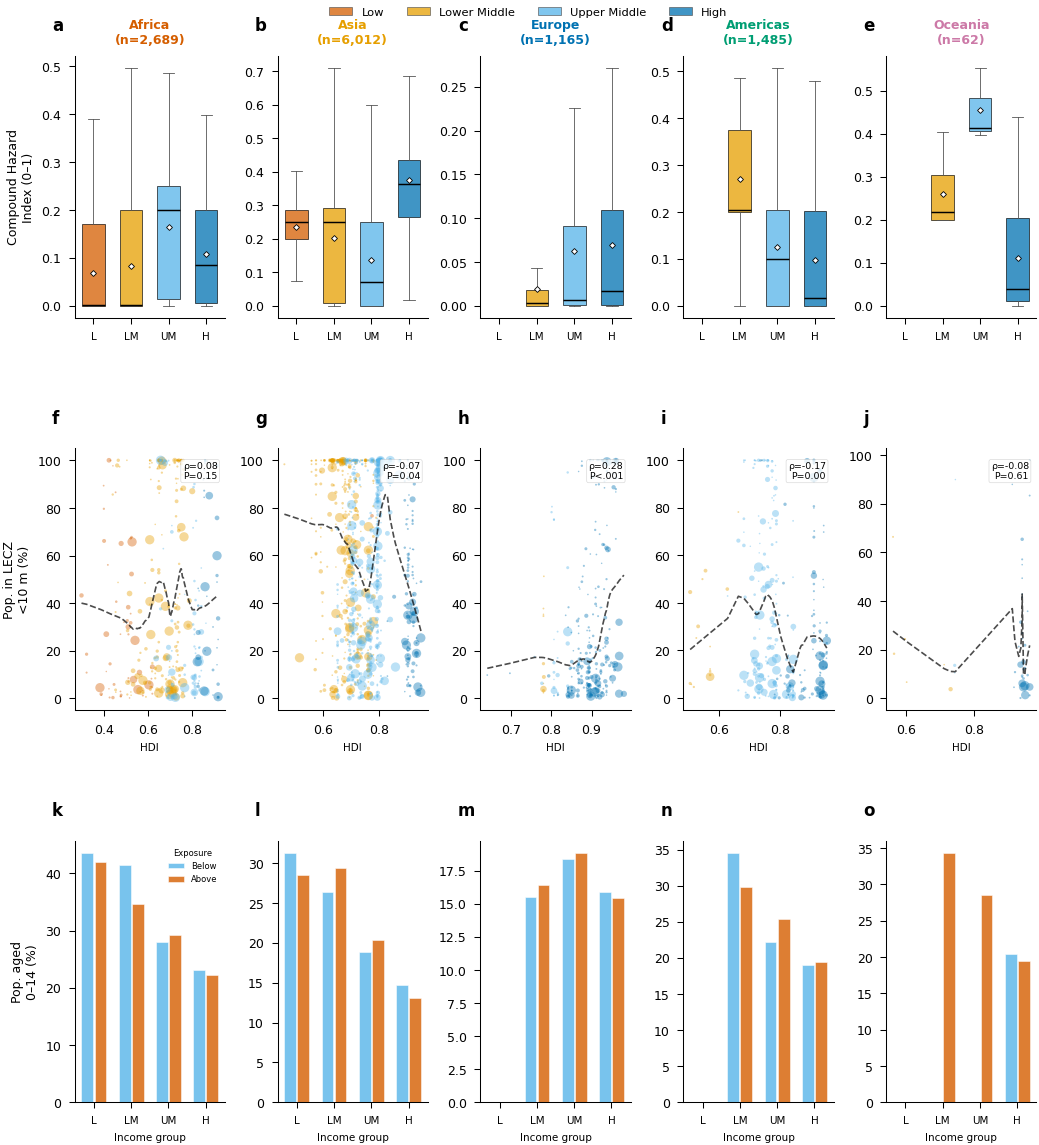


EXTENDED DATA FIGURE 2: Sensitivity analysis
  Saved: figures/ExtendedData_Fig2_sensitivity_analysis.pdf, figures/ExtendedData_Fig2_sensitivity_analysis.png


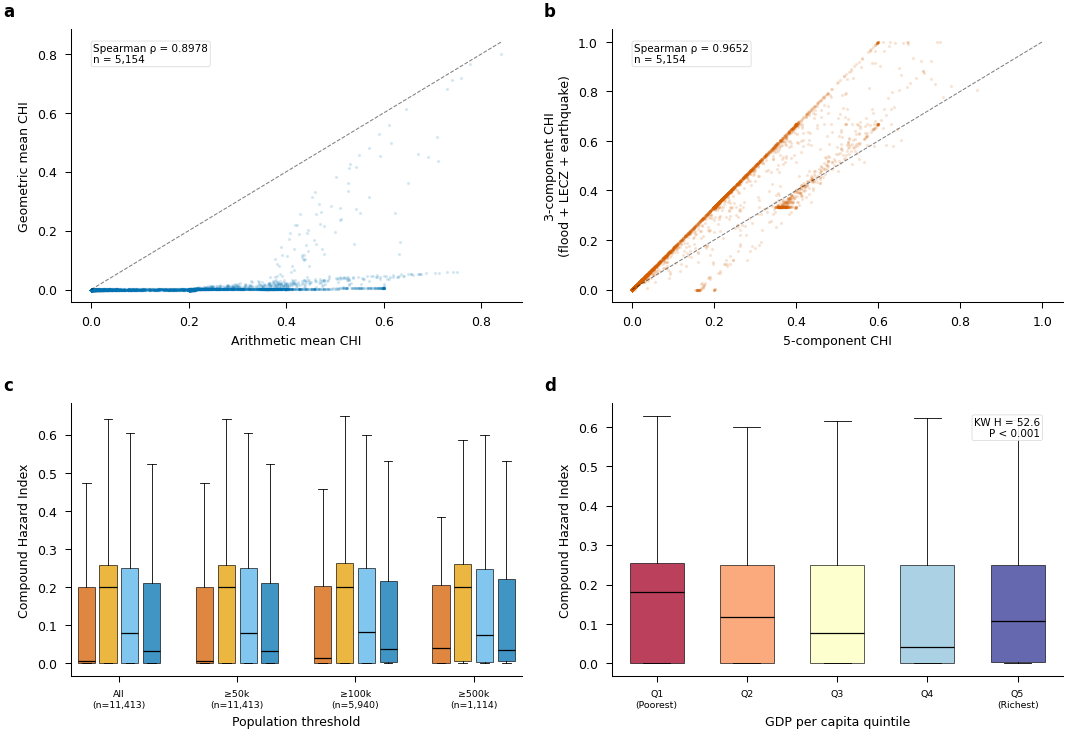


EXTENDED DATA FIGURE 3: Correlation matrix
  Using 11,413 observations with ≥50% non-missing
  Saved: figures/ExtendedData_Fig3_correlation_matrix.pdf, figures/ExtendedData_Fig3_correlation_matrix.png


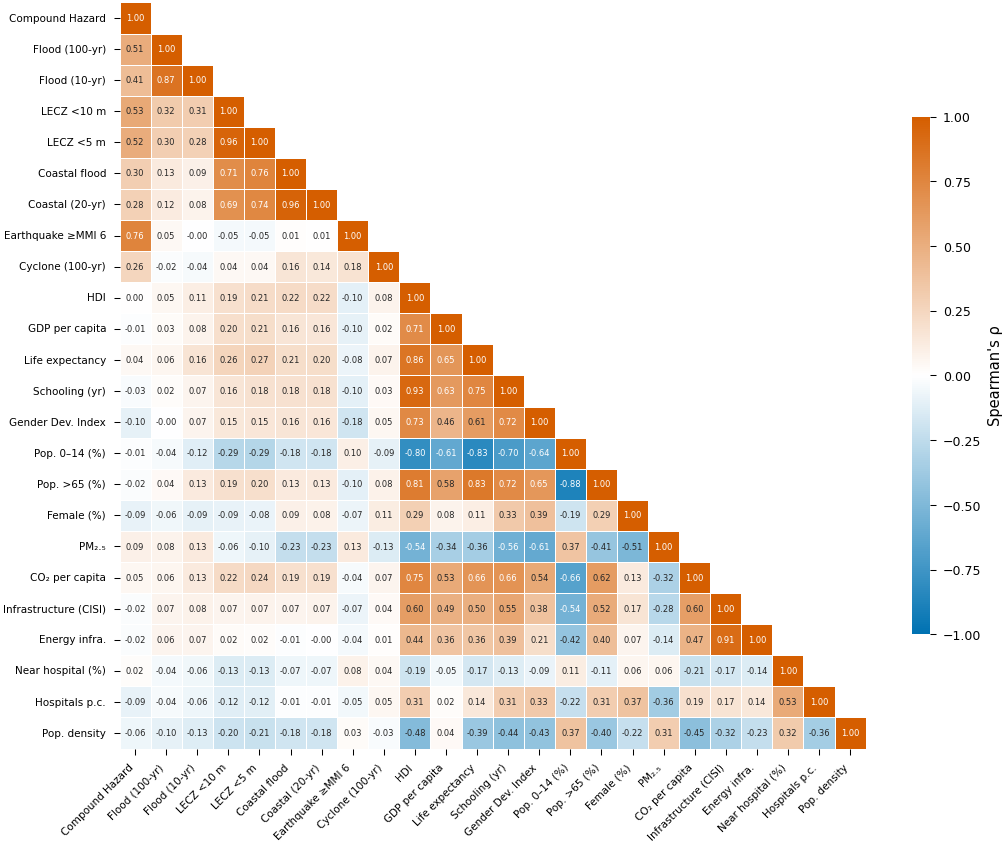

  Saved: tables/ExtendedData_Fig3_correlation_values.csv

EXTENDED DATA TABLE 1: Full regression results
  τ = 0.10 done
  τ = 0.25 done
  τ = 0.50 done
  τ = 0.75 done
  τ = 0.90 done

  Extended Data Table 1:
                              Variable              OLS (1)              OLS (2)              OLS (3)              OLS (4)         QR τ=0.10         QR τ=0.25           QR τ=0.50            QR τ=0.75            QR τ=0.90
                            Low income -0.0367***\n(0.0051)     0.0028\n(0.0062)     0.0008\n(0.0080)                                    NaN               NaN                 NaN                  NaN                  NaN
                   Lower Middle income  0.0494***\n(0.0044)  0.0761***\n(0.0051)    -0.0001\n(0.0069)                                    NaN               NaN                 NaN                  NaN                  NaN
                   Upper Middle income  0.0151***\n(0.0043)  0.0343***\n(0.0046) -0.0719***\n(0.0059)                         

In [ ]:
#!/usr/bin/env python3
"""
===============================================================================
EXTENDED DATA — Climate Justice & Urban Inequality
===============================================================================

Companion to the main analysis script. Run AFTER the main script so that
`df_valid`, style settings, and helper functions are already in memory.

Outputs:
  Extended Data Fig. 1  — Regional disaggregation of main figures (5 regions)
  Extended Data Fig. 2  — Sensitivity analysis (alternative index, weighting)
  Extended Data Fig. 3  — Correlation matrix of exposure & socioeconomic vars
  Extended Data Table 1 — Full regression results (OLS + quantile)
  Extended Data Table 2 — Robustness check results (structured)
  Extended Data Table 3 — Top 50 most exposed low-income urban centres

Requires: df_valid, INCOME_ORDER, INCOME_COLORS, WONG_PALETTE,
          NATURE_DOUBLE_COL, NATURE_SINGLE_COL, FIGURE_DPI,
          add_panel_label(), save_figure()
===============================================================================
"""

# =============================================================================
# EXTENDED DATA CELL 0: VERIFY PREREQUISITES
# =============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu, spearmanr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import OrderedDict

os.makedirs('figures', exist_ok=True)
os.makedirs('tables', exist_ok=True)

# Verify main script has been run
try:
    _ = df_valid.shape[0]
    print(f"Prerequisites OK. Analytical sample: {df_valid.shape[0]:,} urban centres")
except NameError:
    raise RuntimeError("Run the main analysis script first to create df_valid.")

# --- Region mapping ---
# Map SDG regions to 5 broad continental groups for display
def assign_broad_region(sdg_region):
    """Map UN SDG sub-regions to five broad continental groups."""
    if pd.isna(sdg_region):
        return np.nan
    s = str(sdg_region).lower()
    if any(k in s for k in ['africa', 'saharan', 'sahara']):
        return 'Africa'
    elif any(k in s for k in ['asia', 'oceania', 'pacific', 'australia', 'zealand']):
        # Split Oceania out if enough observations
        if any(k in s for k in ['oceania', 'pacific', 'australia', 'zealand']):
            return 'Oceania'
        return 'Asia'
    elif any(k in s for k in ['europe', 'european']):
        return 'Europe'
    elif any(k in s for k in ['america', 'latin', 'caribbean', 'northern america']):
        return 'Americas'
    else:
        return 'Other'

df_valid = df_valid.copy()
df_valid['broad_region'] = df_valid['sdg_region'].apply(assign_broad_region)

# Check region counts
print("\nBroad region distribution:")
region_counts = df_valid['broad_region'].value_counts(dropna=False)
print(region_counts)

# Define region order (only regions with ≥50 cities)
REGION_ORDER = [r for r in ['Africa', 'Asia', 'Europe', 'Americas', 'Oceania']
                if r in region_counts.index and region_counts[r] >= 50]
print(f"\nRegions for analysis ({len(REGION_ORDER)}): {REGION_ORDER}")

# Region colour palette
REGION_COLORS = {
    'Africa':   '#D55E00',  # vermilion
    'Asia':     '#E69F00',  # orange
    'Europe':   '#0072B2',  # blue
    'Americas': '#009E73',  # green
    'Oceania':  '#CC79A7',  # purple
}

# =============================================================================
# EXTENDED DATA FIGURE 1: REGIONAL DISAGGREGATION OF MAIN FIGURES
# =============================================================================
# Replicates key panels from Figures 1, 2, and 4 stratified by broad region.
# Layout: 3 rows × len(REGION_ORDER) columns
#   Row 1: Compound Hazard Index by income group (regional Figure 1d)
#   Row 2: LECZ vs HDI scatter (regional Figure 2)
#   Row 3: Youth population by income × exposure (regional Figure 4a)

print("\n" + "="*80)
print("EXTENDED DATA FIGURE 1: Regional disaggregation")
print("="*80)

def ed_figure1_regional(data, regions, income_order, income_colors, region_colors):
    """
    Extended Data Fig. 1: Three-row panel showing key results by region.
    Each column = one region; each row = one indicator.
    """
    n_reg = len(regions)
    fig = plt.figure(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 1.1))
    gs = gridspec.GridSpec(3, n_reg, hspace=0.5, wspace=0.35,
                           left=0.08, right=0.97, top=0.94, bottom=0.06)

    panel_idx = 0
    letters = 'abcdefghijklmnopqrst'

    # -------------------------------------------------------------------------
    # ROW 1: Compound Hazard Index box plots by income group (per region)
    # -------------------------------------------------------------------------
    for col_idx, region in enumerate(regions):
        ax = fig.add_subplot(gs[0, col_idx])
        rd = data[data['broad_region'] == region]

        plot_data = []
        for grp in income_order:
            vals = rd.loc[rd['income_group'] == grp, 'compound_hazard_index'].dropna()
            plot_data.append(vals if len(vals) > 0 else pd.Series([np.nan]))

        bp = ax.boxplot(
            plot_data, positions=range(len(income_order)), widths=0.6,
            patch_artist=True, showfliers=False, showmeans=True,
            meanprops=dict(marker='D', markerfacecolor='white',
                          markeredgecolor='black', markersize=2, markeredgewidth=0.4),
            medianprops=dict(color='black', linewidth=0.7),
            whiskerprops=dict(linewidth=0.4, color='#555'),
            capprops=dict(linewidth=0.4, color='#555'),
            boxprops=dict(linewidth=0.4))

        for patch, grp in zip(bp['boxes'], income_order):
            patch.set_facecolor(income_colors[grp])
            patch.set_alpha(0.75)

        short_labels = ['L', 'LM', 'UM', 'H']
        ax.set_xticks(range(len(income_order)))
        ax.set_xticklabels(short_labels, fontsize=5)
        ax.set_title(f'{region}\n(n={len(rd):,})', fontsize=6, fontweight='bold',
                     color=region_colors.get(region, '#333'))

        if col_idx == 0:
            ax.set_ylabel('Compound Hazard\nIndex (0–1)', fontsize=6)
        else:
            ax.set_ylabel('')

        add_panel_label(ax, letters[panel_idx], x=-0.15, y=1.15)
        panel_idx += 1

    # -------------------------------------------------------------------------
    # ROW 2: LECZ vs HDI scatter (per region)
    # -------------------------------------------------------------------------
    for col_idx, region in enumerate(regions):
        ax = fig.add_subplot(gs[1, col_idx])
        rd = data[(data['broad_region'] == region) &
                  data['share_pop_lecz_below10m'].notna() &
                  (data['share_pop_lecz_below10m'] > 0) &
                  data['hdi'].notna()]

        if len(rd) < 10:
            ax.text(0.5, 0.5, f'n = {len(rd)}\n(insufficient)', transform=ax.transAxes,
                   ha='center', va='center', fontsize=5, color='grey')
            add_panel_label(ax, letters[panel_idx], x=-0.15, y=1.15)
            panel_idx += 1
            continue

        for grp in income_order:
            gd = rd[rd['income_group'] == grp]
            if len(gd) == 0:
                continue
            sizes = np.clip(gd['population'] / 100000, 0.5, 20)
            ax.scatter(gd['hdi'], gd['share_pop_lecz_below10m'],
                      s=sizes, alpha=0.4, color=income_colors[grp],
                      edgecolors='none', rasterized=True)

        # LOWESS
        valid = rd[['hdi', 'share_pop_lecz_below10m']].dropna()
        if len(valid) > 30:
            sm_out = lowess(valid['share_pop_lecz_below10m'], valid['hdi'],
                           frac=0.4, return_sorted=True)
            ax.plot(sm_out[:, 0], sm_out[:, 1], color='black', lw=0.8, ls='--', alpha=0.7)

        # Spearman
        if len(valid) > 10:
            rho, p = spearmanr(valid['hdi'], valid['share_pop_lecz_below10m'])
            ptxt = 'P<.001' if p < 0.001 else f'P={p:.2f}'
            ax.text(0.95, 0.95, f'ρ={rho:.2f}\n{ptxt}', transform=ax.transAxes,
                   fontsize=4.5, va='top', ha='right',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                            edgecolor='#ccc', alpha=0.8, linewidth=0.3))

        ax.set_xlabel('HDI', fontsize=5)
        if col_idx == 0:
            ax.set_ylabel('Pop. in LECZ\n<10 m (%)', fontsize=6)
        else:
            ax.set_ylabel('')

        add_panel_label(ax, letters[panel_idx], x=-0.15, y=1.15)
        panel_idx += 1

    # -------------------------------------------------------------------------
    # ROW 3: Youth population (0–14) by income × exposure (per region)
    # -------------------------------------------------------------------------
    for col_idx, region in enumerate(regions):
        ax = fig.add_subplot(gs[2, col_idx])
        rd = data[data['broad_region'] == region].copy()

        if 'pct_young' not in rd.columns or rd['pct_young'].notna().sum() < 20:
            ax.text(0.5, 0.5, 'Insufficient data', transform=ax.transAxes,
                   ha='center', va='center', fontsize=5, color='grey')
            add_panel_label(ax, letters[panel_idx], x=-0.15, y=1.15)
            panel_idx += 1
            continue

        med_haz = rd['compound_hazard_index'].median()
        rd['high_exp'] = rd['compound_hazard_index'] >= med_haz

        bw = 0.35
        x = np.arange(len(income_order))

        for i, (el, ev) in enumerate([('Below', False), ('Above', True)]):
            means = []
            for grp in income_order:
                v = rd.loc[(rd['income_group']==grp) & (rd['high_exp']==ev), 'pct_young'].dropna()
                means.append(v.mean() if len(v) > 0 else 0)
            off = -bw/2 + i*bw
            col = WONG_PALETTE['sky_blue'] if not ev else WONG_PALETTE['vermilion']
            ax.bar(x+off, means, bw*0.9, color=col, alpha=0.8,
                   edgecolor='white', linewidth=0.3, label=el if col_idx == 0 else '')

        short_labels = ['L', 'LM', 'UM', 'H']
        ax.set_xticks(x)
        ax.set_xticklabels(short_labels, fontsize=5)
        ax.set_xlabel('Income group', fontsize=5)

        if col_idx == 0:
            ax.set_ylabel('Pop. aged\n0–14 (%)', fontsize=6)
            ax.legend(fontsize=4, loc='upper right', title='Exposure', title_fontsize=4)
        else:
            ax.set_ylabel('')

        add_panel_label(ax, letters[panel_idx], x=-0.15, y=1.15)
        panel_idx += 1

    # Shared legend for income groups (top)
    leg_el = [mpatches.Patch(facecolor=income_colors[g], alpha=0.75,
              edgecolor='#555', linewidth=0.4, label=g) for g in income_order]
    fig.legend(handles=leg_el, loc='upper center', ncol=4, fontsize=5.5,
              frameon=False, bbox_to_anchor=(0.5, 0.99))

    save_figure(fig, 'ExtendedData_Fig1_regional_disaggregation')
    plt.show()
    return fig


ed_fig1 = ed_figure1_regional(df_valid, REGION_ORDER, INCOME_ORDER,
                               INCOME_COLORS, REGION_COLORS)

# =============================================================================
# EXTENDED DATA FIGURE 2: SENSITIVITY ANALYSIS
# =============================================================================
# Tests robustness of the Compound Hazard Index to:
#   Panel a: Equal-weight (arithmetic mean) vs. geometric mean
#   Panel b: 3-component index (flood + LECZ + earthquake) vs. 5-component
#   Panel c: Population threshold sensitivity (all, ≥50k, ≥100k, ≥500k)
#   Panel d: Income classification — WB groups vs. GDP quintiles

print("\n" + "="*80)
print("EXTENDED DATA FIGURE 2: Sensitivity analysis")
print("="*80)

def ed_figure2_sensitivity(data, income_order, income_colors):
    """Extended Data Fig. 2: Four-panel sensitivity analysis."""
    fig, axes = plt.subplots(2, 2, figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.7))

    # --- Panel a: Arithmetic vs Geometric mean index ---
    ax = axes[0, 0]
    norm_cols = [c for c in data.columns if c.endswith('_norm')]
    if norm_cols:
        eps = 1e-6
        dc = data[['compound_hazard_index'] + norm_cols].dropna().copy()
        dc['chi_geometric'] = np.exp(
            dc[norm_cols].apply(lambda x: np.log(x + eps)).mean(axis=1))

        ax.scatter(dc['compound_hazard_index'], dc['chi_geometric'],
                  s=0.3, alpha=0.15, color=WONG_PALETTE['blue'], rasterized=True)
        # 1:1 line
        lims = [0, max(dc['compound_hazard_index'].max(), dc['chi_geometric'].max())]
        ax.plot(lims, lims, 'k--', lw=0.5, alpha=0.5)

        rho, p = spearmanr(dc['compound_hazard_index'], dc['chi_geometric'])
        ax.text(0.05, 0.95, f'Spearman ρ = {rho:.4f}\nn = {len(dc):,}',
               transform=ax.transAxes, fontsize=5, va='top',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                        edgecolor='#ccc', alpha=0.9, linewidth=0.3))
        ax.set_xlabel('Arithmetic mean CHI', fontsize=6)
        ax.set_ylabel('Geometric mean CHI', fontsize=6)
    add_panel_label(ax, 'a', x=-0.15, y=1.1)

    # --- Panel b: 3-component vs 5-component index ---
    ax = axes[0, 1]
    comp3_vars = ['share_pop_flood_100yr_norm', 'share_pop_lecz_below10m_norm',
                  'share_pop_earthquake_mmi6_norm']
    comp3_avail = [v for v in comp3_vars if v in data.columns]

    if len(comp3_avail) >= 2:
        dc = data[['compound_hazard_index'] + comp3_avail].dropna().copy()
        dc['chi_3comp'] = dc[comp3_avail].mean(axis=1)

        ax.scatter(dc['compound_hazard_index'], dc['chi_3comp'],
                  s=0.3, alpha=0.15, color=WONG_PALETTE['vermilion'], rasterized=True)
        lims = [0, max(dc['compound_hazard_index'].max(), dc['chi_3comp'].max())]
        ax.plot(lims, lims, 'k--', lw=0.5, alpha=0.5)

        rho, p = spearmanr(dc['compound_hazard_index'], dc['chi_3comp'])
        ax.text(0.05, 0.95, f'Spearman ρ = {rho:.4f}\nn = {len(dc):,}',
               transform=ax.transAxes, fontsize=5, va='top',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                        edgecolor='#ccc', alpha=0.9, linewidth=0.3))
        ax.set_xlabel('5-component CHI', fontsize=6)
        ax.set_ylabel('3-component CHI\n(flood + LECZ + earthquake)', fontsize=6)
    add_panel_label(ax, 'b', x=-0.15, y=1.1)

    # --- Panel c: Population threshold sensitivity ---
    ax = axes[1, 0]
    thresholds = [0, 50000, 100000, 500000]
    threshold_labels = ['All', '≥50k', '≥100k', '≥500k']

    positions = []
    bp_data_all = []
    bp_colors = []
    xtick_positions = []
    xtick_labels = []

    spacing = 0.0
    for t_idx, (thresh, t_label) in enumerate(zip(thresholds, threshold_labels)):
        sub = data[data['population'] >= thresh] if thresh > 0 else data
        for g_idx, grp in enumerate(income_order):
            vals = sub.loc[sub['income_group'] == grp, 'compound_hazard_index'].dropna()
            bp_data_all.append(vals if len(vals) > 0 else pd.Series([np.nan]))
            pos = spacing + g_idx * 0.7
            positions.append(pos)
            bp_colors.append(income_colors[grp])
        center = spacing + 1.5 * 0.7
        xtick_positions.append(center)
        xtick_labels.append(f'{t_label}\n(n={len(sub):,})')
        spacing += len(income_order) * 0.7 + 1.0

    bp = ax.boxplot(bp_data_all, positions=positions, widths=0.55,
                    patch_artist=True, showfliers=False,
                    medianprops=dict(color='black', linewidth=0.6),
                    whiskerprops=dict(linewidth=0.4), capprops=dict(linewidth=0.4),
                    boxprops=dict(linewidth=0.4))

    for patch, col in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(col)
        patch.set_alpha(0.75)

    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, fontsize=4.5)
    ax.set_ylabel('Compound Hazard Index', fontsize=6)
    ax.set_xlabel('Population threshold', fontsize=6)
    add_panel_label(ax, 'c', x=-0.15, y=1.1)

    # --- Panel d: WB groups vs GDP quintiles ---
    ax = axes[1, 1]
    if 'gdp_avg' in data.columns:
        sub = data[data['gdp_avg'].notna()].copy()
        try:
            sub['gdp_quintile'] = pd.qcut(sub['gdp_avg'], q=5,
                labels=['Q1\n(Poorest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Richest)'],
                duplicates='drop')

            gdp_qs = sub['gdp_quintile'].cat.categories.tolist()
            bp_data = [sub.loc[sub['gdp_quintile']==q, 'compound_hazard_index'].dropna()
                       for q in gdp_qs]

            # Use a gradient from vermilion to blue
            n_q = len(gdp_qs)
            gdp_colors = [plt.cm.RdYlBu(i / (n_q - 1)) for i in range(n_q)]

            bp2 = ax.boxplot(bp_data, positions=range(n_q), widths=0.6,
                            patch_artist=True, showfliers=False,
                            medianprops=dict(color='black', linewidth=0.6),
                            whiskerprops=dict(linewidth=0.4),
                            capprops=dict(linewidth=0.4),
                            boxprops=dict(linewidth=0.4))

            for patch, col in zip(bp2['boxes'], gdp_colors):
                patch.set_facecolor(col)
                patch.set_alpha(0.75)

            ax.set_xticks(range(n_q))
            ax.set_xticklabels(gdp_qs, fontsize=4.5)
            ax.set_ylabel('Compound Hazard Index', fontsize=6)
            ax.set_xlabel('GDP per capita quintile', fontsize=6)

            # KW test
            valid_g = [g for g in bp_data if len(g) >= 5]
            if len(valid_g) >= 2:
                h, p = kruskal(*valid_g)
                ptxt = 'P < 0.001' if p < 0.001 else f'P = {p:.3f}'
                ax.text(0.95, 0.95, f'KW H = {h:.1f}\n{ptxt}',
                       transform=ax.transAxes, fontsize=5, va='top', ha='right',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                                edgecolor='#ccc', alpha=0.9, linewidth=0.3))
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {e}', transform=ax.transAxes,
                   ha='center', fontsize=5, color='grey')

    add_panel_label(ax, 'd', x=-0.15, y=1.1)

    plt.tight_layout(h_pad=2, w_pad=1.5)
    save_figure(fig, 'ExtendedData_Fig2_sensitivity_analysis')
    plt.show()
    return fig


ed_fig2 = ed_figure2_sensitivity(df_valid, INCOME_ORDER, INCOME_COLORS)

# =============================================================================
# EXTENDED DATA FIGURE 3: CORRELATION MATRIX
# =============================================================================
# Full Spearman correlation matrix of all exposure and socioeconomic variables.

print("\n" + "="*80)
print("EXTENDED DATA FIGURE 3: Correlation matrix")
print("="*80)

def ed_figure3_correlation(data):
    """Extended Data Fig. 3: Spearman correlation heatmap."""
    corr_vars = OrderedDict([
        # Exposure variables
        ('compound_hazard_index',    'Compound Hazard'),
        ('share_pop_flood_100yr',    'Flood (100-yr)'),
        ('share_pop_flood_10yr',     'Flood (10-yr)'),
        ('share_pop_lecz_below10m',  'LECZ <10 m'),
        ('share_pop_lecz_5m',        'LECZ <5 m'),
        ('share_pop_coastal_100yr',  'Coastal flood'),
        ('share_pop_coastal_20yr',   'Coastal (20-yr)'),
        ('share_pop_earthquake_mmi6','Earthquake ≥MMI 6'),
        ('share_pop_cyclone_100yr',  'Cyclone (100-yr)'),
        # Socioeconomic
        ('hdi',           'HDI'),
        ('gdp_avg',       'GDP per capita'),
        ('life_exp',      'Life expectancy'),
        ('schooling_exp', 'Schooling (yr)'),
        ('gdi',           'Gender Dev. Index'),
        # Demographics
        ('pct_young',     'Pop. 0–14 (%)'),
        ('pct_old',       'Pop. >65 (%)'),
        ('pct_female',    'Female (%)'),
        # Environment & infrastructure
        ('pm25_conc',     'PM₂.₅'),
        ('co2_per_capita','CO₂ per capita'),
        ('cisi_all',      'Infrastructure (CISI)'),
        ('cisi_energy',   'Energy infra.'),
        ('share_pop_near_hospital', 'Near hospital (%)'),
        ('hospitals_per_cap',       'Hospitals p.c.'),
        # Urban form
        ('pop_density',   'Pop. density'),
    ])

    available = OrderedDict((k, v) for k, v in corr_vars.items() if k in data.columns)
    sub = data[list(available.keys())].dropna(thresh=len(available)*0.5)

    if len(sub) < 50:
        print(f"  Only {len(sub)} complete obs — using pairwise correlations")
        corr = data[list(available.keys())].corr(method='spearman')
    else:
        corr = sub.corr(method='spearman')
        print(f"  Using {len(sub):,} observations with ≥50% non-missing")

    corr.index = [available[c] for c in corr.index]
    corr.columns = [available[c] for c in corr.columns]

    n_vars = len(corr)
    fig_height = max(NATURE_DOUBLE_COL * 0.65, n_vars * 0.3)
    fig, ax = plt.subplots(figsize=(NATURE_DOUBLE_COL, fig_height))

    cmap = LinearSegmentedColormap.from_list(
        'div', [WONG_PALETTE['blue'], '#FFFFFF', WONG_PALETTE['vermilion']], N=256)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.3, linecolor='white',
                annot=True, fmt='.2f', annot_kws={'size': 4},
                cbar_kws={'shrink': 0.5, 'label': "Spearman's ρ",
                          'aspect': 30}, ax=ax)

    ax.tick_params(labelsize=5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    save_figure(fig, 'ExtendedData_Fig3_correlation_matrix')
    plt.show()

    # Also save correlation values as CSV
    corr_full = corr.copy()
    corr_full.to_csv('tables/ExtendedData_Fig3_correlation_values.csv')
    print("  Saved: tables/ExtendedData_Fig3_correlation_values.csv")
    return fig


ed_fig3 = ed_figure3_correlation(df_valid)

# =============================================================================
# EXTENDED DATA TABLE 1: FULL REGRESSION RESULTS (OLS + QUANTILE)
# =============================================================================
# Combines OLS models 1–4 with quantile regression coefficients at
# τ = 0.10, 0.25, 0.50, 0.75, 0.90 in a single exportable table.

print("\n" + "="*80)
print("EXTENDED DATA TABLE 1: Full regression results")
print("="*80)

def ed_table1_regressions(data, income_order):
    """Extended Data Table 1: OLS + quantile regression results."""
    rd = data[['compound_hazard_index', 'income_group', 'sdg_region',
               'area_km2', 'population', 'hdi']].dropna().copy()

    if len(rd) < 100:
        print("  Too few observations"); return None

    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])

    # --- OLS Models ---
    m1 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))',
                  data=rd).fit(cov_type='HC3')
    m2 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area', data=rd).fit(cov_type='HC3')
    m3 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area + C(sdg_region)', data=rd).fit(cov_type='HC3')
    m4 = smf.ols('compound_hazard_index ~ hdi + log_pop + log_area',
                  data=rd).fit(cov_type='HC3')

    # --- Quantile Regressions ---
    rd_qr = pd.get_dummies(rd, columns=['income_group'], drop_first=False, dtype=float)
    dummies = [f'income_group_{g}' for g in income_order if g != 'High'
               and f'income_group_{g}' in rd_qr.columns]
    X_qr = sm.add_constant(rd_qr[dummies + ['log_pop', 'log_area']].astype(float))
    y_qr = rd_qr['compound_hazard_index'].astype(float)

    quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
    qr_results = {}
    for q in quantiles:
        try:
            res = QuantReg(y_qr, X_qr).fit(q=q, max_iter=5000)
            qr_results[q] = res
            print(f"  τ = {q:.2f} done")
        except Exception as e:
            print(f"  τ = {q:.2f} failed: {e}")

    # --- Build combined table ---
    rows = []

    # Key variable labels to extract from OLS
    ols_var_labels = {
        'C(income_group, Treatment(reference="High"))[T.Low]': 'Low income',
        'C(income_group, Treatment(reference="High"))[T.Lower Middle]': 'Lower Middle income',
        'C(income_group, Treatment(reference="High"))[T.Upper Middle]': 'Upper Middle income',
        'log_pop': 'log(Population)',
        'log_area': 'log(Area km²)',
        'hdi': 'HDI',
        'Intercept': 'Intercept',
    }

    # OLS section
    for var_key, var_label in ols_var_labels.items():
        row = {'Variable': var_label}
        for m_idx, (m_name, model) in enumerate([
            ('OLS (1)', m1), ('OLS (2)', m2), ('OLS (3)', m3), ('OLS (4)', m4)
        ]):
            if var_key in model.params.index:
                coef = model.params[var_key]
                se = model.bse[var_key]
                p = model.pvalues[var_key]
                stars = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
                row[m_name] = f"{coef:.4f}{stars}\n({se:.4f})"
            else:
                row[m_name] = ''
        rows.append(row)

    # Model fit statistics
    for stat_name, stat_func in [
        ('N', lambda m: f"{int(m.nobs):,}"),
        ('R²', lambda m: f"{m.rsquared:.4f}"),
        ('Adj. R²', lambda m: f"{m.rsquared_adj:.4f}"),
        ('F-statistic', lambda m: f"{m.fvalue:.2f}"),
    ]:
        row = {'Variable': stat_name}
        for m_name, model in [('OLS (1)', m1), ('OLS (2)', m2),
                               ('OLS (3)', m3), ('OLS (4)', m4)]:
            try:
                row[m_name] = stat_func(model)
            except:
                row[m_name] = ''
        rows.append(row)

    # Blank separator
    rows.append({'Variable': ''})
    rows.append({'Variable': 'QUANTILE REGRESSION (ref: High income)'})

    # Quantile regression section
    qr_var_labels = {}
    for d in dummies:
        gl = d.replace('income_group_', '')
        qr_var_labels[d] = f'{gl} income'
    qr_var_labels['log_pop'] = 'log(Population)'
    qr_var_labels['log_area'] = 'log(Area km²)'
    qr_var_labels['const'] = 'Intercept'

    for var_key, var_label in qr_var_labels.items():
        row = {'Variable': var_label}
        for q in quantiles:
            col_name = f'QR τ={q:.2f}'
            if q in qr_results and var_key in qr_results[q].params.index:
                res = qr_results[q]
                coef = res.params[var_key]
                se = res.bse[var_key]
                p = res.pvalues[var_key]
                stars = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
                row[col_name] = f"{coef:.4f}{stars}\n({se:.4f})"
            else:
                row[col_name] = ''
        rows.append(row)

    # QR pseudo-R²
    row = {'Variable': 'Pseudo R²'}
    for q in quantiles:
        col_name = f'QR τ={q:.2f}'
        if q in qr_results:
            row[col_name] = f"{qr_results[q].prsquared:.4f}"
        else:
            row[col_name] = ''
    rows.append(row)

    row = {'Variable': 'N'}
    for q in quantiles:
        col_name = f'QR τ={q:.2f}'
        if q in qr_results:
            row[col_name] = f"{int(qr_results[q].nobs):,}"
        else:
            row[col_name] = ''
    rows.append(row)

    # Assemble DataFrame
    ed_t1 = pd.DataFrame(rows)

    # Reorder columns
    ols_cols = ['OLS (1)', 'OLS (2)', 'OLS (3)', 'OLS (4)']
    qr_cols = [f'QR τ={q:.2f}' for q in quantiles]
    all_cols = ['Variable'] + ols_cols + qr_cols
    for c in all_cols:
        if c not in ed_t1.columns:
            ed_t1[c] = ''
    ed_t1 = ed_t1[all_cols]

    # Save
    ed_t1.to_csv('tables/ExtendedData_Table1_full_regression.csv', index=False)
    ed_t1.to_excel('tables/ExtendedData_Table1_full_regression.xlsx', index=False)

    print("\n  Extended Data Table 1:")
    print(ed_t1.to_string(index=False))
    print("\n  Saved: tables/ExtendedData_Table1_full_regression.csv/.xlsx")

    return ed_t1, {'m1': m1, 'm2': m2, 'm3': m3, 'm4': m4, 'qr': qr_results}


ed_t1, all_models = ed_table1_regressions(df_valid, INCOME_ORDER)

# =============================================================================
# EXTENDED DATA TABLE 2: ROBUSTNESS CHECK RESULTS (STRUCTURED)
# =============================================================================
# Produces a single table summarising all robustness checks with median CHI,
# IQR, N, and Kruskal-Wallis test statistics.

print("\n" + "="*80)
print("EXTENDED DATA TABLE 2: Robustness checks")
print("="*80)

def ed_table2_robustness(data, income_order):
    """Extended Data Table 2: Structured robustness check results."""
    rows = []

    # --- Check 1: Population thresholds ---
    for thresh, label in [(0, 'All cities'), (50000, 'Pop ≥ 50,000'),
                           (100000, 'Pop ≥ 100,000'), (500000, 'Pop ≥ 500,000')]:
        sub = data[data['population'] >= thresh] if thresh > 0 else data
        row = {'Check': 'Population threshold', 'Specification': label,
               'N': sub.shape[0]}

        for grp in income_order:
            vals = sub.loc[sub['income_group'] == grp, 'compound_hazard_index'].dropna()
            if len(vals) > 0:
                row[f'{grp} median'] = f"{vals.median():.4f}"
                row[f'{grp} IQR'] = f"{vals.quantile(0.25):.4f}–{vals.quantile(0.75):.4f}"
                row[f'{grp} N'] = len(vals)
            else:
                row[f'{grp} median'] = '—'
                row[f'{grp} IQR'] = '—'
                row[f'{grp} N'] = 0

        groups = [sub.loc[sub['income_group']==g, 'compound_hazard_index'].dropna()
                  for g in income_order]
        valid = [g for g in groups if len(g) >= 5]
        if len(valid) >= 2:
            h, p = kruskal(*valid)
            row['KW H'] = f"{h:.2f}"
            row['KW p'] = '<0.001' if p < 0.001 else f"{p:.3f}"
        else:
            row['KW H'] = '—'; row['KW p'] = '—'
        rows.append(row)

    # --- Check 2: GDP quintile classification ---
    if 'gdp_avg' in data.columns:
        sub = data[data['gdp_avg'].notna()].copy()
        try:
            sub['gdp_q'] = pd.qcut(sub['gdp_avg'], q=5,
                                    labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
                                    duplicates='drop')
            for q_label in sub['gdp_q'].cat.categories:
                vals = sub.loc[sub['gdp_q'] == q_label, 'compound_hazard_index'].dropna()
                row = {
                    'Check': 'GDP quintile classification',
                    'Specification': f'GDP {q_label}',
                    'N': len(vals),
                    f'All median': f"{vals.median():.4f}" if len(vals) > 0 else '—',
                    f'All IQR': f"{vals.quantile(0.25):.4f}–{vals.quantile(0.75):.4f}" if len(vals) > 0 else '—',
                }
                rows.append(row)

            # KW across GDP quintiles
            gdp_groups = [sub.loc[sub['gdp_q']==q, 'compound_hazard_index'].dropna()
                          for q in sub['gdp_q'].cat.categories]
            valid = [g for g in gdp_groups if len(g) >= 5]
            if len(valid) >= 2:
                h, p = kruskal(*valid)
                rows[-1]['KW H'] = f"{h:.2f}"
                rows[-1]['KW p'] = '<0.001' if p < 0.001 else f"{p:.3f}"
        except Exception as e:
            print(f"  GDP quintile check skipped: {e}")

    # --- Check 3: LECZ threshold sensitivity ---
    for lecz_var, label in [('share_pop_lecz_below10m', 'LECZ <10 m'),
                              ('share_pop_lecz_5m', 'LECZ <5 m')]:
        if lecz_var not in data.columns:
            continue
        row = {'Check': 'LECZ threshold', 'Specification': label,
               'N': data[lecz_var].notna().sum()}
        for grp in income_order:
            vals = data.loc[data['income_group'] == grp, lecz_var].dropna()
            if len(vals) > 0:
                row[f'{grp} median'] = f"{vals.median():.2f}"
                row[f'{grp} IQR'] = f"{vals.quantile(0.25):.2f}–{vals.quantile(0.75):.2f}"
                row[f'{grp} N'] = len(vals)
            else:
                row[f'{grp} median'] = '—'; row[f'{grp} IQR'] = '—'; row[f'{grp} N'] = 0
        groups = [data.loc[data['income_group']==g, lecz_var].dropna() for g in income_order]
        valid = [g for g in groups if len(g) >= 5]
        if len(valid) >= 2:
            h, p = kruskal(*valid)
            row['KW H'] = f"{h:.2f}"
            row['KW p'] = '<0.001' if p < 0.001 else f"{p:.3f}"
        rows.append(row)

    # --- Check 4: Index construction method ---
    norm_cols = [c for c in data.columns if c.endswith('_norm')]
    if norm_cols:
        eps = 1e-6
        dc = data.copy()
        dc['chi_geo'] = np.exp(dc[norm_cols].apply(lambda x: np.log(x + eps)).mean(axis=1))

        for method, var in [('Arithmetic mean (baseline)', 'compound_hazard_index'),
                             ('Geometric mean', 'chi_geo')]:
            row = {'Check': 'Index construction', 'Specification': method,
                   'N': dc[var].notna().sum()}
            for grp in income_order:
                vals = dc.loc[dc['income_group'] == grp, var].dropna()
                if len(vals) > 0:
                    row[f'{grp} median'] = f"{vals.median():.4f}"
                    row[f'{grp} N'] = len(vals)
            groups = [dc.loc[dc['income_group']==g, var].dropna() for g in income_order]
            valid = [g for g in groups if len(g) >= 5]
            if len(valid) >= 2:
                h, p = kruskal(*valid)
                row['KW H'] = f"{h:.2f}"
                row['KW p'] = '<0.001' if p < 0.001 else f"{p:.3f}"
            rows.append(row)

        # Cross-method correlation
        pair = dc[['compound_hazard_index', 'chi_geo']].dropna()
        if len(pair) > 50:
            rho, p = spearmanr(pair['compound_hazard_index'], pair['chi_geo'])
            rows.append({
                'Check': 'Index construction',
                'Specification': f'Arithmetic–Geometric ρ = {rho:.4f} (p < 0.001)' if p < 0.001 else f'Arithmetic–Geometric ρ = {rho:.4f} (p = {p:.3f})',
                'N': len(pair),
            })

    # --- Check 5: 3-component vs 5-component index ---
    comp3_vars = ['share_pop_flood_100yr_norm', 'share_pop_lecz_below10m_norm',
                  'share_pop_earthquake_mmi6_norm']
    comp3_avail = [v for v in comp3_vars if v in data.columns]
    if len(comp3_avail) >= 2:
        dc = data.copy()
        dc['chi_3c'] = dc[comp3_avail].mean(axis=1)
        for method, var in [('5-component (baseline)', 'compound_hazard_index'),
                             ('3-component', 'chi_3c')]:
            row = {'Check': 'Component count', 'Specification': method,
                   'N': dc[var].notna().sum()}
            for grp in income_order:
                vals = dc.loc[dc['income_group'] == grp, var].dropna()
                if len(vals) > 0:
                    row[f'{grp} median'] = f"{vals.median():.4f}"
            rows.append(row)

    ed_t2 = pd.DataFrame(rows)
    ed_t2.to_csv('tables/ExtendedData_Table2_robustness.csv', index=False)
    ed_t2.to_excel('tables/ExtendedData_Table2_robustness.xlsx', index=False)

    print("\n  Extended Data Table 2:")
    print(ed_t2.to_string(index=False))
    print("\n  Saved: tables/ExtendedData_Table2_robustness.csv/.xlsx")
    return ed_t2


ed_t2 = ed_table2_robustness(df_valid, INCOME_ORDER)

# =============================================================================
# EXTENDED DATA TABLE 3: TOP 50 MOST EXPOSED LOW-INCOME CITIES
# =============================================================================
# Full indicator profile for the 50 urban centres in Low and Lower Middle
# income groups with the highest Compound Hazard Index.

print("\n" + "="*80)
print("EXTENDED DATA TABLE 3: Top 50 most exposed low-income cities")
print("="*80)

def ed_table3_top50(data):
    """Extended Data Table 3: Full profiles of 50 most exposed low-income cities."""
    low = data[data['income_group'].isin(['Low', 'Lower Middle'])].copy()
    top = low.nlargest(50, 'compound_hazard_index')

    # Full indicator profile columns
    cols = OrderedDict([
        ('name',                      'Urban Centre'),
        ('country_gadm',              'Country'),
        ('income_group',              'Income Group'),
        ('population',                'Population'),
        ('area_km2',                  'Area (km²)'),
        ('pop_density',               'Pop. Density (/km²)'),
        ('hdi',                       'HDI'),
        ('gdp_avg',                   'GDP p.c. (PPP)'),
        ('life_exp',                  'Life Exp. (yr)'),
        ('schooling_exp',             'Schooling (yr)'),
        ('compound_hazard_index',     'Compound Hazard Index'),
        ('share_pop_flood_100yr',     'Flood 100-yr (%)'),
        ('share_pop_flood_10yr',      'Flood 10-yr (%)'),
        ('share_pop_lecz_below10m',   'LECZ <10 m (%)'),
        ('share_pop_lecz_5m',         'LECZ <5 m (%)'),
        ('share_pop_coastal_100yr',   'Coastal Flood (%)'),
        ('share_pop_earthquake_mmi6', 'Earthquake ≥MMI 6 (%)'),
        ('share_pop_cyclone_100yr',   'Cyclone (%)'),
        ('pct_young',                 'Pop. 0–14 (%)'),
        ('pct_old',                   'Pop. >65 (%)'),
        ('pct_female',                'Female (%)'),
        ('pm25_conc',                 'PM₂.₅ (µg/m³)'),
        ('co2_per_capita',            'CO₂ p.c.'),
        ('cisi_all',                  'CISI'),
        ('share_pop_near_hospital',   'Near Hospital (%)'),
        ('sdg_region',                'SDG Region'),
    ])

    available = OrderedDict((k, v) for k, v in cols.items() if k in top.columns)
    result = top[list(available.keys())].rename(columns=available).reset_index(drop=True)
    result.index = result.index + 1
    result.index.name = 'Rank'

    # Round numeric columns
    for col in result.columns:
        if result[col].dtype in ['float64', 'float32']:
            if col in ['HDI', 'Compound Hazard Index', 'CISI', 'Gender Dev. Index']:
                result[col] = result[col].round(3)
            elif col in ['Population', 'Area (km²)', 'Pop. Density (/km²)', 'GDP p.c. (PPP)']:
                result[col] = result[col].round(0)
            else:
                result[col] = result[col].round(1)

    result.to_csv('tables/ExtendedData_Table3_top50_profiles.csv')
    result.to_excel('tables/ExtendedData_Table3_top50_profiles.xlsx')

    print(f"\n  Top 10 of 50 most exposed low-income cities:")
    display_cols = ['Urban Centre', 'Country', 'Income Group', 'Population',
                    'HDI', 'Compound Hazard Index']
    display_avail = [c for c in display_cols if c in result.columns]
    print(result[display_avail].head(10).to_string())

    print(f"\n  Full table: 50 cities × {len(available)} indicators")
    print("  Saved: tables/ExtendedData_Table3_top50_profiles.csv/.xlsx")
    return result


ed_t3 = ed_table3_top50(df_valid)

# =============================================================================
# SUMMARY
# =============================================================================

print("\n" + "="*80)
print("EXTENDED DATA — ALL ITEMS COMPLETE")
print("="*80)
print(f"""
Extended Data Figures:
  figures/ExtendedData_Fig1_regional_disaggregation.pdf/.png
    → Compound Hazard Index, LECZ vs HDI, and youth population
      disaggregated across {len(REGION_ORDER)} regions: {', '.join(REGION_ORDER)}

  figures/ExtendedData_Fig2_sensitivity_analysis.pdf/.png
    → Panel a: Arithmetic vs geometric mean index
    → Panel b: 3-component vs 5-component index
    → Panel c: Population threshold sensitivity
    → Panel d: GDP quintile classification

  figures/ExtendedData_Fig3_correlation_matrix.pdf/.png
    → Spearman correlation heatmap of all exposure & socioeconomic variables

Extended Data Tables:
  tables/ExtendedData_Table1_full_regression.csv/.xlsx
    → OLS models 1–4 + quantile regression (τ = 0.10–0.90)

  tables/ExtendedData_Table2_robustness.csv/.xlsx
    → Population thresholds, GDP quintiles, LECZ thresholds,
      index construction methods, component count sensitivity

  tables/ExtendedData_Table3_top50_profiles.csv/.xlsx
    → Full indicator profiles for 50 most exposed low-income cities

All figures follow Nature Climate Change specifications:
  ✓ Helvetica/Arial, 5–7 pt, colourblind-safe (Wong 2011)
  ✓ 300 DPI PNG + vector PDF
  ✓ Double-column width (183 mm)
""")

All packages loaded.
Nature style configured.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File: /content/drive/MyDrive/GHS_UCDB_GLOBE_R2024A.gpkg (283.2 MB)

Loading layers...

  gc    → GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A... (11,422 × 14)
  sc    → GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A... (11,422 × 183)
  ex    → GHS_UCDB_THEME_EXPOSURE_GLOBE_R2024A... (11,422 × 1,066)
  em    → GHS_UCDB_THEME_EMISSIONS_GLOBE_R2024A... (11,422 × 458)
  hl    → GHS_UCDB_THEME_HEALTH_GLOBE_R2024A... (11,422 × 17)
  infr  → GHS_UCDB_THEME_INFRASTRUCTURES_GLOBE_R2024A... (11,422 × 17)

All layers loaded. Urban centres: 11,422
Socioeconomic: 11/11
Exposure: 17/17
Emissions: 4/4
Health: 2/2
Infrastructure: 2/2

Income groups after standardisation:
income_group
Lower Middle    4591
Upper Middle    4179
High            1593
Low             1050
NaN                9
Name: count, dtype: int64

Compound Hazar

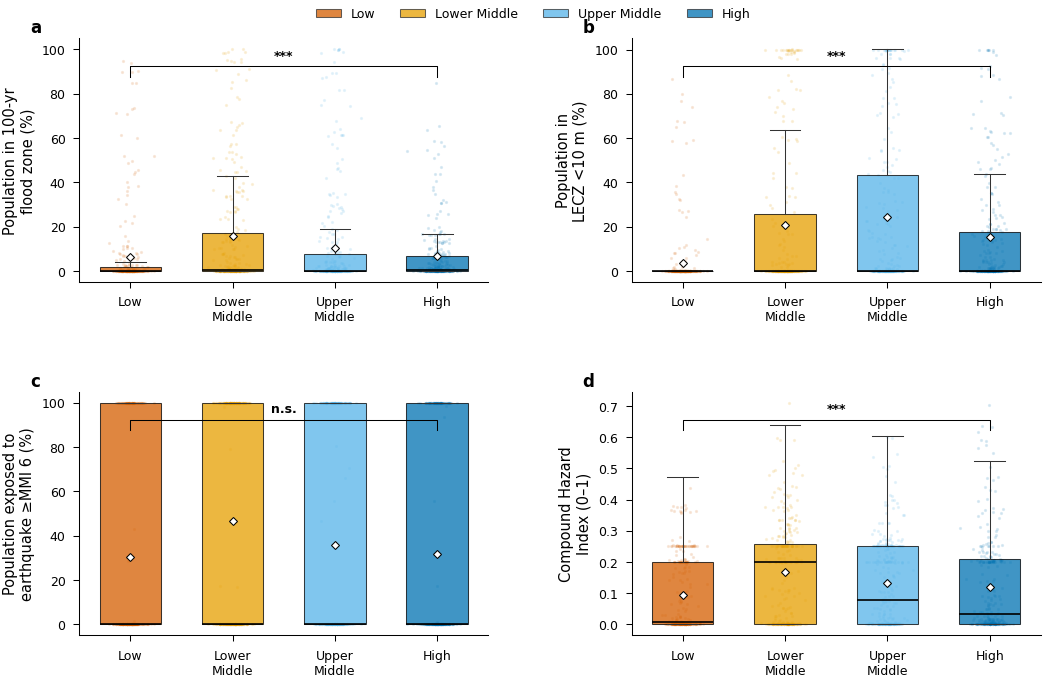


Generating Figure 2...
  Saved: figures/Figure2_LECZ_vs_HDI.pdf, figures/Figure2_LECZ_vs_HDI.png


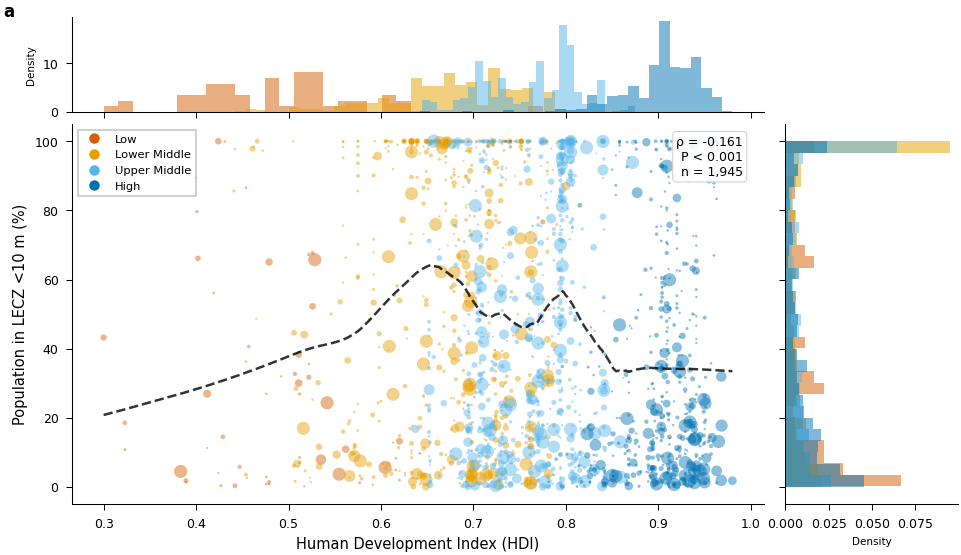


Generating Figure 3...
  Saved: figures/Figure3_hazard_HDI_heatmap.pdf, figures/Figure3_hazard_HDI_heatmap.png


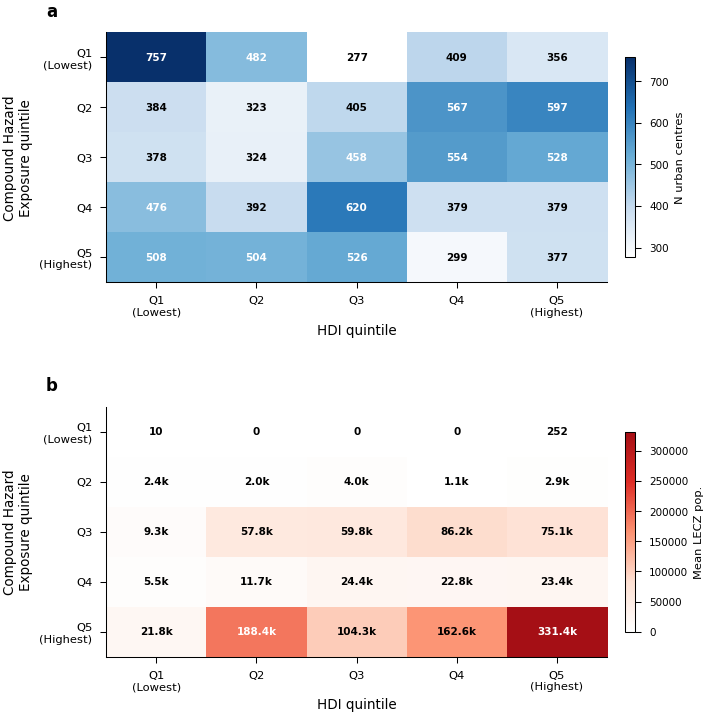


Generating Figure 4...
  Saved: figures/Figure4_demographics.pdf, figures/Figure4_demographics.png


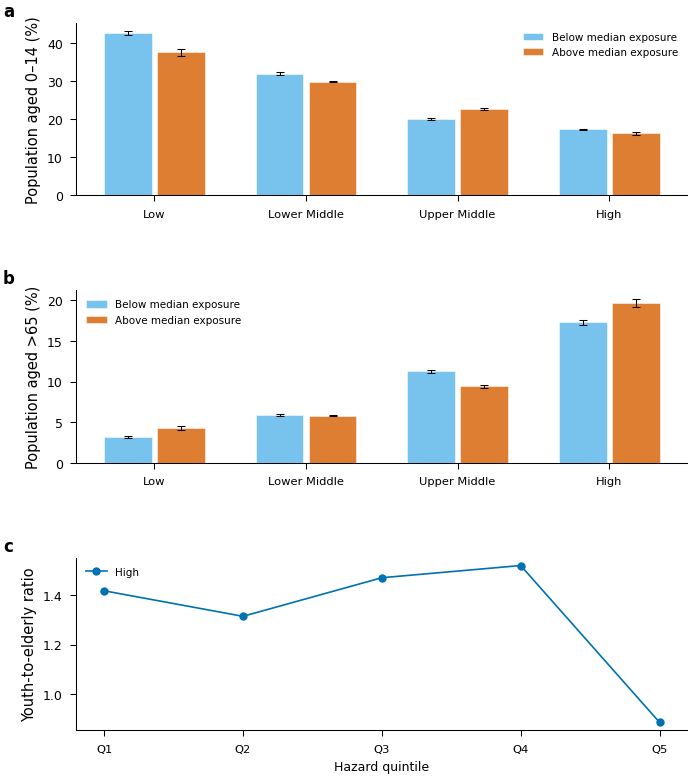


Generating Figure 5...
  Quantile regressions...
    τ=0.10 done
    τ=0.25 done
    τ=0.50 done
    τ=0.75 done
    τ=0.90 done
  Saved: figures/Figure5_quantile_regression.pdf, figures/Figure5_quantile_regression.png


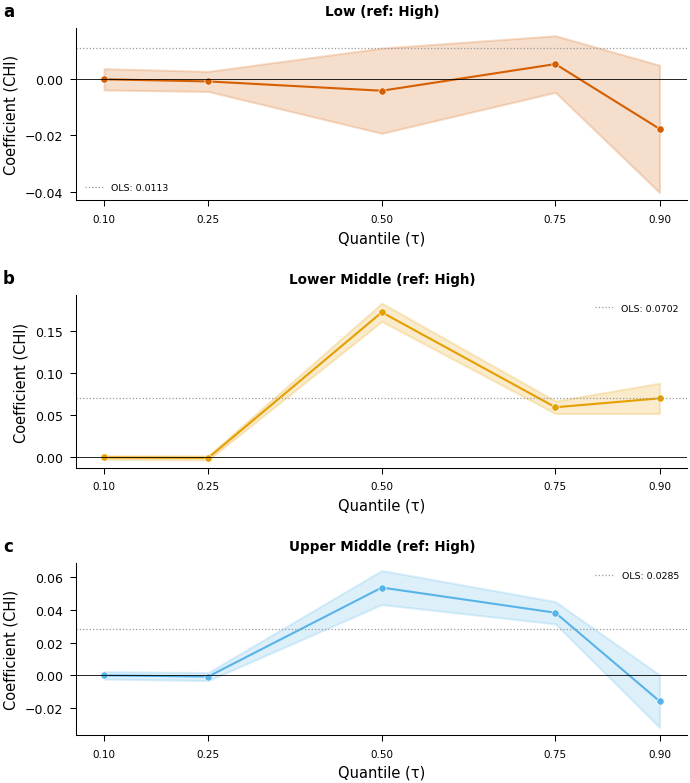


Running regressions...

REGRESSION RESULTS

                                                             (1) Bivariate (2) Controls (3) Region FE  (4) HDI  
----------------------------------------------------------------------------------------------------------------
Intercept                                                    0.1167***     0.3097***    0.3195***     0.3406*** 
                                                             (0.0037)      (0.0284)     (0.0316)      (0.0353)  
C(income_group, Treatment(reference="High"))[T.Low]          -0.0367***    0.0028       0.0008                  
                                                             (0.0051)      (0.0062)     (0.0080)                
C(income_group, Treatment(reference="High"))[T.Lower Middle] 0.0494***     0.0761***    -0.0001                 
                                                             (0.0044)      (0.0051)     (0.0069)                
C(income_group, Treatment(reference="High"))[T.Uppe

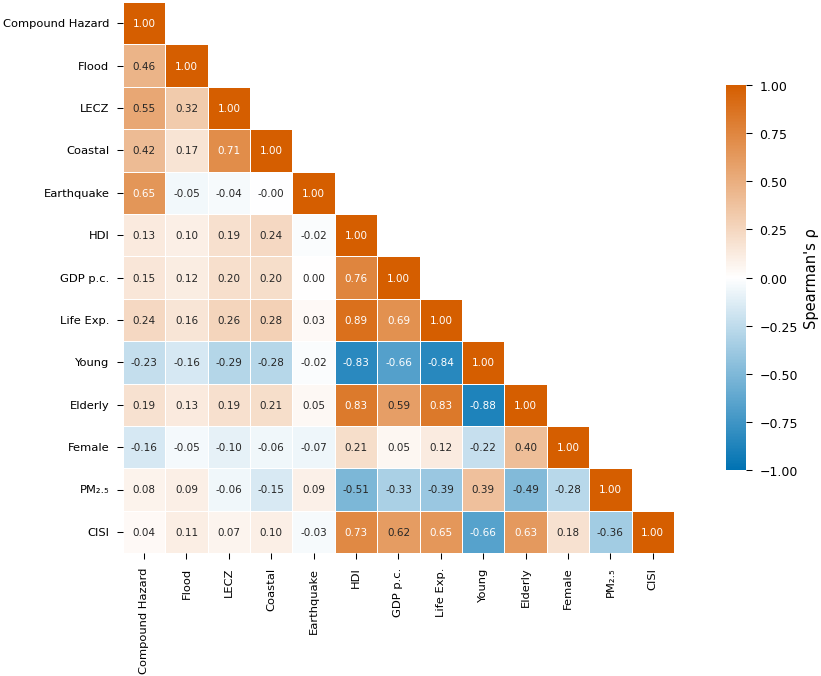


ANALYSIS COMPLETE

Outputs:
  figures/  Figure1–5 + ExtendedData_correlation_matrix (.pdf/.png)
  tables/   Table1, regression, regional, top50 (.csv/.xlsx)

Dataset: GHS-UCDB R2024A V1.1 (GeoPackage)
  doi: 10.2905/1a338be6-7eaf-480c-9664-3a8ade88cbcd



In [ ]:
#!/usr/bin/env python3
"""
===============================================================================
Climate Justice & Urban Inequality: Global Analysis of 11,422 Urban Centres
===============================================================================
Target: Nature Climate Change (Analysis)
Dataset: GHS-UCDB R2024A V1.1 — GeoPackage (.gpkg)
===============================================================================
"""

# =============================================================================
# CELL 1: ENVIRONMENT SETUP
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap, Normalize, BoundaryNorm
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu, spearmanr, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import OrderedDict
import os

try:
    import geopandas as gpd
except ImportError:
    os.system('pip install geopandas pyogrio --quiet')
    import geopandas as gpd

print("All packages loaded.")

# =============================================================================
# CELL 2: NATURE CLIMATE CHANGE STYLE
# =============================================================================

MM_TO_INCH = 1 / 25.4
NATURE_SINGLE_COL = 89 * MM_TO_INCH
NATURE_DOUBLE_COL = 183 * MM_TO_INCH
NATURE_MAX_HEIGHT = 247 * MM_TO_INCH
FIGURE_DPI = 300

WONG_PALETTE = {
    'black': '#000000', 'orange': '#E69F00', 'sky_blue': '#56B4E9',
    'green': '#009E73', 'yellow': '#F0E442', 'blue': '#0072B2',
    'vermilion': '#D55E00', 'purple': '#CC79A7',
}

INCOME_COLORS = OrderedDict([
    ('Low',          WONG_PALETTE['vermilion']),
    ('Lower Middle', WONG_PALETTE['orange']),
    ('Upper Middle', WONG_PALETTE['sky_blue']),
    ('High',         WONG_PALETTE['blue']),
])
INCOME_ORDER = ['Low', 'Lower Middle', 'Upper Middle', 'High']

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 7, 'axes.labelsize': 7, 'axes.titlesize': 8,
    'axes.linewidth': 0.5, 'axes.labelpad': 3,
    'axes.spines.top': False, 'axes.spines.right': False,
    'xtick.labelsize': 6, 'ytick.labelsize': 6,
    'xtick.major.size': 3, 'xtick.major.width': 0.5,
    'ytick.major.size': 3, 'ytick.major.width': 0.5,
    'xtick.direction': 'out', 'ytick.direction': 'out',
    'legend.fontsize': 6, 'legend.frameon': False,
    'lines.linewidth': 0.8, 'lines.markersize': 3,
    'figure.dpi': 150, 'savefig.dpi': FIGURE_DPI,
    'savefig.bbox': 'tight', 'savefig.pad_inches': 0.02,
    'grid.linewidth': 0.3, 'grid.alpha': 0.3,
})


def add_panel_label(ax, label, x=-0.12, y=1.08):
    ax.text(x, y, label, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='left')


def save_figure(fig, filename, formats=('pdf', 'png')):
    os.makedirs('figures', exist_ok=True)
    for fmt in formats:
        fig.savefig(f'figures/{filename}.{fmt}', format=fmt, dpi=FIGURE_DPI,
                    bbox_inches='tight', pad_inches=0.02,
                    facecolor='white', edgecolor='none')
    print(f"  Saved: {', '.join(f'figures/{filename}.{f}' for f in formats)}")


print("Nature style configured.")

# =============================================================================
# CELL 3: DATA LOADING (GeoPackage — multi-layer)
# =============================================================================

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/GHS_UCDB_GLOBE_R2024A.gpkg'  # UPDATE IF NEEDED

if not os.path.exists(DATA_PATH):
    import glob
    matches = glob.glob('/content/drive/MyDrive/**/*.gpkg', recursive=True)
    if matches:
        DATA_PATH = matches[0]
        print(f"Auto-detected: {DATA_PATH}")
    else:
        raise FileNotFoundError("No .gpkg found. Upload and update DATA_PATH.")

print(f"File: {DATA_PATH} ({os.path.getsize(DATA_PATH)/1e6:.1f} MB)")

LAYERS_TO_LOAD = {
    'gc':   'GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A',
    'sc':   'GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A',
    'ex':   'GHS_UCDB_THEME_EXPOSURE_GLOBE_R2024A',
    'em':   'GHS_UCDB_THEME_EMISSIONS_GLOBE_R2024A',
    'hl':   'GHS_UCDB_THEME_HEALTH_GLOBE_R2024A',
    'infr': 'GHS_UCDB_THEME_INFRASTRUCTURES_GLOBE_R2024A',
}


def strip_bom(text):
    if isinstance(text, str):
        return text.replace('\ufeff', '').strip()
    return text


def load_gpkg_layer(path, layer_name, keep_geometry=False):
    gdf_layer = gpd.read_file(path, layer=layer_name)
    gdf_layer.columns = [strip_bom(c) for c in gdf_layer.columns]
    for col in gdf_layer.select_dtypes(include=['object']).columns:
        if col != 'geometry':
            gdf_layer[col] = gdf_layer[col].apply(strip_bom)
    if not keep_geometry and 'geometry' in gdf_layer.columns:
        gdf_layer = pd.DataFrame(gdf_layer.drop(columns='geometry'))
    return gdf_layer


print("\nLoading layers...\n")
raw = {}
for key, layer_name in LAYERS_TO_LOAD.items():
    print(f"  {key:5s} → {layer_name}...", end=' ', flush=True)
    raw[key] = load_gpkg_layer(DATA_PATH, layer_name, keep_geometry=(key == 'gc'))
    print(f"({raw[key].shape[0]:,} × {raw[key].shape[1]:,})")

print(f"\nAll layers loaded. Urban centres: {raw['gc'].shape[0]:,}")

# =============================================================================
# CELL 4: DATA PREPARATION
# =============================================================================

ID_COL = 'ID_UC_G0'


def find_col(dataframe, pattern, exclude=None):
    for c in sorted(dataframe.columns, reverse=True):
        if pattern.upper() in c.upper():
            if exclude and any(ex.upper() in c.upper() for ex in exclude):
                continue
            return c
    return None


# --- General Characteristics ---
gc = raw['gc']
gc_cols = {
    'name': find_col(gc, 'GC_UCN_MAI'),
    'country_gadm': find_col(gc, 'GC_CNT_GAD'),
    'country_un': find_col(gc, 'GC_CNT_UNN'),
    'area_km2': find_col(gc, 'GC_UCA_KM2'),
    'population': find_col(gc, 'GC_POP_TOT'),
    'income_group': find_col(gc, 'GC_DEV_WIG'),
    'sdg_region': find_col(gc, 'GC_DEV_USR'),
}

gc_select = [ID_COL] + [v for v in gc_cols.values() if v]
gc_rename = {ID_COL: 'id'}
gc_rename.update({v: k for k, v in gc_cols.items() if v})
df = gc[gc_select + ['geometry']].copy().rename(columns=gc_rename)

# --- Socioeconomic ---
sc = raw['sc']
sc_map = {
    'hdi':           find_col(sc, 'SC_SEC_HDI', exclude=['GDF', 'GDM']),
    'gdp_avg':       find_col(sc, 'SC_GDP_AVG'),
    'gdp_total':     find_col(sc, 'SC_GDP_SUM'),
    'life_exp':      find_col(sc, 'SC_SEC_LET', exclude=['LEF', 'LEM']),
    'schooling_exp': find_col(sc, 'SC_SEC_SET', exclude=['SEF', 'SEM']),
    'pct_young':     find_col(sc, 'SC_SEC_PCY'),
    'pct_adult':     find_col(sc, 'SC_SEC_PCA'),
    'pct_old':       find_col(sc, 'SC_SEC_PCO'),
    'pct_female':    find_col(sc, 'SC_SEC_PCF'),
    'pct_male':      find_col(sc, 'SC_SEC_PCM'),
    'gdi':           find_col(sc, 'SC_SEC_GDI', exclude=['GDF', 'GDM']),
}
sc_r = {v: k for k, v in sc_map.items() if v}
df = df.merge(sc[[ID_COL]+list(sc_r.keys())].rename(columns={**sc_r, ID_COL:'id'}),
              on='id', how='left')
print(f"Socioeconomic: {len(sc_r)}/{len(sc_map)}")

# --- Exposure ---
ex = raw['ex']
ex_map = {
    'pop_flood_100yr':            find_col(ex, 'EX_100_POP'),
    'pop_flood_10yr':             find_col(ex, 'EX_010_POP'),
    'share_pop_flood_100yr':      find_col(ex, 'EX_100_SHP'),
    'share_pop_flood_10yr':       find_col(ex, 'EX_010_SHP'),
    'pop_lecz_5m':                find_col(ex, 'EX_L05_POP'),
    'pop_lecz_10m':               find_col(ex, 'EX_L10_POP'),
    'share_pop_lecz_5m':          find_col(ex, 'EX_L05_SHP'),
    'share_pop_lecz_10m':         find_col(ex, 'EX_L10_SHP'),
    'share_pop_lecz_below10m':    find_col(ex, 'EX_LEC_SHP'),
    'builtup_lecz_5m':            find_col(ex, 'EX_L05_BUS', exclude=['B1', 'B2']),
    'pop_coastal_100yr':          find_col(ex, 'EX_CF1_POP'),
    'pop_coastal_20yr':           find_col(ex, 'EX_CF2_POP'),
    'share_pop_coastal_100yr':    find_col(ex, 'EX_CF1_SHP'),
    'share_pop_coastal_20yr':     find_col(ex, 'EX_CF2_SHP'),
    'share_pop_earthquake_mmi6':  find_col(ex, 'EX_SHA_POP'),
    'pop_cyclone_100yr':          find_col(ex, 'EX_100_S1P'),
    'pop_cyclone_400yr_ss3':      find_col(ex, 'EX_400_S3P'),
}
ex_r = {v: k for k, v in ex_map.items() if v}
df = df.merge(ex[[ID_COL]+list(ex_r.keys())].rename(columns={**ex_r, ID_COL:'id'}),
              on='id', how='left')
print(f"Exposure: {len(ex_r)}/{len(ex_map)}")

# --- Emissions ---
em = raw['em']
em_map = {
    'pm25_deaths':    find_col(em, 'EM_PM2_MOR'),
    'pm25_conc':      find_col(em, 'EM_PM2_CON'),
    'co2_total':      find_col(em, 'EM_CO2_TOT'),
    'co2_per_capita': find_col(em, 'EM_CO2_PEC'),
}
em_r = {v: k for k, v in em_map.items() if v}
if em_r:
    df = df.merge(em[[ID_COL]+list(em_r.keys())].rename(columns={**em_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Emissions: {len(em_r)}/{len(em_map)}")

# --- Health ---
hl = raw['hl']
hl_map = {
    'hospitals_per_cap':       find_col(hl, 'HL_FPC_HOS'),
    'share_pop_near_hospital': find_col(hl, 'HL_SHP_HOS'),
}
hl_r = {v: k for k, v in hl_map.items() if v}
if hl_r:
    df = df.merge(hl[[ID_COL]+list(hl_r.keys())].rename(columns={**hl_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Health: {len(hl_r)}/{len(hl_map)}")

# --- Infrastructure ---
infr = raw['infr']
infr_map = {
    'cisi_all':    find_col(infr, 'IN_CIS_ALL'),
    'cisi_energy': find_col(infr, 'IN_CIS_ENE'),
}
infr_r = {v: k for k, v in infr_map.items() if v}
if infr_r:
    df = df.merge(infr[[ID_COL]+list(infr_r.keys())].rename(columns={**infr_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Infrastructure: {len(infr_r)}/{len(infr_map)}")

# --- Numeric conversion ---
skip = {'id', 'name', 'country_gadm', 'country_un', 'income_group', 'sdg_region', 'geometry'}
for col in df.columns:
    if col not in skip:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Standardise income groups (BOM already stripped from values) ---
income_map = {
    'Low': 'Low', 'Low Income': 'Low', 'Low income': 'Low',
    'Lower Middle': 'Lower Middle', 'Lower Middle Income': 'Lower Middle',
    'Lower middle income': 'Lower Middle', 'Lower-middle income': 'Lower Middle',
    'Upper Middle': 'Upper Middle', 'Upper Middle Income': 'Upper Middle',
    'Upper middle income': 'Upper Middle', 'Upper-middle income': 'Upper Middle',
    'High': 'High', 'High Income': 'High', 'High income': 'High',
}
df['income_group'] = df['income_group'].map(
    lambda x: income_map.get(str(x).strip(), str(x).strip()) if pd.notna(x) else np.nan
)

print(f"\nIncome groups after standardisation:")
print(df['income_group'].value_counts(dropna=False))

# --- Derived variables ---
df['pop_density'] = df['population'] / df['area_km2'].replace(0, np.nan)

if 'pop_cyclone_100yr' in df.columns:
    df['share_pop_cyclone_100yr'] = (
        df['pop_cyclone_100yr'] / df['population'].replace(0, np.nan) * 100)
else:
    df['share_pop_cyclone_100yr'] = np.nan

df['pop_lecz_total'] = df.get('pop_lecz_5m', pd.Series(0, index=df.index)).fillna(0) + \
                        df.get('pop_lecz_10m', pd.Series(0, index=df.index)).fillna(0)

# --- Compound Hazard Exposure Index ---
hazard_vars = ['share_pop_flood_100yr', 'share_pop_lecz_below10m',
               'share_pop_coastal_100yr', 'share_pop_earthquake_mmi6',
               'share_pop_cyclone_100yr']

available_hazards = [v for v in hazard_vars if v in df.columns and df[v].notna().sum() > 100]
print(f"\nCompound Hazard Index ({len(available_hazards)}/{len(hazard_vars)}):")

for var in available_hazards:
    vals = df[var]
    vmin, vmax = vals.min(), vals.max()
    if pd.notna(vmin) and pd.notna(vmax) and vmax > vmin:
        df[f'{var}_norm'] = (vals - vmin) / (vmax - vmin)
    else:
        df[f'{var}_norm'] = 0.0
    print(f"  ✓ {var} (n={vals.notna().sum():,})")

norm_cols = [f'{v}_norm' for v in available_hazards]
df['compound_hazard_index'] = df[norm_cols].mean(axis=1, skipna=True)

# --- Quintiles ---
try:
    df['hdi_quintile'] = pd.qcut(df['hdi'], q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'], duplicates='drop')
except:
    df['hdi_quintile'] = pd.qcut(df['hdi'].rank(method='first'), q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])
try:
    df['hazard_quintile'] = pd.qcut(df['compound_hazard_index'], q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'], duplicates='drop')
except:
    df['hazard_quintile'] = pd.qcut(df['compound_hazard_index'].rank(method='first'), q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])

# --- Final sample ---
df_valid = df[df['income_group'].isin(INCOME_ORDER)].copy()

print(f"\n{'='*60}")
print(f"FINAL ANALYTICAL SAMPLE: {df_valid.shape[0]:,} urban centres")
print(f"{'='*60}")
for grp in INCOME_ORDER:
    print(f"  {grp:20s} {(df_valid['income_group'] == grp).sum():>6,}")

print(f"\nKey variable coverage (% non-missing):")
for v in ['hdi', 'gdp_avg', 'share_pop_flood_100yr', 'share_pop_lecz_below10m',
           'share_pop_coastal_100yr', 'share_pop_earthquake_mmi6',
           'pct_young', 'pct_old', 'pm25_conc', 'cisi_all', 'compound_hazard_index']:
    if v in df_valid.columns:
        print(f"  {v:35s} {df_valid[v].notna().mean()*100:6.1f}%")

# =============================================================================
# CELL 5: TABLE 1
# =============================================================================

def create_table1(data, income_order):
    variables = OrderedDict([
        ('population',              ('Population',                          ',.0f')),
        ('area_km2',                ('Area (km²)',                          ',.1f')),
        ('pop_density',             ('Pop. density (per km²)',              ',.0f')),
        ('hdi',                     ('HDI',                                 '.3f')),
        ('gdp_avg',                 ('GDP per capita (PPP)',                ',.0f')),
        ('life_exp',                ('Life expectancy (yr)',                '.1f')),
        ('schooling_exp',           ('Expected schooling (yr)',             '.1f')),
        ('pct_young',               ('Pop. 0–14 (%)',                      '.1f')),
        ('pct_old',                 ('Pop. >65 (%)',                        '.1f')),
        ('pct_female',              ('Female pop. (%)',                     '.1f')),
        ('share_pop_flood_100yr',   ('Pop. 100-yr flood (%)',              '.1f')),
        ('share_pop_lecz_below10m', ('Pop. LECZ <10 m (%)',               '.1f')),
        ('share_pop_coastal_100yr', ('Pop. coastal flood (%)',             '.1f')),
        ('share_pop_earthquake_mmi6', ('Pop. earthquake ≥MMI 6 (%)',      '.1f')),
        ('share_pop_cyclone_100yr', ('Pop. cyclone (%)',                   '.1f')),
        ('compound_hazard_index',   ('Compound Hazard Index',              '.3f')),
        ('pm25_conc',               ('PM₂.₅ (µg/m³)',                     '.1f')),
        ('cisi_all',                ('CISI',                               '.3f')),
        ('share_pop_near_hospital', ('Pop. near hospital (%)',             '.1f')),
    ])
    variables = OrderedDict((k, v) for k, v in variables.items() if k in data.columns)

    rows = [{'Variable': 'N (urban centres)',
             **{g: f"{(data['income_group']==g).sum():,}" for g in income_order},
             'All': f"{data.shape[0]:,}", 'p-value': ''}]

    for var_name, (label, fmt) in variables.items():
        row = {'Variable': label}
        gvals = []
        for grp in income_order:
            gd = data.loc[data['income_group'] == grp, var_name].dropna()
            gvals.append(gd)
            if len(gd) > 0:
                m, q1, q3 = gd.median(), gd.quantile(0.25), gd.quantile(0.75)
                row[grp] = f"{m:{fmt}} ({q1:{fmt}}–{q3:{fmt}})"
            else:
                row[grp] = '—'
        ad = data[var_name].dropna()
        if len(ad) > 0:
            m, q1, q3 = ad.median(), ad.quantile(0.25), ad.quantile(0.75)
            row['All'] = f"{m:{fmt}} ({q1:{fmt}}–{q3:{fmt}})"
        else:
            row['All'] = '—'
        vg = [g for g in gvals if len(g) >= 5]
        if len(vg) >= 2:
            try:
                _, p = kruskal(*vg)
                row['p-value'] = '<0.001' if p < 0.001 else f"{p:.3f}"
            except:
                row['p-value'] = '—'
        else:
            row['p-value'] = '—'
        rows.append(row)

    return pd.DataFrame(rows)[['Variable'] + income_order + ['All', 'p-value']]


table1 = create_table1(df_valid, INCOME_ORDER)
print("\n" + "="*100)
print("TABLE 1: Descriptive statistics by World Bank income group")
print("="*100)
print(table1.to_string(index=False))
os.makedirs('tables', exist_ok=True)
table1.to_csv('tables/Table1_descriptive_stats.csv', index=False)
table1.to_excel('tables/Table1_descriptive_stats.xlsx', index=False)
print("  Saved: tables/Table1_descriptive_stats.csv/.xlsx")

# =============================================================================
# CELL 6: FIGURE 1 — MULTI-HAZARD EXPOSURE
# =============================================================================

def figure1_multihazard(data, income_order, income_colors):
    fig = plt.figure(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.65))
    gs = gridspec.GridSpec(2, 2, hspace=0.45, wspace=0.35,
                           left=0.08, right=0.97, top=0.93, bottom=0.08)
    panels = {
        'a': ('share_pop_flood_100yr', 'Population in 100-yr\nflood zone (%)'),
        'b': ('share_pop_lecz_below10m', 'Population in\nLECZ <10 m (%)'),
        'c': ('share_pop_earthquake_mmi6', 'Population exposed to\nearthquake ≥MMI 6 (%)'),
        'd': ('compound_hazard_index', 'Compound Hazard\nIndex (0–1)'),
    }
    for idx, (label, (var, ylabel)) in enumerate(panels.items()):
        ax = fig.add_subplot(gs[idx // 2, idx % 2])
        if var not in data.columns or data[var].notna().sum() < 10:
            ax.text(0.5, 0.5, f'{var}\nnot available', transform=ax.transAxes,
                   ha='center', va='center', fontsize=6, color='grey')
            add_panel_label(ax, label); continue

        plot_data = [data.loc[data['income_group'] == g, var].dropna() for g in income_order]
        bp = ax.boxplot(plot_data, positions=range(len(income_order)), widths=0.6,
            patch_artist=True, showfliers=False, showmeans=True,
            meanprops=dict(marker='D', markerfacecolor='white',
                          markeredgecolor='black', markersize=2.5, markeredgewidth=0.5),
            medianprops=dict(color='black', linewidth=0.8),
            whiskerprops=dict(linewidth=0.5, color='#333333'),
            capprops=dict(linewidth=0.5, color='#333333'),
            boxprops=dict(linewidth=0.5))

        for patch, grp in zip(bp['boxes'], income_order):
            patch.set_facecolor(income_colors[grp]); patch.set_alpha(0.75)

        rng = np.random.default_rng(42)
        for i, grp in enumerate(income_order):
            vals = data.loc[data['income_group'] == grp, var].dropna()
            n_plot = min(300, len(vals))
            if n_plot > 0:
                vs = vals.sample(n=n_plot, random_state=42) if len(vals) > n_plot else vals
                ax.scatter(i + rng.normal(0, 0.08, len(vs)), vs, s=0.3, alpha=0.15,
                          color=income_colors[grp], zorder=1, rasterized=True)

        ax.set_xticks(range(len(income_order)))
        short_labels = ['Low', 'Lower\nMiddle', 'Upper\nMiddle', 'High']
        ax.set_xticklabels(short_labels, rotation=0, ha='center')
        ax.set_ylabel(ylabel)

        gl = data.loc[data['income_group'] == 'Low', var].dropna()
        gh = data.loc[data['income_group'] == 'High', var].dropna()
        if len(gl) > 5 and len(gh) > 5:
            _, pv = mannwhitneyu(gl, gh, alternative='two-sided')
            sig = '***' if pv < 0.001 else ('**' if pv < 0.01 else ('*' if pv < 0.05 else 'n.s.'))
            yb = ax.get_ylim()[1] * 0.88
            ax.plot([0, 0, 3, 3], [yb*0.95, yb, yb, yb*0.95], lw=0.5, color='black')
            ax.text(1.5, yb * 1.02, sig, ha='center', va='bottom', fontsize=6, fontweight='bold')
        add_panel_label(ax, label)

    legend_el = [mpatches.Patch(facecolor=income_colors[g], alpha=0.75,
                 edgecolor='#333333', linewidth=0.5, label=g) for g in income_order]
    fig.legend(handles=legend_el, loc='upper center', ncol=4, fontsize=6,
              frameon=False, bbox_to_anchor=(0.5, 0.99))
    save_figure(fig, 'Figure1_multihazard_exposure')
    plt.show()
    return fig

print("\nGenerating Figure 1...")
fig1 = figure1_multihazard(df_valid, INCOME_ORDER, INCOME_COLORS)

# =============================================================================
# CELL 7: FIGURE 2 — LECZ vs HDI
# =============================================================================

def figure2_lecz_hdi(data, income_colors):
    mask = (data['share_pop_lecz_below10m'].notna() &
            (data['share_pop_lecz_below10m'] > 0) & data['hdi'].notna())
    pdf = data[mask].copy()
    if len(pdf) < 50:
        print("  Warning: Too few cities for Figure 2"); return None

    fig = plt.figure(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.55))
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           hspace=0.05, wspace=0.05,
                           left=0.1, right=0.92, top=0.92, bottom=0.1)
    ax_m = fig.add_subplot(gs[1, 0])
    ax_t = fig.add_subplot(gs[0, 0], sharex=ax_m)
    ax_r = fig.add_subplot(gs[1, 1], sharey=ax_m)

    for grp in INCOME_ORDER:
        gd = pdf[pdf['income_group'] == grp]
        if len(gd) == 0: continue
        sizes = np.clip(gd['population'] / 50000, 1, 40)
        ax_m.scatter(gd['hdi'], gd['share_pop_lecz_below10m'], s=sizes, alpha=0.45,
                    color=income_colors[grp], label=grp, edgecolors='none', rasterized=True)

    valid = pdf[['hdi', 'share_pop_lecz_below10m']].dropna()
    if len(valid) > 50:
        sm_out = lowess(valid['share_pop_lecz_below10m'], valid['hdi'], frac=0.3, return_sorted=True)
        ax_m.plot(sm_out[:, 0], sm_out[:, 1], color='black', lw=1.2, ls='--', zorder=5, alpha=0.8)

    ax_m.set_xlabel('Human Development Index (HDI)')
    ax_m.set_ylabel('Population in LECZ <10 m (%)')
    rho, pr = spearmanr(valid['hdi'], valid['share_pop_lecz_below10m'])
    pt = 'P < 0.001' if pr < 0.001 else f'P = {pr:.3f}'
    ax_m.text(0.97, 0.97, f'ρ = {rho:.3f}\n{pt}\nn = {len(valid):,}',
             transform=ax_m.transAxes, fontsize=6, va='top', ha='right',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                      edgecolor='#ccc', alpha=0.9, linewidth=0.5))

    for grp in INCOME_ORDER:
        v = pdf.loc[pdf['income_group'] == grp, 'hdi'].dropna()
        if len(v) > 5: ax_t.hist(v, bins=30, alpha=0.5, color=income_colors[grp], density=True, edgecolor='none')
    ax_t.set_ylabel('Density', fontsize=5); ax_t.tick_params(labelbottom=False)

    for grp in INCOME_ORDER:
        v = pdf.loc[pdf['income_group'] == grp, 'share_pop_lecz_below10m'].dropna()
        if len(v) > 5: ax_r.hist(v, bins=30, alpha=0.5, color=income_colors[grp], density=True, orientation='horizontal', edgecolor='none')
    ax_r.set_xlabel('Density', fontsize=5); ax_r.tick_params(labelleft=False)

    leg = [Line2D([0], [0], marker='o', color='w', markerfacecolor=income_colors[g],
                  markersize=5, label=g, markeredgewidth=0) for g in INCOME_ORDER]
    ax_m.legend(handles=leg, loc='upper left', fontsize=5.5, frameon=True,
               fancybox=False, edgecolor='#ccc', framealpha=0.9)
    add_panel_label(ax_t, 'a', x=-0.1, y=1.15)
    save_figure(fig, 'Figure2_LECZ_vs_HDI')
    plt.show()
    return fig

print("\nGenerating Figure 2...")
fig2 = figure2_lecz_hdi(df_valid, INCOME_COLORS)

# =============================================================================
# CELL 8: FIGURE 3 — HAZARD × HDI HEATMAP
# =============================================================================

def figure3_heatmap(data):
    mask = data['hdi_quintile'].notna() & data['hazard_quintile'].notna()
    sub = data[mask].copy()
    if len(sub) < 100:
        print("  Warning: Too few for Figure 3"); return None

    ct_n = pd.crosstab(sub['hazard_quintile'], sub['hdi_quintile'])
    ct_p = sub.groupby(['hazard_quintile', 'hdi_quintile'])['pop_lecz_total'].mean().unstack(fill_value=0)
    ct_p = ct_p.reindex(index=ct_n.index, columns=ct_n.columns, fill_value=0)

    fig, axes = plt.subplots(2, 1, figsize=(NATURE_SINGLE_COL * 1.5, NATURE_DOUBLE_COL * 0.75),
                              gridspec_kw={'hspace': 0.5})

    cmap_a = LinearSegmentedColormap.from_list('c', ['#FFF', '#C6DBEF', '#6BAED6', '#2171B5', '#08306B'])
    im = axes[0].imshow(ct_n.values, cmap=cmap_a, aspect='auto')
    for i in range(ct_n.shape[0]):
        for j in range(ct_n.shape[1]):
            v = ct_n.values[i, j]
            axes[0].text(j, i, f'{v:,}', ha='center', va='center', fontsize=5,
                        color='white' if v > ct_n.values.max()*0.6 else 'black', fontweight='bold')
    axes[0].set_xticks(range(ct_n.shape[1])); axes[0].set_xticklabels(ct_n.columns, fontsize=5.5)
    axes[0].set_yticks(range(ct_n.shape[0])); axes[0].set_yticklabels(ct_n.index, fontsize=5.5)
    axes[0].set_xlabel('HDI quintile', fontsize=6.5)
    axes[0].set_ylabel('Compound Hazard\nExposure quintile', fontsize=6.5)
    cb = fig.colorbar(im, ax=axes[0], shrink=0.8, pad=0.03)
    cb.ax.tick_params(labelsize=5); cb.set_label('N urban centres', fontsize=5.5)
    add_panel_label(axes[0], 'a', x=-0.12, y=1.12)

    cmap_b = LinearSegmentedColormap.from_list('p', ['#FFF', '#FEE0D2', '#FC9272', '#DE2D26', '#A50F15'])
    im2 = axes[1].imshow(ct_p.values, cmap=cmap_b, aspect='auto')
    for i in range(ct_p.shape[0]):
        for j in range(ct_p.shape[1]):
            v = ct_p.values[i, j]
            lb = f'{v/1000:.1f}k' if v >= 1000 else f'{v:.0f}'
            axes[1].text(j, i, lb, ha='center', va='center', fontsize=5,
                        color='white' if v > ct_p.values.max()*0.5 else 'black', fontweight='bold')
    axes[1].set_xticks(range(ct_p.shape[1])); axes[1].set_xticklabels(ct_p.columns, fontsize=5.5)
    axes[1].set_yticks(range(ct_p.shape[0])); axes[1].set_yticklabels(ct_p.index, fontsize=5.5)
    axes[1].set_xlabel('HDI quintile', fontsize=6.5)
    axes[1].set_ylabel('Compound Hazard\nExposure quintile', fontsize=6.5)
    cb2 = fig.colorbar(im2, ax=axes[1], shrink=0.8, pad=0.03)
    cb2.ax.tick_params(labelsize=5); cb2.set_label('Mean LECZ pop.', fontsize=5.5)
    add_panel_label(axes[1], 'b', x=-0.12, y=1.12)

    plt.tight_layout(h_pad=2)
    save_figure(fig, 'Figure3_hazard_HDI_heatmap')
    plt.show()
    return fig

print("\nGenerating Figure 3...")
fig3 = figure3_heatmap(df_valid)

# =============================================================================
# CELL 9: FIGURE 4 — DEMOGRAPHICS  [UPDATED: vertical 3×1 layout]
# =============================================================================

def figure4_demographics(data, income_order, income_colors):
    med_haz = data['compound_hazard_index'].median()
    data = data.copy()
    data['high_exp'] = data['compound_hazard_index'] >= med_haz

    # --- LAYOUT CHANGED: 3 rows × 1 column (a: top, b: middle, c: bottom) ---
    fig, axes = plt.subplots(3, 1,
                              figsize=(NATURE_SINGLE_COL * 1.5, NATURE_DOUBLE_COL * 0.85),
                              gridspec_kw={'hspace': 0.55})
    bw = 0.35
    x = np.arange(len(income_order))

    # --- Panels a & b: grouped bar charts ---
    for ai, (ax, var, yl) in enumerate(zip(
        axes[:2], ['pct_young', 'pct_old'],
        ['Population aged 0–14 (%)', 'Population aged >65 (%)']
    )):
        if var not in data.columns:
            ax.text(0.5, 0.5, 'N/A', transform=ax.transAxes, ha='center', fontsize=6)
            add_panel_label(ax, chr(97+ai)); continue
        for i, (el, ev) in enumerate([('Below median exposure', False),
                                       ('Above median exposure', True)]):
            means, cis = [], []
            for grp in income_order:
                v = data.loc[(data['income_group']==grp) & (data['high_exp']==ev), var].dropna()
                means.append(v.mean() if len(v) > 0 else 0)
                cis.append(1.96 * v.std()/np.sqrt(len(v)) if len(v) > 1 else 0)
            off = -bw/2 + i*bw
            col = WONG_PALETTE['sky_blue'] if not ev else WONG_PALETTE['vermilion']
            ax.bar(x+off, means, bw*0.9, yerr=cis, label=el, color=col, alpha=0.8,
                   edgecolor='white', linewidth=0.3,
                   error_kw=dict(lw=0.5, capsize=2, capthick=0.5))
        short_labels = ['Low', 'Lower Middle', 'Upper Middle', 'High']
        ax.set_xticks(x); ax.set_xticklabels(short_labels, fontsize=5.5)
        ax.set_ylabel(yl)
        ax.legend(fontsize=5, loc='upper right' if ai == 0 else 'upper left')
        add_panel_label(ax, chr(97+ai), x=-0.12, y=1.12)

    # --- Panel c: youth-to-elderly ratio across hazard quintiles ---
    ax = axes[2]
    if 'pct_young' in data.columns and 'pct_old' in data.columns:
        data['yer'] = data['pct_young'] / data['pct_old'].replace(0, np.nan)
        for grp in income_order:
            gd = data[data['income_group'] == grp].copy()
            try:
                gd['hq'] = pd.qcut(gd['compound_hazard_index'], q=5,
                                    labels=[1,2,3,4,5], duplicates='drop')
                m = gd.groupby('hq')['yer'].mean()
                ax.plot(m.index.astype(int), m.values, marker='o', markersize=3,
                       lw=0.8, color=income_colors[grp], label=grp)
            except:
                continue
        ax.set_xlabel('Hazard quintile', fontsize=6)
        ax.set_ylabel('Youth-to-elderly ratio')
        ax.set_xticks([1,2,3,4,5])
        ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], fontsize=5.5)
        ax.legend(fontsize=5, loc='upper left')
    add_panel_label(ax, 'c', x=-0.12, y=1.12)

    plt.tight_layout(h_pad=2.0)
    save_figure(fig, 'Figure4_demographics')
    plt.show()
    return fig

print("\nGenerating Figure 4...")
fig4 = figure4_demographics(df_valid, INCOME_ORDER, INCOME_COLORS)

# =============================================================================
# CELL 10: FIGURE 5 — QUANTILE REGRESSION  [UPDATED: vertical 3×1 layout]
# =============================================================================

def figure5_quantile_regression(data, income_order):
    rd = data[['compound_hazard_index', 'income_group', 'area_km2', 'population']].dropna().copy()
    if len(rd) < 100:
        print("  Too few obs"); return None, {}

    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])
    rd = pd.get_dummies(rd, columns=['income_group'], drop_first=False, dtype=float)

    dummies = [f'income_group_{g}' for g in income_order if g != 'High'
               and f'income_group_{g}' in rd.columns]
    if not dummies:
        print("  No income dummies"); return None, {}

    X = sm.add_constant(rd[dummies + ['log_pop', 'log_area']].astype(float))
    y = rd['compound_hazard_index'].astype(float)

    quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
    results = {q: {} for q in quantiles}
    print("  Quantile regressions...")
    for q in quantiles:
        try:
            res = QuantReg(y, X).fit(q=q, max_iter=5000)
            for d in dummies:
                gl = d.replace('income_group_', '')
                results[q][gl] = {'coef': res.params[d],
                    'ci_low': res.conf_int().loc[d, 0],
                    'ci_high': res.conf_int().loc[d, 1]}
            print(f"    τ={q:.2f} done")
        except Exception as e:
            print(f"    τ={q:.2f} failed: {e}")

    ols = sm.OLS(y, X).fit(cov_type='HC3')

    grps = [g for g in ['Low', 'Lower Middle', 'Upper Middle']
            if f'income_group_{g}' in rd.columns]

    # --- LAYOUT CHANGED: 3 rows × 1 column (a: top, b: middle, c: bottom) ---
    fig, axes = plt.subplots(len(grps), 1,
                              figsize=(NATURE_SINGLE_COL * 1.5, NATURE_DOUBLE_COL * 0.85),
                              gridspec_kw={'hspace': 0.55})
    if len(grps) == 1: axes = [axes]

    for idx, grp in enumerate(grps):
        ax = axes[idx]
        col = INCOME_COLORS.get(grp, '#333')
        coefs = [results[q].get(grp, {}).get('coef', np.nan) for q in quantiles]
        cil = [results[q].get(grp, {}).get('ci_low', np.nan) for q in quantiles]
        cih = [results[q].get(grp, {}).get('ci_high', np.nan) for q in quantiles]
        ax.fill_between(quantiles, cil, cih, alpha=0.2, color=col)
        ax.plot(quantiles, coefs, 'o-', color=col, markersize=3.5, lw=1,
               markeredgecolor='white', markeredgewidth=0.3)
        dn = f'income_group_{grp}'
        if dn in ols.params.index:
            ax.axhline(ols.params[dn], color='#999', ls=':', lw=0.6,
                      label=f'OLS: {ols.params[dn]:.4f}')
        ax.axhline(0, color='black', lw=0.4)
        ax.set_xlabel('Quantile (τ)')
        ax.set_ylabel('Coefficient (CHI)')
        ax.set_title(f'{grp} (ref: High)', fontsize=6.5, fontweight='bold')
        ax.set_xticks(quantiles)
        ax.set_xticklabels([f'{q:.2f}' for q in quantiles], fontsize=5)
        ax.legend(fontsize=4.5, loc='best')
        add_panel_label(ax, chr(97+idx), x=-0.12, y=1.15)

    plt.tight_layout(h_pad=2.0)
    save_figure(fig, 'Figure5_quantile_regression')
    plt.show()
    return fig, results

print("\nGenerating Figure 5...")
fig5, qreg = figure5_quantile_regression(df_valid, INCOME_ORDER)

# =============================================================================
# CELL 11: REGRESSION TABLE
# =============================================================================

def run_regressions(data):
    rd = data[['compound_hazard_index', 'income_group', 'sdg_region',
               'area_km2', 'population', 'hdi']].dropna().copy()
    if len(rd) < 100:
        print("  Too few obs"); return {}
    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])

    m1 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))',
                  data=rd).fit(cov_type='HC3')
    m2 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area', data=rd).fit(cov_type='HC3')
    m3 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area + C(sdg_region)', data=rd).fit(cov_type='HC3')
    m4 = smf.ols('compound_hazard_index ~ hdi + log_pop + log_area',
                  data=rd).fit(cov_type='HC3')

    print("\n" + "="*80)
    print("REGRESSION RESULTS")
    print("="*80)
    from statsmodels.iolib.summary2 import summary_col
    s = summary_col([m1, m2, m3, m4],
        model_names=['(1) Bivariate', '(2) Controls', '(3) Region FE', '(4) HDI'],
        stars=True, info_dict={
            'N': lambda x: f"{int(x.nobs):,}",
            'R²': lambda x: f"{x.rsquared:.4f}",
            'Adj. R²': lambda x: f"{x.rsquared_adj:.4f}"})
    print(s)
    s.tables[0].to_csv('tables/regression_results.csv')
    print("  Saved: tables/regression_results.csv")
    return {'m1': m1, 'm2': m2, 'm3': m3, 'm4': m4}

print("\nRunning regressions...")
reg_models = run_regressions(df_valid)

# =============================================================================
# CELL 12: EXTENDED DATA — REGIONAL
# =============================================================================

def extended_regional(data):
    regions = sorted(data['sdg_region'].dropna().unique())
    vm = {'compound_hazard_index': 'CHI', 'share_pop_flood_100yr': 'Flood',
          'share_pop_lecz_below10m': 'LECZ', 'hdi': 'HDI',
          'pct_young': 'Young', 'pct_old': 'Old'}
    vm = {k: v for k, v in vm.items() if k in data.columns}
    rows = []
    for r in regions:
        rd = data[data['sdg_region'] == r]
        row = {'Region': r, 'N': rd.shape[0]}
        for var, lbl in vm.items():
            v = rd[var].dropna()
            if len(v) > 0:
                row[f'{lbl} med'] = f"{v.median():.3f}"
                row[f'{lbl} IQR'] = f"{v.quantile(0.25):.3f}–{v.quantile(0.75):.3f}"
            else:
                row[f'{lbl} med'] = '—'; row[f'{lbl} IQR'] = '—'
        rows.append(row)
    ed = pd.DataFrame(rows)
    ed.to_csv('tables/ExtendedData_regional.csv', index=False)
    ed.to_excel('tables/ExtendedData_regional.xlsx', index=False)
    print("  Saved: tables/ExtendedData_regional.csv/.xlsx")
    return ed

print("\nExtended Data: Regional...")
ed_reg = extended_regional(df_valid)
print(ed_reg[['Region', 'N']].to_string(index=False))

# =============================================================================
# CELL 13: TOP 50 EXPOSED LOW-INCOME CITIES
# =============================================================================

def top50_exposed(data):
    low = data[data['income_group'].isin(['Low', 'Lower Middle'])]
    top = low.nlargest(50, 'compound_hazard_index')
    cols = ['name', 'country_gadm', 'income_group', 'population', 'hdi',
            'compound_hazard_index', 'share_pop_flood_100yr',
            'share_pop_lecz_below10m', 'share_pop_earthquake_mmi6', 'pct_young', 'pct_old']
    avail = [c for c in cols if c in top.columns]
    result = top[avail].reset_index(drop=True)
    result.index = result.index + 1; result.index.name = 'Rank'
    result.to_csv('tables/ExtendedData_top50.csv')
    result.to_excel('tables/ExtendedData_top50.xlsx')
    print("  Saved: tables/ExtendedData_top50.csv/.xlsx")
    return result

print("\nTop 50 exposed low-income cities...")
top50 = top50_exposed(df_valid)
print(top50.head(10).to_string())

# =============================================================================
# CELL 14: ROBUSTNESS CHECKS
# =============================================================================

def robustness_checks(data, income_order):
    print("\n" + "="*80)
    print("ROBUSTNESS CHECKS")
    print("="*80)

    # 1. Pop threshold
    print("\n--- Check 1: Pop ≥ 50,000 ---")
    sub = data[data['population'] >= 50000]
    print(f"  N = {sub.shape[0]:,}")
    for g in income_order:
        v = sub.loc[sub['income_group']==g, 'compound_hazard_index'].dropna()
        if len(v) > 0: print(f"  {g}: median CHI = {v.median():.4f}")
    vg = [sub.loc[sub['income_group']==g, 'compound_hazard_index'].dropna() for g in income_order]
    vg = [g for g in vg if len(g) >= 5]
    if len(vg) >= 2:
        h, p = kruskal(*vg); print(f"  KW: H={h:.2f}, p={p:.2e}")

    # 2. GDP quintiles
    print("\n--- Check 2: GDP quintiles ---")
    if 'gdp_avg' in data.columns:
        sub = data[data['gdp_avg'].notna()].copy()
        try:
            sub['gq'] = pd.qcut(sub['gdp_avg'], q=5, labels=['Q1','Q2','Q3','Q4','Q5'], duplicates='drop')
            for q in sub['gq'].cat.categories:
                v = sub.loc[sub['gq']==q, 'compound_hazard_index'].dropna()
                print(f"  {q}: median CHI = {v.median():.4f}, n={len(v):,}")
        except Exception as e: print(f"  Skipped: {e}")

    # 3. LECZ 5m
    print("\n--- Check 3: LECZ 5m ---")
    if 'share_pop_lecz_5m' in data.columns:
        for g in income_order:
            v = data.loc[data['income_group']==g, 'share_pop_lecz_5m'].dropna()
            if len(v) > 0: print(f"  {g}: median = {v.median():.2f}%")

    # 4. Geometric mean
    print("\n--- Check 4: Geometric mean ---")
    nc = [c for c in data.columns if c.endswith('_norm')]
    if nc:
        eps = 1e-6
        dc = data.copy()
        dc['chi_geo'] = np.exp(dc[nc].apply(lambda x: np.log(x + eps)).mean(axis=1))
        vp = dc[['compound_hazard_index', 'chi_geo']].dropna()
        if len(vp) > 50:
            rho, p = spearmanr(vp['compound_hazard_index'], vp['chi_geo'])
            print(f"  Spearman ρ = {rho:.4f}, p = {p:.2e}")

robustness_checks(df_valid, INCOME_ORDER)

# =============================================================================
# CELL 15: CORRELATION MATRIX
# =============================================================================

def extended_correlation(data):
    cv = {'compound_hazard_index': 'Compound Hazard',
          'share_pop_flood_100yr': 'Flood', 'share_pop_lecz_below10m': 'LECZ',
          'share_pop_coastal_100yr': 'Coastal', 'share_pop_earthquake_mmi6': 'Earthquake',
          'hdi': 'HDI', 'gdp_avg': 'GDP p.c.', 'life_exp': 'Life Exp.',
          'pct_young': 'Young', 'pct_old': 'Elderly', 'pct_female': 'Female',
          'pm25_conc': 'PM₂.₅', 'cisi_all': 'CISI'}
    av = {k: v for k, v in cv.items() if k in data.columns}
    sub = data[list(av.keys())].dropna()
    if len(sub) < 50:
        print("  Too few obs for correlation"); return None

    corr = sub.corr(method='spearman')
    corr.index = [av[c] for c in corr.index]
    corr.columns = [av[c] for c in corr.columns]

    fig, ax = plt.subplots(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.65))
    cmap = LinearSegmentedColormap.from_list('d',
        [WONG_PALETTE['blue'], '#FFFFFF', WONG_PALETTE['vermilion']], N=256)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.3, linecolor='white',
                annot=True, fmt='.2f', annot_kws={'size': 5},
                cbar_kws={'shrink': 0.7, 'label': "Spearman's ρ"}, ax=ax)
    ax.tick_params(labelsize=5.5)
    plt.tight_layout()
    save_figure(fig, 'ExtendedData_correlation_matrix')
    plt.show()
    return fig

print("\nCorrelation matrix...")
fig_corr = extended_correlation(df_valid)

# =============================================================================
# CELL 16: SUMMARY
# =============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"""
Outputs:
  figures/  Figure1–5 + ExtendedData_correlation_matrix (.pdf/.png)
  tables/   Table1, regression, regional, top50 (.csv/.xlsx)

Dataset: GHS-UCDB R2024A V1.1 (GeoPackage)
  doi: 10.2905/1a338be6-7eaf-480c-9664-3a8ade88cbcd
""")

All packages loaded.
Nature style configured.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File: /content/drive/MyDrive/GHS_UCDB_GLOBE_R2024A.gpkg (283.2 MB)

Loading layers...

  gc    → GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A... (11,422 × 14)
  sc    → GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A... (11,422 × 183)
  ex    → GHS_UCDB_THEME_EXPOSURE_GLOBE_R2024A... (11,422 × 1,066)
  em    → GHS_UCDB_THEME_EMISSIONS_GLOBE_R2024A... (11,422 × 458)
  hl    → GHS_UCDB_THEME_HEALTH_GLOBE_R2024A... (11,422 × 17)
  infr  → GHS_UCDB_THEME_INFRASTRUCTURES_GLOBE_R2024A... (11,422 × 17)

All layers loaded. Urban centres: 11,422
Socioeconomic: 11/11
Exposure: 17/17
Emissions: 4/4
Health: 2/2
Infrastructure: 2/2

Income groups after standardisation:
income_group
Lower Middle    4591
Upper Middle    4179
High            1593
Low             1050
NaN                9
Name: count, dtype: int64

Compound Hazar

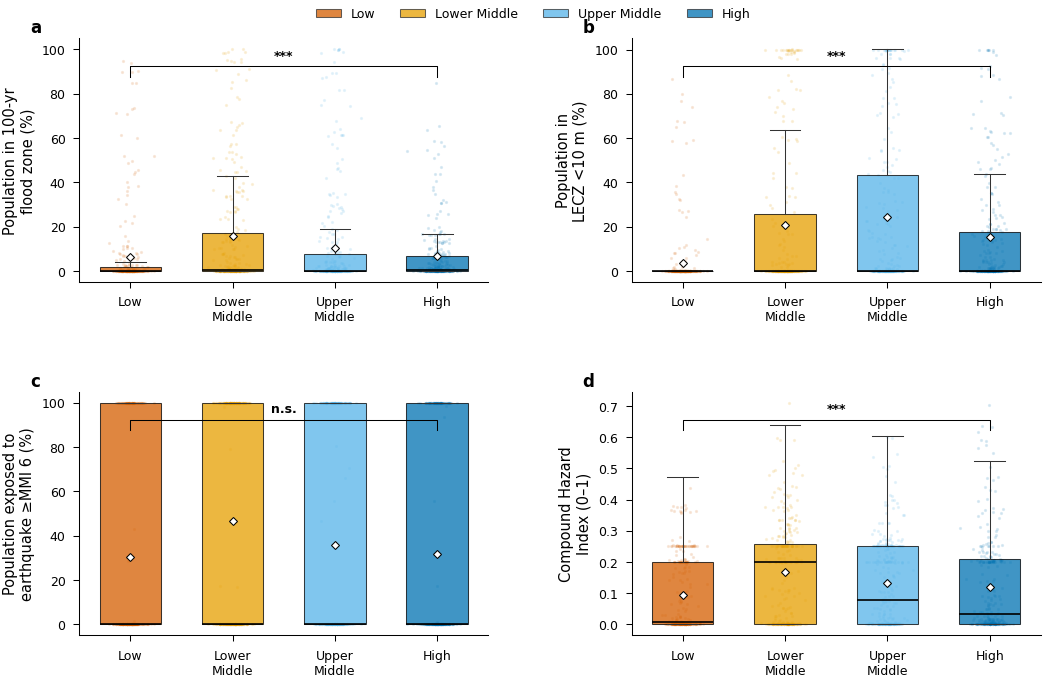


Generating Figure 2...
  Saved: figures/Figure2_LECZ_vs_HDI.pdf, figures/Figure2_LECZ_vs_HDI.png


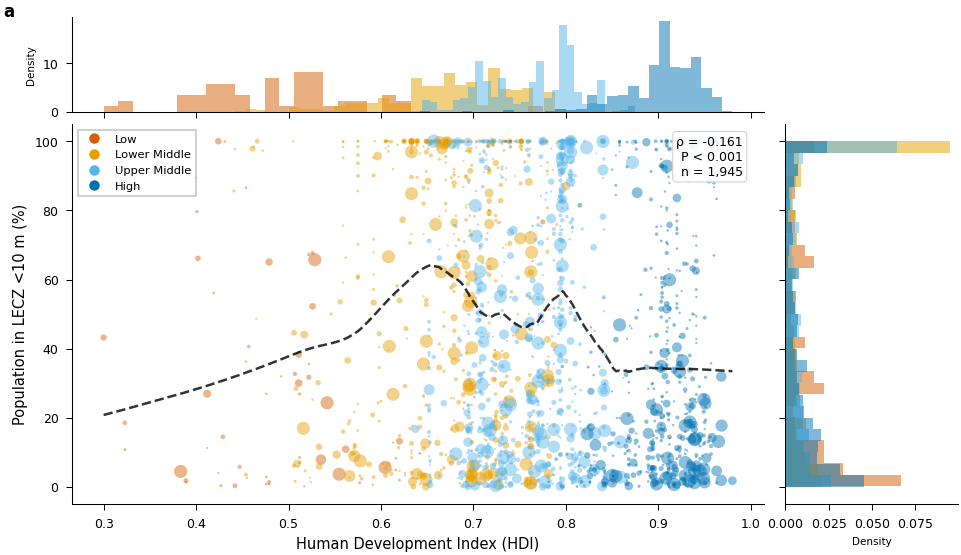


Generating Figure 3...
  Saved: figures/Figure3_hazard_HDI_heatmap.pdf, figures/Figure3_hazard_HDI_heatmap.png


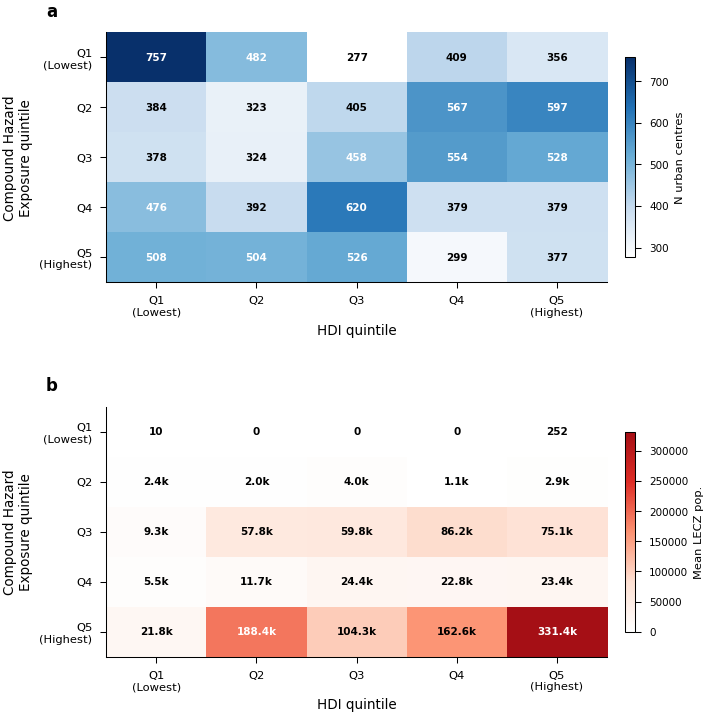


Generating Figure 4...
  Saved: figures/Figure4_demographics.pdf, figures/Figure4_demographics.png


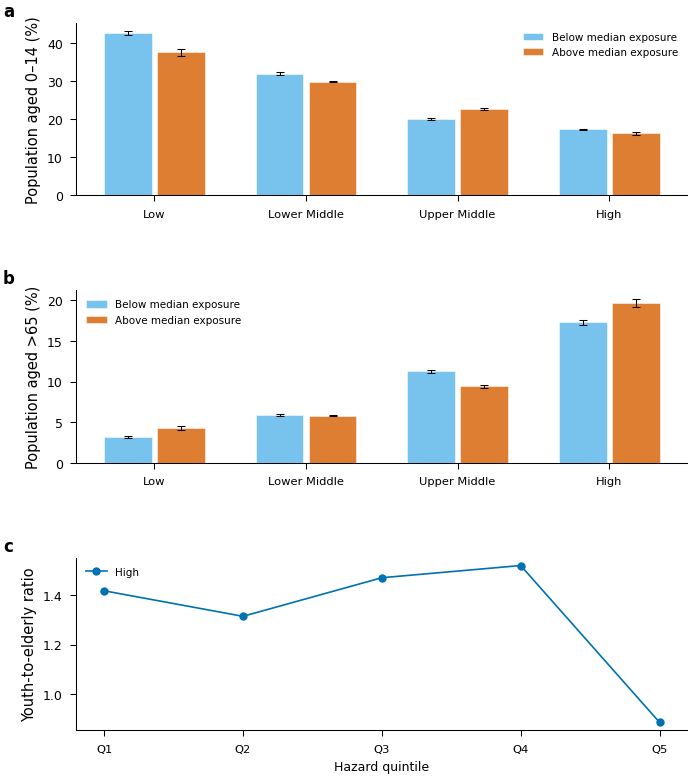


Generating Figure 5...
  Quantile regressions...
    τ=0.10 done
    τ=0.25 done
    τ=0.50 done
    τ=0.75 done
    τ=0.90 done
  Saved: figures/Figure5_quantile_regression.pdf, figures/Figure5_quantile_regression.png


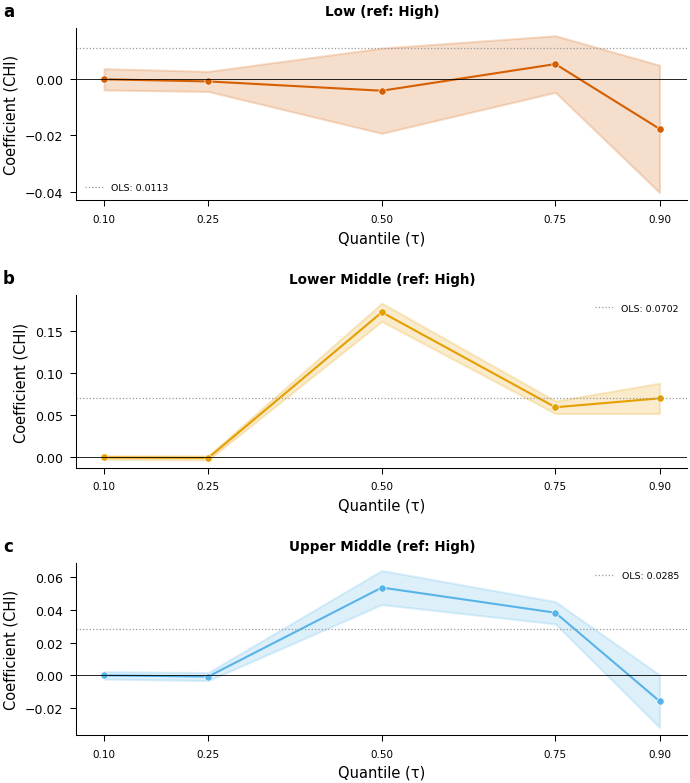


Running regressions...

REGRESSION RESULTS

                                                             (1) Bivariate (2) Controls (3) Region FE  (4) HDI  
----------------------------------------------------------------------------------------------------------------
Intercept                                                    0.1167***     0.3097***    0.3195***     0.3406*** 
                                                             (0.0037)      (0.0284)     (0.0316)      (0.0353)  
C(income_group, Treatment(reference="High"))[T.Low]          -0.0367***    0.0028       0.0008                  
                                                             (0.0051)      (0.0062)     (0.0080)                
C(income_group, Treatment(reference="High"))[T.Lower Middle] 0.0494***     0.0761***    -0.0001                 
                                                             (0.0044)      (0.0051)     (0.0069)                
C(income_group, Treatment(reference="High"))[T.Uppe

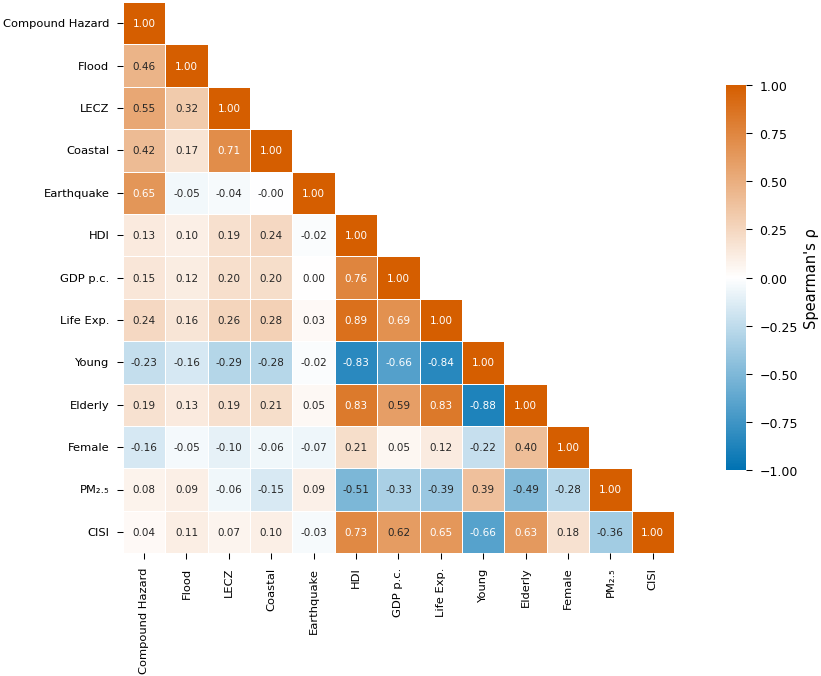


ANALYSIS COMPLETE

Outputs:
  figures/  Figure1–5 + ExtendedData_correlation_matrix (.pdf/.png)
  tables/   Table1, regression, regional, top50 (.csv/.xlsx)

Dataset: GHS-UCDB R2024A V1.1 (GeoPackage)
  doi: 10.2905/1a338be6-7eaf-480c-9664-3a8ade88cbcd



In [ ]:
#!/usr/bin/env python3
"""
===============================================================================
Climate Justice & Urban Inequality: Global Analysis of 11,422 Urban Centres
===============================================================================
Target: Nature Climate Change (Analysis)
Dataset: GHS-UCDB R2024A V1.1 — GeoPackage (.gpkg)
===============================================================================
"""

# =============================================================================
# CELL 1: ENVIRONMENT SETUP
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap, Normalize, BoundaryNorm
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu, spearmanr, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import OrderedDict
import os

try:
    import geopandas as gpd
except ImportError:
    os.system('pip install geopandas pyogrio --quiet')
    import geopandas as gpd

print("All packages loaded.")

# =============================================================================
# CELL 2: NATURE CLIMATE CHANGE STYLE
# =============================================================================

MM_TO_INCH = 1 / 25.4
NATURE_SINGLE_COL = 89 * MM_TO_INCH
NATURE_DOUBLE_COL = 183 * MM_TO_INCH
NATURE_MAX_HEIGHT = 247 * MM_TO_INCH
FIGURE_DPI = 300

WONG_PALETTE = {
    'black': '#000000', 'orange': '#E69F00', 'sky_blue': '#56B4E9',
    'green': '#009E73', 'yellow': '#F0E442', 'blue': '#0072B2',
    'vermilion': '#D55E00', 'purple': '#CC79A7',
}

INCOME_COLORS = OrderedDict([
    ('Low',          WONG_PALETTE['vermilion']),
    ('Lower Middle', WONG_PALETTE['orange']),
    ('Upper Middle', WONG_PALETTE['sky_blue']),
    ('High',         WONG_PALETTE['blue']),
])
INCOME_ORDER = ['Low', 'Lower Middle', 'Upper Middle', 'High']

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 7, 'axes.labelsize': 7, 'axes.titlesize': 8,
    'axes.linewidth': 0.5, 'axes.labelpad': 3,
    'axes.spines.top': False, 'axes.spines.right': False,
    'xtick.labelsize': 6, 'ytick.labelsize': 6,
    'xtick.major.size': 3, 'xtick.major.width': 0.5,
    'ytick.major.size': 3, 'ytick.major.width': 0.5,
    'xtick.direction': 'out', 'ytick.direction': 'out',
    'legend.fontsize': 6, 'legend.frameon': False,
    'lines.linewidth': 0.8, 'lines.markersize': 3,
    'figure.dpi': 150, 'savefig.dpi': FIGURE_DPI,
    'savefig.bbox': 'tight', 'savefig.pad_inches': 0.02,
    'grid.linewidth': 0.3, 'grid.alpha': 0.3,
})


def add_panel_label(ax, label, x=-0.12, y=1.08):
    ax.text(x, y, label, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='left')


def save_figure(fig, filename, formats=('pdf', 'png')):
    os.makedirs('figures', exist_ok=True)
    for fmt in formats:
        fig.savefig(f'figures/{filename}.{fmt}', format=fmt, dpi=FIGURE_DPI,
                    bbox_inches='tight', pad_inches=0.02,
                    facecolor='white', edgecolor='none')
    print(f"  Saved: {', '.join(f'figures/{filename}.{f}' for f in formats)}")


print("Nature style configured.")

# =============================================================================
# CELL 3: DATA LOADING (GeoPackage — multi-layer)
# =============================================================================

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/GHS_UCDB_GLOBE_R2024A.gpkg'  # UPDATE IF NEEDED

if not os.path.exists(DATA_PATH):
    import glob
    matches = glob.glob('/content/drive/MyDrive/**/*.gpkg', recursive=True)
    if matches:
        DATA_PATH = matches[0]
        print(f"Auto-detected: {DATA_PATH}")
    else:
        raise FileNotFoundError("No .gpkg found. Upload and update DATA_PATH.")

print(f"File: {DATA_PATH} ({os.path.getsize(DATA_PATH)/1e6:.1f} MB)")

LAYERS_TO_LOAD = {
    'gc':   'GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A',
    'sc':   'GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A',
    'ex':   'GHS_UCDB_THEME_EXPOSURE_GLOBE_R2024A',
    'em':   'GHS_UCDB_THEME_EMISSIONS_GLOBE_R2024A',
    'hl':   'GHS_UCDB_THEME_HEALTH_GLOBE_R2024A',
    'infr': 'GHS_UCDB_THEME_INFRASTRUCTURES_GLOBE_R2024A',
}


def strip_bom(text):
    if isinstance(text, str):
        return text.replace('\ufeff', '').strip()
    return text


def load_gpkg_layer(path, layer_name, keep_geometry=False):
    gdf_layer = gpd.read_file(path, layer=layer_name)
    gdf_layer.columns = [strip_bom(c) for c in gdf_layer.columns]
    for col in gdf_layer.select_dtypes(include=['object']).columns:
        if col != 'geometry':
            gdf_layer[col] = gdf_layer[col].apply(strip_bom)
    if not keep_geometry and 'geometry' in gdf_layer.columns:
        gdf_layer = pd.DataFrame(gdf_layer.drop(columns='geometry'))
    return gdf_layer


print("\nLoading layers...\n")
raw = {}
for key, layer_name in LAYERS_TO_LOAD.items():
    print(f"  {key:5s} → {layer_name}...", end=' ', flush=True)
    raw[key] = load_gpkg_layer(DATA_PATH, layer_name, keep_geometry=(key == 'gc'))
    print(f"({raw[key].shape[0]:,} × {raw[key].shape[1]:,})")

print(f"\nAll layers loaded. Urban centres: {raw['gc'].shape[0]:,}")

# =============================================================================
# CELL 4: DATA PREPARATION
# =============================================================================

ID_COL = 'ID_UC_G0'


def find_col(dataframe, pattern, exclude=None):
    for c in sorted(dataframe.columns, reverse=True):
        if pattern.upper() in c.upper():
            if exclude and any(ex.upper() in c.upper() for ex in exclude):
                continue
            return c
    return None


# --- General Characteristics ---
gc = raw['gc']
gc_cols = {
    'name': find_col(gc, 'GC_UCN_MAI'),
    'country_gadm': find_col(gc, 'GC_CNT_GAD'),
    'country_un': find_col(gc, 'GC_CNT_UNN'),
    'area_km2': find_col(gc, 'GC_UCA_KM2'),
    'population': find_col(gc, 'GC_POP_TOT'),
    'income_group': find_col(gc, 'GC_DEV_WIG'),
    'sdg_region': find_col(gc, 'GC_DEV_USR'),
}

gc_select = [ID_COL] + [v for v in gc_cols.values() if v]
gc_rename = {ID_COL: 'id'}
gc_rename.update({v: k for k, v in gc_cols.items() if v})
df = gc[gc_select + ['geometry']].copy().rename(columns=gc_rename)

# --- Socioeconomic ---
sc = raw['sc']
sc_map = {
    'hdi':           find_col(sc, 'SC_SEC_HDI', exclude=['GDF', 'GDM']),
    'gdp_avg':       find_col(sc, 'SC_GDP_AVG'),
    'gdp_total':     find_col(sc, 'SC_GDP_SUM'),
    'life_exp':      find_col(sc, 'SC_SEC_LET', exclude=['LEF', 'LEM']),
    'schooling_exp': find_col(sc, 'SC_SEC_SET', exclude=['SEF', 'SEM']),
    'pct_young':     find_col(sc, 'SC_SEC_PCY'),
    'pct_adult':     find_col(sc, 'SC_SEC_PCA'),
    'pct_old':       find_col(sc, 'SC_SEC_PCO'),
    'pct_female':    find_col(sc, 'SC_SEC_PCF'),
    'pct_male':      find_col(sc, 'SC_SEC_PCM'),
    'gdi':           find_col(sc, 'SC_SEC_GDI', exclude=['GDF', 'GDM']),
}
sc_r = {v: k for k, v in sc_map.items() if v}
df = df.merge(sc[[ID_COL]+list(sc_r.keys())].rename(columns={**sc_r, ID_COL:'id'}),
              on='id', how='left')
print(f"Socioeconomic: {len(sc_r)}/{len(sc_map)}")

# --- Exposure ---
ex = raw['ex']
ex_map = {
    'pop_flood_100yr':            find_col(ex, 'EX_100_POP'),
    'pop_flood_10yr':             find_col(ex, 'EX_010_POP'),
    'share_pop_flood_100yr':      find_col(ex, 'EX_100_SHP'),
    'share_pop_flood_10yr':       find_col(ex, 'EX_010_SHP'),
    'pop_lecz_5m':                find_col(ex, 'EX_L05_POP'),
    'pop_lecz_10m':               find_col(ex, 'EX_L10_POP'),
    'share_pop_lecz_5m':          find_col(ex, 'EX_L05_SHP'),
    'share_pop_lecz_10m':         find_col(ex, 'EX_L10_SHP'),
    'share_pop_lecz_below10m':    find_col(ex, 'EX_LEC_SHP'),
    'builtup_lecz_5m':            find_col(ex, 'EX_L05_BUS', exclude=['B1', 'B2']),
    'pop_coastal_100yr':          find_col(ex, 'EX_CF1_POP'),
    'pop_coastal_20yr':           find_col(ex, 'EX_CF2_POP'),
    'share_pop_coastal_100yr':    find_col(ex, 'EX_CF1_SHP'),
    'share_pop_coastal_20yr':     find_col(ex, 'EX_CF2_SHP'),
    'share_pop_earthquake_mmi6':  find_col(ex, 'EX_SHA_POP'),
    'pop_cyclone_100yr':          find_col(ex, 'EX_100_S1P'),
    'pop_cyclone_400yr_ss3':      find_col(ex, 'EX_400_S3P'),
}
ex_r = {v: k for k, v in ex_map.items() if v}
df = df.merge(ex[[ID_COL]+list(ex_r.keys())].rename(columns={**ex_r, ID_COL:'id'}),
              on='id', how='left')
print(f"Exposure: {len(ex_r)}/{len(ex_map)}")

# --- Emissions ---
em = raw['em']
em_map = {
    'pm25_deaths':    find_col(em, 'EM_PM2_MOR'),
    'pm25_conc':      find_col(em, 'EM_PM2_CON'),
    'co2_total':      find_col(em, 'EM_CO2_TOT'),
    'co2_per_capita': find_col(em, 'EM_CO2_PEC'),
}
em_r = {v: k for k, v in em_map.items() if v}
if em_r:
    df = df.merge(em[[ID_COL]+list(em_r.keys())].rename(columns={**em_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Emissions: {len(em_r)}/{len(em_map)}")

# --- Health ---
hl = raw['hl']
hl_map = {
    'hospitals_per_cap':       find_col(hl, 'HL_FPC_HOS'),
    'share_pop_near_hospital': find_col(hl, 'HL_SHP_HOS'),
}
hl_r = {v: k for k, v in hl_map.items() if v}
if hl_r:
    df = df.merge(hl[[ID_COL]+list(hl_r.keys())].rename(columns={**hl_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Health: {len(hl_r)}/{len(hl_map)}")

# --- Infrastructure ---
infr = raw['infr']
infr_map = {
    'cisi_all':    find_col(infr, 'IN_CIS_ALL'),
    'cisi_energy': find_col(infr, 'IN_CIS_ENE'),
}
infr_r = {v: k for k, v in infr_map.items() if v}
if infr_r:
    df = df.merge(infr[[ID_COL]+list(infr_r.keys())].rename(columns={**infr_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Infrastructure: {len(infr_r)}/{len(infr_map)}")

# --- Numeric conversion ---
skip = {'id', 'name', 'country_gadm', 'country_un', 'income_group', 'sdg_region', 'geometry'}
for col in df.columns:
    if col not in skip:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Standardise income groups (BOM already stripped from values) ---
income_map = {
    'Low': 'Low', 'Low Income': 'Low', 'Low income': 'Low',
    'Lower Middle': 'Lower Middle', 'Lower Middle Income': 'Lower Middle',
    'Lower middle income': 'Lower Middle', 'Lower-middle income': 'Lower Middle',
    'Upper Middle': 'Upper Middle', 'Upper Middle Income': 'Upper Middle',
    'Upper middle income': 'Upper Middle', 'Upper-middle income': 'Upper Middle',
    'High': 'High', 'High Income': 'High', 'High income': 'High',
}
df['income_group'] = df['income_group'].map(
    lambda x: income_map.get(str(x).strip(), str(x).strip()) if pd.notna(x) else np.nan
)

print(f"\nIncome groups after standardisation:")
print(df['income_group'].value_counts(dropna=False))

# --- Derived variables ---
df['pop_density'] = df['population'] / df['area_km2'].replace(0, np.nan)

if 'pop_cyclone_100yr' in df.columns:
    df['share_pop_cyclone_100yr'] = (
        df['pop_cyclone_100yr'] / df['population'].replace(0, np.nan) * 100)
else:
    df['share_pop_cyclone_100yr'] = np.nan

df['pop_lecz_total'] = df.get('pop_lecz_5m', pd.Series(0, index=df.index)).fillna(0) + \
                        df.get('pop_lecz_10m', pd.Series(0, index=df.index)).fillna(0)

# --- Compound Hazard Exposure Index ---
hazard_vars = ['share_pop_flood_100yr', 'share_pop_lecz_below10m',
               'share_pop_coastal_100yr', 'share_pop_earthquake_mmi6',
               'share_pop_cyclone_100yr']

available_hazards = [v for v in hazard_vars if v in df.columns and df[v].notna().sum() > 100]
print(f"\nCompound Hazard Index ({len(available_hazards)}/{len(hazard_vars)}):")

for var in available_hazards:
    vals = df[var]
    vmin, vmax = vals.min(), vals.max()
    if pd.notna(vmin) and pd.notna(vmax) and vmax > vmin:
        df[f'{var}_norm'] = (vals - vmin) / (vmax - vmin)
    else:
        df[f'{var}_norm'] = 0.0
    print(f"  ✓ {var} (n={vals.notna().sum():,})")

norm_cols = [f'{v}_norm' for v in available_hazards]
df['compound_hazard_index'] = df[norm_cols].mean(axis=1, skipna=True)

# --- Quintiles ---
try:
    df['hdi_quintile'] = pd.qcut(df['hdi'], q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'], duplicates='drop')
except:
    df['hdi_quintile'] = pd.qcut(df['hdi'].rank(method='first'), q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])
try:
    df['hazard_quintile'] = pd.qcut(df['compound_hazard_index'], q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'], duplicates='drop')
except:
    df['hazard_quintile'] = pd.qcut(df['compound_hazard_index'].rank(method='first'), q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])

# --- Final sample ---
df_valid = df[df['income_group'].isin(INCOME_ORDER)].copy()

print(f"\n{'='*60}")
print(f"FINAL ANALYTICAL SAMPLE: {df_valid.shape[0]:,} urban centres")
print(f"{'='*60}")
for grp in INCOME_ORDER:
    print(f"  {grp:20s} {(df_valid['income_group'] == grp).sum():>6,}")

print(f"\nKey variable coverage (% non-missing):")
for v in ['hdi', 'gdp_avg', 'share_pop_flood_100yr', 'share_pop_lecz_below10m',
           'share_pop_coastal_100yr', 'share_pop_earthquake_mmi6',
           'pct_young', 'pct_old', 'pm25_conc', 'cisi_all', 'compound_hazard_index']:
    if v in df_valid.columns:
        print(f"  {v:35s} {df_valid[v].notna().mean()*100:6.1f}%")

# =============================================================================
# CELL 5: TABLE 1
# =============================================================================

def create_table1(data, income_order):
    variables = OrderedDict([
        ('population',              ('Population',                          ',.0f')),
        ('area_km2',                ('Area (km²)',                          ',.1f')),
        ('pop_density',             ('Pop. density (per km²)',              ',.0f')),
        ('hdi',                     ('HDI',                                 '.3f')),
        ('gdp_avg',                 ('GDP per capita (PPP)',                ',.0f')),
        ('life_exp',                ('Life expectancy (yr)',                '.1f')),
        ('schooling_exp',           ('Expected schooling (yr)',             '.1f')),
        ('pct_young',               ('Pop. 0–14 (%)',                      '.1f')),
        ('pct_old',                 ('Pop. >65 (%)',                        '.1f')),
        ('pct_female',              ('Female pop. (%)',                     '.1f')),
        ('share_pop_flood_100yr',   ('Pop. 100-yr flood (%)',              '.1f')),
        ('share_pop_lecz_below10m', ('Pop. LECZ <10 m (%)',               '.1f')),
        ('share_pop_coastal_100yr', ('Pop. coastal flood (%)',             '.1f')),
        ('share_pop_earthquake_mmi6', ('Pop. earthquake ≥MMI 6 (%)',      '.1f')),
        ('share_pop_cyclone_100yr', ('Pop. cyclone (%)',                   '.1f')),
        ('compound_hazard_index',   ('Compound Hazard Index',              '.3f')),
        ('pm25_conc',               ('PM₂.₅ (µg/m³)',                     '.1f')),
        ('cisi_all',                ('CISI',                               '.3f')),
        ('share_pop_near_hospital', ('Pop. near hospital (%)',             '.1f')),
    ])
    variables = OrderedDict((k, v) for k, v in variables.items() if k in data.columns)

    rows = [{'Variable': 'N (urban centres)',
             **{g: f"{(data['income_group']==g).sum():,}" for g in income_order},
             'All': f"{data.shape[0]:,}", 'p-value': ''}]

    for var_name, (label, fmt) in variables.items():
        row = {'Variable': label}
        gvals = []
        for grp in income_order:
            gd = data.loc[data['income_group'] == grp, var_name].dropna()
            gvals.append(gd)
            if len(gd) > 0:
                m, q1, q3 = gd.median(), gd.quantile(0.25), gd.quantile(0.75)
                row[grp] = f"{m:{fmt}} ({q1:{fmt}}–{q3:{fmt}})"
            else:
                row[grp] = '—'
        ad = data[var_name].dropna()
        if len(ad) > 0:
            m, q1, q3 = ad.median(), ad.quantile(0.25), ad.quantile(0.75)
            row['All'] = f"{m:{fmt}} ({q1:{fmt}}–{q3:{fmt}})"
        else:
            row['All'] = '—'
        vg = [g for g in gvals if len(g) >= 5]
        if len(vg) >= 2:
            try:
                _, p = kruskal(*vg)
                row['p-value'] = '<0.001' if p < 0.001 else f"{p:.3f}"
            except:
                row['p-value'] = '—'
        else:
            row['p-value'] = '—'
        rows.append(row)

    return pd.DataFrame(rows)[['Variable'] + income_order + ['All', 'p-value']]


table1 = create_table1(df_valid, INCOME_ORDER)
print("\n" + "="*100)
print("TABLE 1: Descriptive statistics by World Bank income group")
print("="*100)
print(table1.to_string(index=False))
os.makedirs('tables', exist_ok=True)
table1.to_csv('tables/Table1_descriptive_stats.csv', index=False)
table1.to_excel('tables/Table1_descriptive_stats.xlsx', index=False)
print("  Saved: tables/Table1_descriptive_stats.csv/.xlsx")

# =============================================================================
# CELL 6: FIGURE 1 — MULTI-HAZARD EXPOSURE
# =============================================================================

def figure1_multihazard(data, income_order, income_colors):
    fig = plt.figure(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.65))
    gs = gridspec.GridSpec(2, 2, hspace=0.45, wspace=0.35,
                           left=0.08, right=0.97, top=0.93, bottom=0.08)
    panels = {
        'a': ('share_pop_flood_100yr', 'Population in 100-yr\nflood zone (%)'),
        'b': ('share_pop_lecz_below10m', 'Population in\nLECZ <10 m (%)'),
        'c': ('share_pop_earthquake_mmi6', 'Population exposed to\nearthquake ≥MMI 6 (%)'),
        'd': ('compound_hazard_index', 'Compound Hazard\nIndex (0–1)'),
    }
    for idx, (label, (var, ylabel)) in enumerate(panels.items()):
        ax = fig.add_subplot(gs[idx // 2, idx % 2])
        if var not in data.columns or data[var].notna().sum() < 10:
            ax.text(0.5, 0.5, f'{var}\nnot available', transform=ax.transAxes,
                   ha='center', va='center', fontsize=6, color='grey')
            add_panel_label(ax, label); continue

        plot_data = [data.loc[data['income_group'] == g, var].dropna() for g in income_order]
        bp = ax.boxplot(plot_data, positions=range(len(income_order)), widths=0.6,
            patch_artist=True, showfliers=False, showmeans=True,
            meanprops=dict(marker='D', markerfacecolor='white',
                          markeredgecolor='black', markersize=2.5, markeredgewidth=0.5),
            medianprops=dict(color='black', linewidth=0.8),
            whiskerprops=dict(linewidth=0.5, color='#333333'),
            capprops=dict(linewidth=0.5, color='#333333'),
            boxprops=dict(linewidth=0.5))

        for patch, grp in zip(bp['boxes'], income_order):
            patch.set_facecolor(income_colors[grp]); patch.set_alpha(0.75)

        rng = np.random.default_rng(42)
        for i, grp in enumerate(income_order):
            vals = data.loc[data['income_group'] == grp, var].dropna()
            n_plot = min(300, len(vals))
            if n_plot > 0:
                vs = vals.sample(n=n_plot, random_state=42) if len(vals) > n_plot else vals
                ax.scatter(i + rng.normal(0, 0.08, len(vs)), vs, s=0.3, alpha=0.15,
                          color=income_colors[grp], zorder=1, rasterized=True)

        ax.set_xticks(range(len(income_order)))
        short_labels = ['Low', 'Lower\nMiddle', 'Upper\nMiddle', 'High']
        ax.set_xticklabels(short_labels, rotation=0, ha='center')
        ax.set_ylabel(ylabel)

        gl = data.loc[data['income_group'] == 'Low', var].dropna()
        gh = data.loc[data['income_group'] == 'High', var].dropna()
        if len(gl) > 5 and len(gh) > 5:
            _, pv = mannwhitneyu(gl, gh, alternative='two-sided')
            sig = '***' if pv < 0.001 else ('**' if pv < 0.01 else ('*' if pv < 0.05 else 'n.s.'))
            yb = ax.get_ylim()[1] * 0.88
            ax.plot([0, 0, 3, 3], [yb*0.95, yb, yb, yb*0.95], lw=0.5, color='black')
            ax.text(1.5, yb * 1.02, sig, ha='center', va='bottom', fontsize=6, fontweight='bold')
        add_panel_label(ax, label)

    legend_el = [mpatches.Patch(facecolor=income_colors[g], alpha=0.75,
                 edgecolor='#333333', linewidth=0.5, label=g) for g in income_order]
    fig.legend(handles=legend_el, loc='upper center', ncol=4, fontsize=6,
              frameon=False, bbox_to_anchor=(0.5, 0.99))
    save_figure(fig, 'Figure1_multihazard_exposure')
    plt.show()
    return fig

print("\nGenerating Figure 1...")
fig1 = figure1_multihazard(df_valid, INCOME_ORDER, INCOME_COLORS)

# =============================================================================
# CELL 7: FIGURE 2 — LECZ vs HDI
# =============================================================================

def figure2_lecz_hdi(data, income_colors):
    mask = (data['share_pop_lecz_below10m'].notna() &
            (data['share_pop_lecz_below10m'] > 0) & data['hdi'].notna())
    pdf = data[mask].copy()
    if len(pdf) < 50:
        print("  Warning: Too few cities for Figure 2"); return None

    fig = plt.figure(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.55))
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           hspace=0.05, wspace=0.05,
                           left=0.1, right=0.92, top=0.92, bottom=0.1)
    ax_m = fig.add_subplot(gs[1, 0])
    ax_t = fig.add_subplot(gs[0, 0], sharex=ax_m)
    ax_r = fig.add_subplot(gs[1, 1], sharey=ax_m)

    for grp in INCOME_ORDER:
        gd = pdf[pdf['income_group'] == grp]
        if len(gd) == 0: continue
        sizes = np.clip(gd['population'] / 50000, 1, 40)
        ax_m.scatter(gd['hdi'], gd['share_pop_lecz_below10m'], s=sizes, alpha=0.45,
                    color=income_colors[grp], label=grp, edgecolors='none', rasterized=True)

    valid = pdf[['hdi', 'share_pop_lecz_below10m']].dropna()
    if len(valid) > 50:
        sm_out = lowess(valid['share_pop_lecz_below10m'], valid['hdi'], frac=0.3, return_sorted=True)
        ax_m.plot(sm_out[:, 0], sm_out[:, 1], color='black', lw=1.2, ls='--', zorder=5, alpha=0.8)

    ax_m.set_xlabel('Human Development Index (HDI)')
    ax_m.set_ylabel('Population in LECZ <10 m (%)')
    rho, pr = spearmanr(valid['hdi'], valid['share_pop_lecz_below10m'])
    pt = 'P < 0.001' if pr < 0.001 else f'P = {pr:.3f}'
    ax_m.text(0.97, 0.97, f'ρ = {rho:.3f}\n{pt}\nn = {len(valid):,}',
             transform=ax_m.transAxes, fontsize=6, va='top', ha='right',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                      edgecolor='#ccc', alpha=0.9, linewidth=0.5))

    for grp in INCOME_ORDER:
        v = pdf.loc[pdf['income_group'] == grp, 'hdi'].dropna()
        if len(v) > 5: ax_t.hist(v, bins=30, alpha=0.5, color=income_colors[grp], density=True, edgecolor='none')
    ax_t.set_ylabel('Density', fontsize=5); ax_t.tick_params(labelbottom=False)

    for grp in INCOME_ORDER:
        v = pdf.loc[pdf['income_group'] == grp, 'share_pop_lecz_below10m'].dropna()
        if len(v) > 5: ax_r.hist(v, bins=30, alpha=0.5, color=income_colors[grp], density=True, orientation='horizontal', edgecolor='none')
    ax_r.set_xlabel('Density', fontsize=5); ax_r.tick_params(labelleft=False)

    leg = [Line2D([0], [0], marker='o', color='w', markerfacecolor=income_colors[g],
                  markersize=5, label=g, markeredgewidth=0) for g in INCOME_ORDER]
    ax_m.legend(handles=leg, loc='upper left', fontsize=5.5, frameon=True,
               fancybox=False, edgecolor='#ccc', framealpha=0.9)
    add_panel_label(ax_t, 'a', x=-0.1, y=1.15)
    save_figure(fig, 'Figure2_LECZ_vs_HDI')
    plt.show()
    return fig

print("\nGenerating Figure 2...")
fig2 = figure2_lecz_hdi(df_valid, INCOME_COLORS)

# =============================================================================
# CELL 8: FIGURE 3 — HAZARD × HDI HEATMAP
# =============================================================================

def figure3_heatmap(data):
    mask = data['hdi_quintile'].notna() & data['hazard_quintile'].notna()
    sub = data[mask].copy()
    if len(sub) < 100:
        print("  Warning: Too few for Figure 3"); return None

    ct_n = pd.crosstab(sub['hazard_quintile'], sub['hdi_quintile'])
    ct_p = sub.groupby(['hazard_quintile', 'hdi_quintile'])['pop_lecz_total'].mean().unstack(fill_value=0)
    ct_p = ct_p.reindex(index=ct_n.index, columns=ct_n.columns, fill_value=0)

    fig, axes = plt.subplots(2, 1, figsize=(NATURE_SINGLE_COL * 1.5, NATURE_DOUBLE_COL * 0.75),
                              gridspec_kw={'hspace': 0.5})

    cmap_a = LinearSegmentedColormap.from_list('c', ['#FFF', '#C6DBEF', '#6BAED6', '#2171B5', '#08306B'])
    im = axes[0].imshow(ct_n.values, cmap=cmap_a, aspect='auto')
    for i in range(ct_n.shape[0]):
        for j in range(ct_n.shape[1]):
            v = ct_n.values[i, j]
            axes[0].text(j, i, f'{v:,}', ha='center', va='center', fontsize=5,
                        color='white' if v > ct_n.values.max()*0.6 else 'black', fontweight='bold')
    axes[0].set_xticks(range(ct_n.shape[1])); axes[0].set_xticklabels(ct_n.columns, fontsize=5.5)
    axes[0].set_yticks(range(ct_n.shape[0])); axes[0].set_yticklabels(ct_n.index, fontsize=5.5)
    axes[0].set_xlabel('HDI quintile', fontsize=6.5)
    axes[0].set_ylabel('Compound Hazard\nExposure quintile', fontsize=6.5)
    cb = fig.colorbar(im, ax=axes[0], shrink=0.8, pad=0.03)
    cb.ax.tick_params(labelsize=5); cb.set_label('N urban centres', fontsize=5.5)
    add_panel_label(axes[0], 'a', x=-0.12, y=1.12)

    cmap_b = LinearSegmentedColormap.from_list('p', ['#FFF', '#FEE0D2', '#FC9272', '#DE2D26', '#A50F15'])
    im2 = axes[1].imshow(ct_p.values, cmap=cmap_b, aspect='auto')
    for i in range(ct_p.shape[0]):
        for j in range(ct_p.shape[1]):
            v = ct_p.values[i, j]
            lb = f'{v/1000:.1f}k' if v >= 1000 else f'{v:.0f}'
            axes[1].text(j, i, lb, ha='center', va='center', fontsize=5,
                        color='white' if v > ct_p.values.max()*0.5 else 'black', fontweight='bold')
    axes[1].set_xticks(range(ct_p.shape[1])); axes[1].set_xticklabels(ct_p.columns, fontsize=5.5)
    axes[1].set_yticks(range(ct_p.shape[0])); axes[1].set_yticklabels(ct_p.index, fontsize=5.5)
    axes[1].set_xlabel('HDI quintile', fontsize=6.5)
    axes[1].set_ylabel('Compound Hazard\nExposure quintile', fontsize=6.5)
    cb2 = fig.colorbar(im2, ax=axes[1], shrink=0.8, pad=0.03)
    cb2.ax.tick_params(labelsize=5); cb2.set_label('Mean LECZ pop.', fontsize=5.5)
    add_panel_label(axes[1], 'b', x=-0.12, y=1.12)

    plt.tight_layout(h_pad=2)
    save_figure(fig, 'Figure3_hazard_HDI_heatmap')
    plt.show()
    return fig

print("\nGenerating Figure 3...")
fig3 = figure3_heatmap(df_valid)

# =============================================================================
# CELL 9: FIGURE 4 — DEMOGRAPHICS  [UPDATED: vertical 3×1 layout]
# =============================================================================

def figure4_demographics(data, income_order, income_colors):
    med_haz = data['compound_hazard_index'].median()
    data = data.copy()
    data['high_exp'] = data['compound_hazard_index'] >= med_haz

    # --- LAYOUT CHANGED: 3 rows × 1 column (a: top, b: middle, c: bottom) ---
    fig, axes = plt.subplots(3, 1,
                              figsize=(NATURE_SINGLE_COL * 1.5, NATURE_DOUBLE_COL * 0.85),
                              gridspec_kw={'hspace': 0.55})
    bw = 0.35
    x = np.arange(len(income_order))

    # --- Panels a & b: grouped bar charts ---
    for ai, (ax, var, yl) in enumerate(zip(
        axes[:2], ['pct_young', 'pct_old'],
        ['Population aged 0–14 (%)', 'Population aged >65 (%)']
    )):
        if var not in data.columns:
            ax.text(0.5, 0.5, 'N/A', transform=ax.transAxes, ha='center', fontsize=6)
            add_panel_label(ax, chr(97+ai)); continue
        for i, (el, ev) in enumerate([('Below median exposure', False),
                                       ('Above median exposure', True)]):
            means, cis = [], []
            for grp in income_order:
                v = data.loc[(data['income_group']==grp) & (data['high_exp']==ev), var].dropna()
                means.append(v.mean() if len(v) > 0 else 0)
                cis.append(1.96 * v.std()/np.sqrt(len(v)) if len(v) > 1 else 0)
            off = -bw/2 + i*bw
            col = WONG_PALETTE['sky_blue'] if not ev else WONG_PALETTE['vermilion']
            ax.bar(x+off, means, bw*0.9, yerr=cis, label=el, color=col, alpha=0.8,
                   edgecolor='white', linewidth=0.3,
                   error_kw=dict(lw=0.5, capsize=2, capthick=0.5))
        short_labels = ['Low', 'Lower Middle', 'Upper Middle', 'High']
        ax.set_xticks(x); ax.set_xticklabels(short_labels, fontsize=5.5)
        ax.set_ylabel(yl)
        ax.legend(fontsize=5, loc='upper right' if ai == 0 else 'upper left')
        add_panel_label(ax, chr(97+ai), x=-0.12, y=1.12)

    # --- Panel c: youth-to-elderly ratio across hazard quintiles ---
    ax = axes[2]
    if 'pct_young' in data.columns and 'pct_old' in data.columns:
        data['yer'] = data['pct_young'] / data['pct_old'].replace(0, np.nan)
        for grp in income_order:
            gd = data[data['income_group'] == grp].copy()
            try:
                gd['hq'] = pd.qcut(gd['compound_hazard_index'], q=5,
                                    labels=[1,2,3,4,5], duplicates='drop')
                m = gd.groupby('hq')['yer'].mean()
                ax.plot(m.index.astype(int), m.values, marker='o', markersize=3,
                       lw=0.8, color=income_colors[grp], label=grp)
            except:
                continue
        ax.set_xlabel('Hazard quintile', fontsize=6)
        ax.set_ylabel('Youth-to-elderly ratio')
        ax.set_xticks([1,2,3,4,5])
        ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], fontsize=5.5)
        ax.legend(fontsize=5, loc='upper left')
    add_panel_label(ax, 'c', x=-0.12, y=1.12)

    plt.tight_layout(h_pad=2.0)
    save_figure(fig, 'Figure4_demographics')
    plt.show()
    return fig

print("\nGenerating Figure 4...")
fig4 = figure4_demographics(df_valid, INCOME_ORDER, INCOME_COLORS)

# =============================================================================
# CELL 10: FIGURE 5 — QUANTILE REGRESSION  [UPDATED: vertical 3×1 layout]
# =============================================================================

def figure5_quantile_regression(data, income_order):
    rd = data[['compound_hazard_index', 'income_group', 'area_km2', 'population']].dropna().copy()
    if len(rd) < 100:
        print("  Too few obs"); return None, {}

    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])
    rd = pd.get_dummies(rd, columns=['income_group'], drop_first=False, dtype=float)

    dummies = [f'income_group_{g}' for g in income_order if g != 'High'
               and f'income_group_{g}' in rd.columns]
    if not dummies:
        print("  No income dummies"); return None, {}

    X = sm.add_constant(rd[dummies + ['log_pop', 'log_area']].astype(float))
    y = rd['compound_hazard_index'].astype(float)

    quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
    results = {q: {} for q in quantiles}
    print("  Quantile regressions...")
    for q in quantiles:
        try:
            res = QuantReg(y, X).fit(q=q, max_iter=5000)
            for d in dummies:
                gl = d.replace('income_group_', '')
                results[q][gl] = {'coef': res.params[d],
                    'ci_low': res.conf_int().loc[d, 0],
                    'ci_high': res.conf_int().loc[d, 1]}
            print(f"    τ={q:.2f} done")
        except Exception as e:
            print(f"    τ={q:.2f} failed: {e}")

    ols = sm.OLS(y, X).fit(cov_type='HC3')

    grps = [g for g in ['Low', 'Lower Middle', 'Upper Middle']
            if f'income_group_{g}' in rd.columns]

    # --- LAYOUT CHANGED: 3 rows × 1 column (a: top, b: middle, c: bottom) ---
    fig, axes = plt.subplots(len(grps), 1,
                              figsize=(NATURE_SINGLE_COL * 1.5, NATURE_DOUBLE_COL * 0.85),
                              gridspec_kw={'hspace': 0.55})
    if len(grps) == 1: axes = [axes]

    for idx, grp in enumerate(grps):
        ax = axes[idx]
        col = INCOME_COLORS.get(grp, '#333')
        coefs = [results[q].get(grp, {}).get('coef', np.nan) for q in quantiles]
        cil = [results[q].get(grp, {}).get('ci_low', np.nan) for q in quantiles]
        cih = [results[q].get(grp, {}).get('ci_high', np.nan) for q in quantiles]
        ax.fill_between(quantiles, cil, cih, alpha=0.2, color=col)
        ax.plot(quantiles, coefs, 'o-', color=col, markersize=3.5, lw=1,
               markeredgecolor='white', markeredgewidth=0.3)
        dn = f'income_group_{grp}'
        if dn in ols.params.index:
            ax.axhline(ols.params[dn], color='#999', ls=':', lw=0.6,
                      label=f'OLS: {ols.params[dn]:.4f}')
        ax.axhline(0, color='black', lw=0.4)
        ax.set_xlabel('Quantile (τ)')
        ax.set_ylabel('Coefficient (CHI)')
        ax.set_title(f'{grp} (ref: High)', fontsize=6.5, fontweight='bold')
        ax.set_xticks(quantiles)
        ax.set_xticklabels([f'{q:.2f}' for q in quantiles], fontsize=5)
        ax.legend(fontsize=4.5, loc='best')
        add_panel_label(ax, chr(97+idx), x=-0.12, y=1.15)

    plt.tight_layout(h_pad=2.0)
    save_figure(fig, 'Figure5_quantile_regression')
    plt.show()
    return fig, results

print("\nGenerating Figure 5...")
fig5, qreg = figure5_quantile_regression(df_valid, INCOME_ORDER)

# =============================================================================
# CELL 11: REGRESSION TABLE
# =============================================================================

def run_regressions(data):
    rd = data[['compound_hazard_index', 'income_group', 'sdg_region',
               'area_km2', 'population', 'hdi']].dropna().copy()
    if len(rd) < 100:
        print("  Too few obs"); return {}
    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])

    m1 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))',
                  data=rd).fit(cov_type='HC3')
    m2 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area', data=rd).fit(cov_type='HC3')
    m3 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area + C(sdg_region)', data=rd).fit(cov_type='HC3')
    m4 = smf.ols('compound_hazard_index ~ hdi + log_pop + log_area',
                  data=rd).fit(cov_type='HC3')

    print("\n" + "="*80)
    print("REGRESSION RESULTS")
    print("="*80)
    from statsmodels.iolib.summary2 import summary_col
    s = summary_col([m1, m2, m3, m4],
        model_names=['(1) Bivariate', '(2) Controls', '(3) Region FE', '(4) HDI'],
        stars=True, info_dict={
            'N': lambda x: f"{int(x.nobs):,}",
            'R²': lambda x: f"{x.rsquared:.4f}",
            'Adj. R²': lambda x: f"{x.rsquared_adj:.4f}"})
    print(s)
    s.tables[0].to_csv('tables/regression_results.csv')
    print("  Saved: tables/regression_results.csv")
    return {'m1': m1, 'm2': m2, 'm3': m3, 'm4': m4}

print("\nRunning regressions...")
reg_models = run_regressions(df_valid)

# =============================================================================
# CELL 12: EXTENDED DATA — REGIONAL
# =============================================================================

def extended_regional(data):
    regions = sorted(data['sdg_region'].dropna().unique())
    vm = {'compound_hazard_index': 'CHI', 'share_pop_flood_100yr': 'Flood',
          'share_pop_lecz_below10m': 'LECZ', 'hdi': 'HDI',
          'pct_young': 'Young', 'pct_old': 'Old'}
    vm = {k: v for k, v in vm.items() if k in data.columns}
    rows = []
    for r in regions:
        rd = data[data['sdg_region'] == r]
        row = {'Region': r, 'N': rd.shape[0]}
        for var, lbl in vm.items():
            v = rd[var].dropna()
            if len(v) > 0:
                row[f'{lbl} med'] = f"{v.median():.3f}"
                row[f'{lbl} IQR'] = f"{v.quantile(0.25):.3f}–{v.quantile(0.75):.3f}"
            else:
                row[f'{lbl} med'] = '—'; row[f'{lbl} IQR'] = '—'
        rows.append(row)
    ed = pd.DataFrame(rows)
    ed.to_csv('tables/ExtendedData_regional.csv', index=False)
    ed.to_excel('tables/ExtendedData_regional.xlsx', index=False)
    print("  Saved: tables/ExtendedData_regional.csv/.xlsx")
    return ed

print("\nExtended Data: Regional...")
ed_reg = extended_regional(df_valid)
print(ed_reg[['Region', 'N']].to_string(index=False))

# =============================================================================
# CELL 13: TOP 50 EXPOSED LOW-INCOME CITIES
# =============================================================================

def top50_exposed(data):
    low = data[data['income_group'].isin(['Low', 'Lower Middle'])]
    top = low.nlargest(50, 'compound_hazard_index')
    cols = ['name', 'country_gadm', 'income_group', 'population', 'hdi',
            'compound_hazard_index', 'share_pop_flood_100yr',
            'share_pop_lecz_below10m', 'share_pop_earthquake_mmi6', 'pct_young', 'pct_old']
    avail = [c for c in cols if c in top.columns]
    result = top[avail].reset_index(drop=True)
    result.index = result.index + 1; result.index.name = 'Rank'
    result.to_csv('tables/ExtendedData_top50.csv')
    result.to_excel('tables/ExtendedData_top50.xlsx')
    print("  Saved: tables/ExtendedData_top50.csv/.xlsx")
    return result

print("\nTop 50 exposed low-income cities...")
top50 = top50_exposed(df_valid)
print(top50.head(10).to_string())

# =============================================================================
# CELL 14: ROBUSTNESS CHECKS
# =============================================================================

def robustness_checks(data, income_order):
    print("\n" + "="*80)
    print("ROBUSTNESS CHECKS")
    print("="*80)

    # 1. Pop threshold
    print("\n--- Check 1: Pop ≥ 50,000 ---")
    sub = data[data['population'] >= 50000]
    print(f"  N = {sub.shape[0]:,}")
    for g in income_order:
        v = sub.loc[sub['income_group']==g, 'compound_hazard_index'].dropna()
        if len(v) > 0: print(f"  {g}: median CHI = {v.median():.4f}")
    vg = [sub.loc[sub['income_group']==g, 'compound_hazard_index'].dropna() for g in income_order]
    vg = [g for g in vg if len(g) >= 5]
    if len(vg) >= 2:
        h, p = kruskal(*vg); print(f"  KW: H={h:.2f}, p={p:.2e}")

    # 2. GDP quintiles
    print("\n--- Check 2: GDP quintiles ---")
    if 'gdp_avg' in data.columns:
        sub = data[data['gdp_avg'].notna()].copy()
        try:
            sub['gq'] = pd.qcut(sub['gdp_avg'], q=5, labels=['Q1','Q2','Q3','Q4','Q5'], duplicates='drop')
            for q in sub['gq'].cat.categories:
                v = sub.loc[sub['gq']==q, 'compound_hazard_index'].dropna()
                print(f"  {q}: median CHI = {v.median():.4f}, n={len(v):,}")
        except Exception as e: print(f"  Skipped: {e}")

    # 3. LECZ 5m
    print("\n--- Check 3: LECZ 5m ---")
    if 'share_pop_lecz_5m' in data.columns:
        for g in income_order:
            v = data.loc[data['income_group']==g, 'share_pop_lecz_5m'].dropna()
            if len(v) > 0: print(f"  {g}: median = {v.median():.2f}%")

    # 4. Geometric mean
    print("\n--- Check 4: Geometric mean ---")
    nc = [c for c in data.columns if c.endswith('_norm')]
    if nc:
        eps = 1e-6
        dc = data.copy()
        dc['chi_geo'] = np.exp(dc[nc].apply(lambda x: np.log(x + eps)).mean(axis=1))
        vp = dc[['compound_hazard_index', 'chi_geo']].dropna()
        if len(vp) > 50:
            rho, p = spearmanr(vp['compound_hazard_index'], vp['chi_geo'])
            print(f"  Spearman ρ = {rho:.4f}, p = {p:.2e}")

robustness_checks(df_valid, INCOME_ORDER)

# =============================================================================
# CELL 15: CORRELATION MATRIX
# =============================================================================

def extended_correlation(data):
    cv = {'compound_hazard_index': 'Compound Hazard',
          'share_pop_flood_100yr': 'Flood', 'share_pop_lecz_below10m': 'LECZ',
          'share_pop_coastal_100yr': 'Coastal', 'share_pop_earthquake_mmi6': 'Earthquake',
          'hdi': 'HDI', 'gdp_avg': 'GDP p.c.', 'life_exp': 'Life Exp.',
          'pct_young': 'Young', 'pct_old': 'Elderly', 'pct_female': 'Female',
          'pm25_conc': 'PM₂.₅', 'cisi_all': 'CISI'}
    av = {k: v for k, v in cv.items() if k in data.columns}
    sub = data[list(av.keys())].dropna()
    if len(sub) < 50:
        print("  Too few obs for correlation"); return None

    corr = sub.corr(method='spearman')
    corr.index = [av[c] for c in corr.index]
    corr.columns = [av[c] for c in corr.columns]

    fig, ax = plt.subplots(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.65))
    cmap = LinearSegmentedColormap.from_list('d',
        [WONG_PALETTE['blue'], '#FFFFFF', WONG_PALETTE['vermilion']], N=256)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.3, linecolor='white',
                annot=True, fmt='.2f', annot_kws={'size': 5},
                cbar_kws={'shrink': 0.7, 'label': "Spearman's ρ"}, ax=ax)
    ax.tick_params(labelsize=5.5)
    plt.tight_layout()
    save_figure(fig, 'ExtendedData_correlation_matrix')
    plt.show()
    return fig

print("\nCorrelation matrix...")
fig_corr = extended_correlation(df_valid)

# =============================================================================
# CELL 16: SUMMARY
# =============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"""
Outputs:
  figures/  Figure1–5 + ExtendedData_correlation_matrix (.pdf/.png)
  tables/   Table1, regression, regional, top50 (.csv/.xlsx)

Dataset: GHS-UCDB R2024A V1.1 (GeoPackage)
  doi: 10.2905/1a338be6-7eaf-480c-9664-3a8ade88cbcd
""")

All packages loaded.
Nature style configured.
Mounted at /content/drive
File: /content/drive/MyDrive/GHS_UCDB_GLOBE_R2024A.gpkg (283.2 MB)

Loading layers...

  gc    → GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A... (11,422 × 14)
  sc    → GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A... (11,422 × 183)
  ex    → GHS_UCDB_THEME_EXPOSURE_GLOBE_R2024A... (11,422 × 1,066)
  em    → GHS_UCDB_THEME_EMISSIONS_GLOBE_R2024A... (11,422 × 458)
  hl    → GHS_UCDB_THEME_HEALTH_GLOBE_R2024A... (11,422 × 17)
  infr  → GHS_UCDB_THEME_INFRASTRUCTURES_GLOBE_R2024A... (11,422 × 17)

All layers loaded. Urban centres: 11,422
Socioeconomic: 11/11
Exposure: 17/17
Emissions: 4/4
Health: 2/2
Infrastructure: 2/2

Income groups after standardisation:
income_group
Lower Middle    4591
Upper Middle    4179
High            1593
Low             1050
NaN                9
Name: count, dtype: int64

Compound Hazard Index (5/5):
  ✓ share_pop_flood_100yr (n=11,422)
  ✓ share_pop_lecz_below10m (n=5,163)
  ✓ share_pop

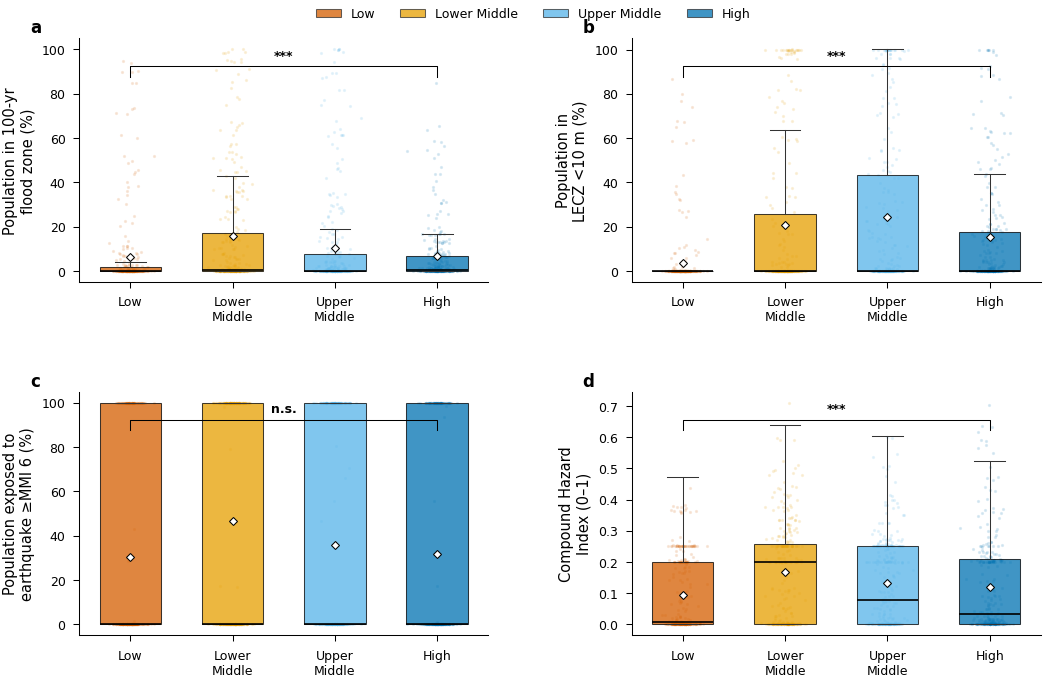


Generating Figure 2...

  LECZ regression (panel b):
    N = 1,945  |  R² = 0.1627  |  Adj. R² = 0.1579
    Kruskal-Wallis on residuals: H = 19.36, p = 2.30e-04
    Low            : median residual = -20.95  (IQR -40.57 to +7.85, n = 54)
    Lower Middle   : median residual = +10.60  (IQR -28.45 to +33.02, n = 606)
    Upper Middle   : median residual = -4.12  (IQR -29.78 to +34.19, n = 771)
    High           : median residual = -12.79  (IQR -25.91 to +9.73, n = 514)
  Saved: figures/Figure2_LECZ_vs_HDI.pdf, figures/Figure2_LECZ_vs_HDI.png


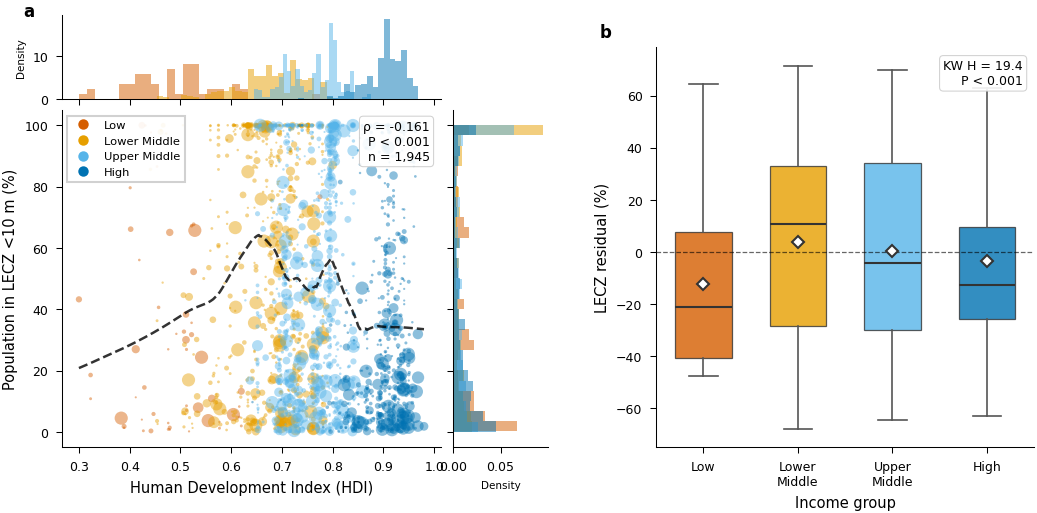


Generating Figure 3...
  Saved: figures/Figure3_hazard_HDI_heatmap.pdf, figures/Figure3_hazard_HDI_heatmap.png


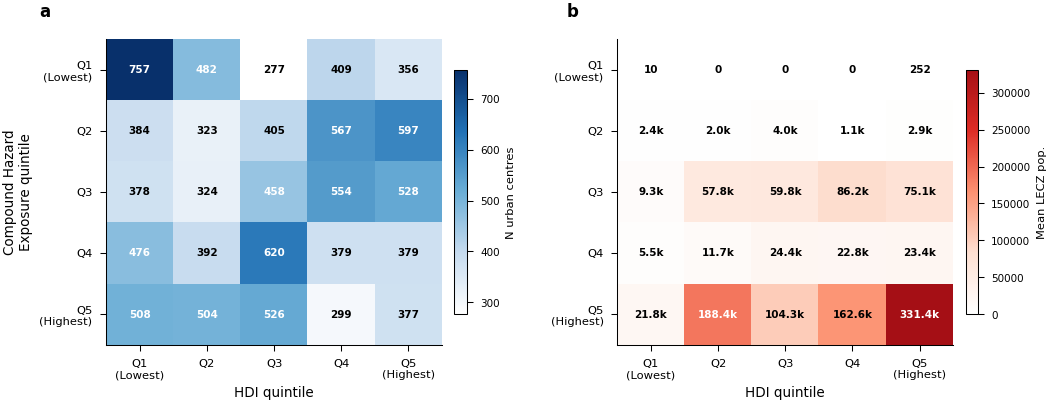


Generating Figure 4...
  Saved: figures/Figure4_demographics.pdf, figures/Figure4_demographics.png


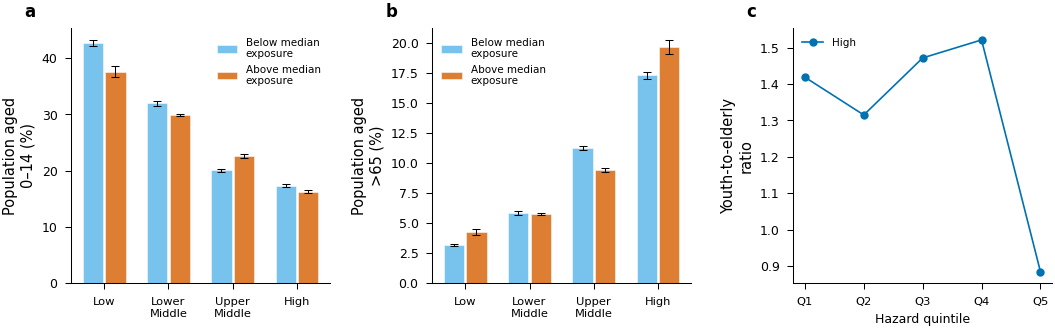


Generating Figure 5...
  Quantile regressions...
    τ=0.10 done
    τ=0.25 done
    τ=0.50 done
    τ=0.75 done
    τ=0.90 done
  Saved: figures/Figure5_quantile_regression.pdf, figures/Figure5_quantile_regression.png


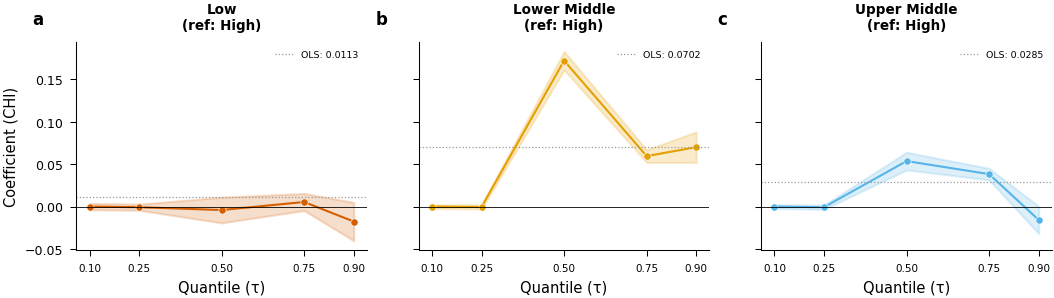


Running regressions...

REGRESSION RESULTS

                                                             (1) Bivariate (2) Controls (3) Region FE  (4) HDI  
----------------------------------------------------------------------------------------------------------------
Intercept                                                    0.1167***     0.3097***    0.3195***     0.3406*** 
                                                             (0.0037)      (0.0284)     (0.0316)      (0.0353)  
C(income_group, Treatment(reference="High"))[T.Low]          -0.0367***    0.0028       0.0008                  
                                                             (0.0051)      (0.0062)     (0.0080)                
C(income_group, Treatment(reference="High"))[T.Lower Middle] 0.0494***     0.0761***    -0.0001                 
                                                             (0.0044)      (0.0051)     (0.0069)                
C(income_group, Treatment(reference="High"))[T.Uppe

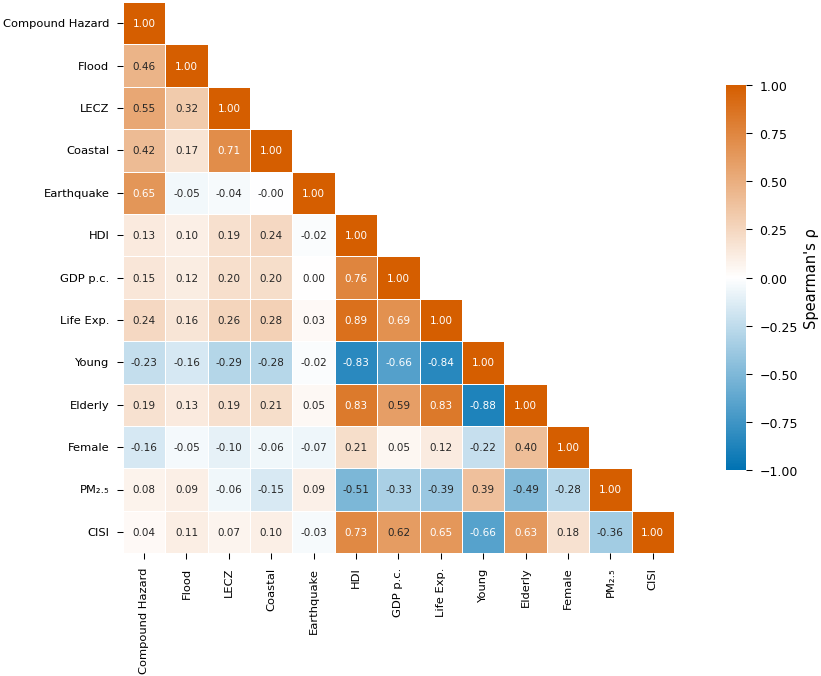


ANALYSIS COMPLETE

Outputs:
  figures/  Figure1–5 + ExtendedData_correlation_matrix (.pdf/.png)
  tables/   Table1, regression, regional, top50 (.csv/.xlsx)

Dataset: GHS-UCDB R2024A V1.1 (GeoPackage)
  doi: 10.2905/1a338be6-7eaf-480c-9664-3a8ade88cbcd



In [1]:
#!/usr/bin/env python3
"""
===============================================================================
Climate Justice & Urban Inequality: Global Analysis of 11,422 Urban Centres
===============================================================================
Target: Nature Climate Change (Analysis)
Dataset: GHS-UCDB R2024A V1.1 — GeoPackage (.gpkg)
===============================================================================
"""

# =============================================================================
# CELL 1: ENVIRONMENT SETUP
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap, Normalize, BoundaryNorm
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu, spearmanr, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import OrderedDict
import os

try:
    import geopandas as gpd
except ImportError:
    os.system('pip install geopandas pyogrio --quiet')
    import geopandas as gpd

print("All packages loaded.")

# =============================================================================
# CELL 2: NATURE CLIMATE CHANGE STYLE
# =============================================================================

MM_TO_INCH = 1 / 25.4
NATURE_SINGLE_COL = 89 * MM_TO_INCH
NATURE_DOUBLE_COL = 183 * MM_TO_INCH
NATURE_MAX_HEIGHT = 247 * MM_TO_INCH
FIGURE_DPI = 300

WONG_PALETTE = {
    'black': '#000000', 'orange': '#E69F00', 'sky_blue': '#56B4E9',
    'green': '#009E73', 'yellow': '#F0E442', 'blue': '#0072B2',
    'vermilion': '#D55E00', 'purple': '#CC79A7',
}

INCOME_COLORS = OrderedDict([
    ('Low',          WONG_PALETTE['vermilion']),
    ('Lower Middle', WONG_PALETTE['orange']),
    ('Upper Middle', WONG_PALETTE['sky_blue']),
    ('High',         WONG_PALETTE['blue']),
])
INCOME_ORDER = ['Low', 'Lower Middle', 'Upper Middle', 'High']

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 7, 'axes.labelsize': 7, 'axes.titlesize': 8,
    'axes.linewidth': 0.5, 'axes.labelpad': 3,
    'axes.spines.top': False, 'axes.spines.right': False,
    'xtick.labelsize': 6, 'ytick.labelsize': 6,
    'xtick.major.size': 3, 'xtick.major.width': 0.5,
    'ytick.major.size': 3, 'ytick.major.width': 0.5,
    'xtick.direction': 'out', 'ytick.direction': 'out',
    'legend.fontsize': 6, 'legend.frameon': False,
    'lines.linewidth': 0.8, 'lines.markersize': 3,
    'figure.dpi': 150, 'savefig.dpi': FIGURE_DPI,
    'savefig.bbox': 'tight', 'savefig.pad_inches': 0.02,
    'grid.linewidth': 0.3, 'grid.alpha': 0.3,
})


def add_panel_label(ax, label, x=-0.12, y=1.08):
    ax.text(x, y, label, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='left')


def save_figure(fig, filename, formats=('pdf', 'png')):
    os.makedirs('figures', exist_ok=True)
    for fmt in formats:
        fig.savefig(f'figures/{filename}.{fmt}', format=fmt, dpi=FIGURE_DPI,
                    bbox_inches='tight', pad_inches=0.02,
                    facecolor='white', edgecolor='none')
    print(f"  Saved: {', '.join(f'figures/{filename}.{f}' for f in formats)}")


print("Nature style configured.")

# =============================================================================
# CELL 3: DATA LOADING (GeoPackage — multi-layer)
# =============================================================================

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/GHS_UCDB_GLOBE_R2024A.gpkg'  # UPDATE IF NEEDED

if not os.path.exists(DATA_PATH):
    import glob
    matches = glob.glob('/content/drive/MyDrive/**/*.gpkg', recursive=True)
    if matches:
        DATA_PATH = matches[0]
        print(f"Auto-detected: {DATA_PATH}")
    else:
        raise FileNotFoundError("No .gpkg found. Upload and update DATA_PATH.")

print(f"File: {DATA_PATH} ({os.path.getsize(DATA_PATH)/1e6:.1f} MB)")

LAYERS_TO_LOAD = {
    'gc':   'GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A',
    'sc':   'GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A',
    'ex':   'GHS_UCDB_THEME_EXPOSURE_GLOBE_R2024A',
    'em':   'GHS_UCDB_THEME_EMISSIONS_GLOBE_R2024A',
    'hl':   'GHS_UCDB_THEME_HEALTH_GLOBE_R2024A',
    'infr': 'GHS_UCDB_THEME_INFRASTRUCTURES_GLOBE_R2024A',
}


def strip_bom(text):
    if isinstance(text, str):
        return text.replace('\ufeff', '').strip()
    return text


def load_gpkg_layer(path, layer_name, keep_geometry=False):
    gdf_layer = gpd.read_file(path, layer=layer_name)
    gdf_layer.columns = [strip_bom(c) for c in gdf_layer.columns]
    for col in gdf_layer.select_dtypes(include=['object']).columns:
        if col != 'geometry':
            gdf_layer[col] = gdf_layer[col].apply(strip_bom)
    if not keep_geometry and 'geometry' in gdf_layer.columns:
        gdf_layer = pd.DataFrame(gdf_layer.drop(columns='geometry'))
    return gdf_layer


print("\nLoading layers...\n")
raw = {}
for key, layer_name in LAYERS_TO_LOAD.items():
    print(f"  {key:5s} → {layer_name}...", end=' ', flush=True)
    raw[key] = load_gpkg_layer(DATA_PATH, layer_name, keep_geometry=(key == 'gc'))
    print(f"({raw[key].shape[0]:,} × {raw[key].shape[1]:,})")

print(f"\nAll layers loaded. Urban centres: {raw['gc'].shape[0]:,}")

# =============================================================================
# CELL 4: DATA PREPARATION
# =============================================================================

ID_COL = 'ID_UC_G0'


def find_col(dataframe, pattern, exclude=None):
    for c in sorted(dataframe.columns, reverse=True):
        if pattern.upper() in c.upper():
            if exclude and any(ex.upper() in c.upper() for ex in exclude):
                continue
            return c
    return None


# --- General Characteristics ---
gc = raw['gc']
gc_cols = {
    'name': find_col(gc, 'GC_UCN_MAI'),
    'country_gadm': find_col(gc, 'GC_CNT_GAD'),
    'country_un': find_col(gc, 'GC_CNT_UNN'),
    'area_km2': find_col(gc, 'GC_UCA_KM2'),
    'population': find_col(gc, 'GC_POP_TOT'),
    'income_group': find_col(gc, 'GC_DEV_WIG'),
    'sdg_region': find_col(gc, 'GC_DEV_USR'),
}

gc_select = [ID_COL] + [v for v in gc_cols.values() if v]
gc_rename = {ID_COL: 'id'}
gc_rename.update({v: k for k, v in gc_cols.items() if v})
df = gc[gc_select + ['geometry']].copy().rename(columns=gc_rename)

# --- Socioeconomic ---
sc = raw['sc']
sc_map = {
    'hdi':           find_col(sc, 'SC_SEC_HDI', exclude=['GDF', 'GDM']),
    'gdp_avg':       find_col(sc, 'SC_GDP_AVG'),
    'gdp_total':     find_col(sc, 'SC_GDP_SUM'),
    'life_exp':      find_col(sc, 'SC_SEC_LET', exclude=['LEF', 'LEM']),
    'schooling_exp': find_col(sc, 'SC_SEC_SET', exclude=['SEF', 'SEM']),
    'pct_young':     find_col(sc, 'SC_SEC_PCY'),
    'pct_adult':     find_col(sc, 'SC_SEC_PCA'),
    'pct_old':       find_col(sc, 'SC_SEC_PCO'),
    'pct_female':    find_col(sc, 'SC_SEC_PCF'),
    'pct_male':      find_col(sc, 'SC_SEC_PCM'),
    'gdi':           find_col(sc, 'SC_SEC_GDI', exclude=['GDF', 'GDM']),
}
sc_r = {v: k for k, v in sc_map.items() if v}
df = df.merge(sc[[ID_COL]+list(sc_r.keys())].rename(columns={**sc_r, ID_COL:'id'}),
              on='id', how='left')
print(f"Socioeconomic: {len(sc_r)}/{len(sc_map)}")

# --- Exposure ---
ex = raw['ex']
ex_map = {
    'pop_flood_100yr':            find_col(ex, 'EX_100_POP'),
    'pop_flood_10yr':             find_col(ex, 'EX_010_POP'),
    'share_pop_flood_100yr':      find_col(ex, 'EX_100_SHP'),
    'share_pop_flood_10yr':       find_col(ex, 'EX_010_SHP'),
    'pop_lecz_5m':                find_col(ex, 'EX_L05_POP'),
    'pop_lecz_10m':               find_col(ex, 'EX_L10_POP'),
    'share_pop_lecz_5m':          find_col(ex, 'EX_L05_SHP'),
    'share_pop_lecz_10m':         find_col(ex, 'EX_L10_SHP'),
    'share_pop_lecz_below10m':    find_col(ex, 'EX_LEC_SHP'),
    'builtup_lecz_5m':            find_col(ex, 'EX_L05_BUS', exclude=['B1', 'B2']),
    'pop_coastal_100yr':          find_col(ex, 'EX_CF1_POP'),
    'pop_coastal_20yr':           find_col(ex, 'EX_CF2_POP'),
    'share_pop_coastal_100yr':    find_col(ex, 'EX_CF1_SHP'),
    'share_pop_coastal_20yr':     find_col(ex, 'EX_CF2_SHP'),
    'share_pop_earthquake_mmi6':  find_col(ex, 'EX_SHA_POP'),
    'pop_cyclone_100yr':          find_col(ex, 'EX_100_S1P'),
    'pop_cyclone_400yr_ss3':      find_col(ex, 'EX_400_S3P'),
}
ex_r = {v: k for k, v in ex_map.items() if v}
df = df.merge(ex[[ID_COL]+list(ex_r.keys())].rename(columns={**ex_r, ID_COL:'id'}),
              on='id', how='left')
print(f"Exposure: {len(ex_r)}/{len(ex_map)}")

# --- Emissions ---
em = raw['em']
em_map = {
    'pm25_deaths':    find_col(em, 'EM_PM2_MOR'),
    'pm25_conc':      find_col(em, 'EM_PM2_CON'),
    'co2_total':      find_col(em, 'EM_CO2_TOT'),
    'co2_per_capita': find_col(em, 'EM_CO2_PEC'),
}
em_r = {v: k for k, v in em_map.items() if v}
if em_r:
    df = df.merge(em[[ID_COL]+list(em_r.keys())].rename(columns={**em_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Emissions: {len(em_r)}/{len(em_map)}")

# --- Health ---
hl = raw['hl']
hl_map = {
    'hospitals_per_cap':       find_col(hl, 'HL_FPC_HOS'),
    'share_pop_near_hospital': find_col(hl, 'HL_SHP_HOS'),
}
hl_r = {v: k for k, v in hl_map.items() if v}
if hl_r:
    df = df.merge(hl[[ID_COL]+list(hl_r.keys())].rename(columns={**hl_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Health: {len(hl_r)}/{len(hl_map)}")

# --- Infrastructure ---
infr = raw['infr']
infr_map = {
    'cisi_all':    find_col(infr, 'IN_CIS_ALL'),
    'cisi_energy': find_col(infr, 'IN_CIS_ENE'),
}
infr_r = {v: k for k, v in infr_map.items() if v}
if infr_r:
    df = df.merge(infr[[ID_COL]+list(infr_r.keys())].rename(columns={**infr_r, ID_COL:'id'}),
                  on='id', how='left')
print(f"Infrastructure: {len(infr_r)}/{len(infr_map)}")

# --- Numeric conversion ---
skip = {'id', 'name', 'country_gadm', 'country_un', 'income_group', 'sdg_region', 'geometry'}
for col in df.columns:
    if col not in skip:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Standardise income groups (BOM already stripped from values) ---
income_map = {
    'Low': 'Low', 'Low Income': 'Low', 'Low income': 'Low',
    'Lower Middle': 'Lower Middle', 'Lower Middle Income': 'Lower Middle',
    'Lower middle income': 'Lower Middle', 'Lower-middle income': 'Lower Middle',
    'Upper Middle': 'Upper Middle', 'Upper Middle Income': 'Upper Middle',
    'Upper middle income': 'Upper Middle', 'Upper-middle income': 'Upper Middle',
    'High': 'High', 'High Income': 'High', 'High income': 'High',
}
df['income_group'] = df['income_group'].map(
    lambda x: income_map.get(str(x).strip(), str(x).strip()) if pd.notna(x) else np.nan
)

print(f"\nIncome groups after standardisation:")
print(df['income_group'].value_counts(dropna=False))

# --- Derived variables ---
df['pop_density'] = df['population'] / df['area_km2'].replace(0, np.nan)

if 'pop_cyclone_100yr' in df.columns:
    df['share_pop_cyclone_100yr'] = (
        df['pop_cyclone_100yr'] / df['population'].replace(0, np.nan) * 100)
else:
    df['share_pop_cyclone_100yr'] = np.nan

df['pop_lecz_total'] = df.get('pop_lecz_5m', pd.Series(0, index=df.index)).fillna(0) + \
                        df.get('pop_lecz_10m', pd.Series(0, index=df.index)).fillna(0)

# --- Compound Hazard Exposure Index ---
hazard_vars = ['share_pop_flood_100yr', 'share_pop_lecz_below10m',
               'share_pop_coastal_100yr', 'share_pop_earthquake_mmi6',
               'share_pop_cyclone_100yr']

available_hazards = [v for v in hazard_vars if v in df.columns and df[v].notna().sum() > 100]
print(f"\nCompound Hazard Index ({len(available_hazards)}/{len(hazard_vars)}):")

for var in available_hazards:
    vals = df[var]
    vmin, vmax = vals.min(), vals.max()
    if pd.notna(vmin) and pd.notna(vmax) and vmax > vmin:
        df[f'{var}_norm'] = (vals - vmin) / (vmax - vmin)
    else:
        df[f'{var}_norm'] = 0.0
    print(f"  ✓ {var} (n={vals.notna().sum():,})")

norm_cols = [f'{v}_norm' for v in available_hazards]
df['compound_hazard_index'] = df[norm_cols].mean(axis=1, skipna=True)

# --- Quintiles ---
try:
    df['hdi_quintile'] = pd.qcut(df['hdi'], q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'], duplicates='drop')
except:
    df['hdi_quintile'] = pd.qcut(df['hdi'].rank(method='first'), q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])
try:
    df['hazard_quintile'] = pd.qcut(df['compound_hazard_index'], q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'], duplicates='drop')
except:
    df['hazard_quintile'] = pd.qcut(df['compound_hazard_index'].rank(method='first'), q=5,
        labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])

# --- Final sample ---
df_valid = df[df['income_group'].isin(INCOME_ORDER)].copy()

print(f"\n{'='*60}")
print(f"FINAL ANALYTICAL SAMPLE: {df_valid.shape[0]:,} urban centres")
print(f"{'='*60}")
for grp in INCOME_ORDER:
    print(f"  {grp:20s} {(df_valid['income_group'] == grp).sum():>6,}")

print(f"\nKey variable coverage (% non-missing):")
for v in ['hdi', 'gdp_avg', 'share_pop_flood_100yr', 'share_pop_lecz_below10m',
           'share_pop_coastal_100yr', 'share_pop_earthquake_mmi6',
           'pct_young', 'pct_old', 'pm25_conc', 'cisi_all', 'compound_hazard_index']:
    if v in df_valid.columns:
        print(f"  {v:35s} {df_valid[v].notna().mean()*100:6.1f}%")

# =============================================================================
# CELL 5: TABLE 1
# =============================================================================

def create_table1(data, income_order):
    variables = OrderedDict([
        ('population',              ('Population',                          ',.0f')),
        ('area_km2',                ('Area (km²)',                          ',.1f')),
        ('pop_density',             ('Pop. density (per km²)',              ',.0f')),
        ('hdi',                     ('HDI',                                 '.3f')),
        ('gdp_avg',                 ('GDP per capita (PPP)',                ',.0f')),
        ('life_exp',                ('Life expectancy (yr)',                '.1f')),
        ('schooling_exp',           ('Expected schooling (yr)',             '.1f')),
        ('pct_young',               ('Pop. 0–14 (%)',                      '.1f')),
        ('pct_old',                 ('Pop. >65 (%)',                        '.1f')),
        ('pct_female',              ('Female pop. (%)',                     '.1f')),
        ('share_pop_flood_100yr',   ('Pop. 100-yr flood (%)',              '.1f')),
        ('share_pop_lecz_below10m', ('Pop. LECZ <10 m (%)',               '.1f')),
        ('share_pop_coastal_100yr', ('Pop. coastal flood (%)',             '.1f')),
        ('share_pop_earthquake_mmi6', ('Pop. earthquake ≥MMI 6 (%)',      '.1f')),
        ('share_pop_cyclone_100yr', ('Pop. cyclone (%)',                   '.1f')),
        ('compound_hazard_index',   ('Compound Hazard Index',              '.3f')),
        ('pm25_conc',               ('PM₂.₅ (µg/m³)',                     '.1f')),
        ('cisi_all',                ('CISI',                               '.3f')),
        ('share_pop_near_hospital', ('Pop. near hospital (%)',             '.1f')),
    ])
    variables = OrderedDict((k, v) for k, v in variables.items() if k in data.columns)

    rows = [{'Variable': 'N (urban centres)',
             **{g: f"{(data['income_group']==g).sum():,}" for g in income_order},
             'All': f"{data.shape[0]:,}", 'p-value': ''}]

    for var_name, (label, fmt) in variables.items():
        row = {'Variable': label}
        gvals = []
        for grp in income_order:
            gd = data.loc[data['income_group'] == grp, var_name].dropna()
            gvals.append(gd)
            if len(gd) > 0:
                m, q1, q3 = gd.median(), gd.quantile(0.25), gd.quantile(0.75)
                row[grp] = f"{m:{fmt}} ({q1:{fmt}}–{q3:{fmt}})"
            else:
                row[grp] = '—'
        ad = data[var_name].dropna()
        if len(ad) > 0:
            m, q1, q3 = ad.median(), ad.quantile(0.25), ad.quantile(0.75)
            row['All'] = f"{m:{fmt}} ({q1:{fmt}}–{q3:{fmt}})"
        else:
            row['All'] = '—'
        vg = [g for g in gvals if len(g) >= 5]
        if len(vg) >= 2:
            try:
                _, p = kruskal(*vg)
                row['p-value'] = '<0.001' if p < 0.001 else f"{p:.3f}"
            except:
                row['p-value'] = '—'
        else:
            row['p-value'] = '—'
        rows.append(row)

    return pd.DataFrame(rows)[['Variable'] + income_order + ['All', 'p-value']]


table1 = create_table1(df_valid, INCOME_ORDER)
print("\n" + "="*100)
print("TABLE 1: Descriptive statistics by World Bank income group")
print("="*100)
print(table1.to_string(index=False))
os.makedirs('tables', exist_ok=True)
table1.to_csv('tables/Table1_descriptive_stats.csv', index=False)
table1.to_excel('tables/Table1_descriptive_stats.xlsx', index=False)
print("  Saved: tables/Table1_descriptive_stats.csv/.xlsx")

# =============================================================================
# CELL 6: FIGURE 1 — MULTI-HAZARD EXPOSURE
# =============================================================================

def figure1_multihazard(data, income_order, income_colors):
    fig = plt.figure(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.65))
    gs = gridspec.GridSpec(2, 2, hspace=0.45, wspace=0.35,
                           left=0.08, right=0.97, top=0.93, bottom=0.08)
    panels = {
        'a': ('share_pop_flood_100yr', 'Population in 100-yr\nflood zone (%)'),
        'b': ('share_pop_lecz_below10m', 'Population in\nLECZ <10 m (%)'),
        'c': ('share_pop_earthquake_mmi6', 'Population exposed to\nearthquake ≥MMI 6 (%)'),
        'd': ('compound_hazard_index', 'Compound Hazard\nIndex (0–1)'),
    }
    for idx, (label, (var, ylabel)) in enumerate(panels.items()):
        ax = fig.add_subplot(gs[idx // 2, idx % 2])
        if var not in data.columns or data[var].notna().sum() < 10:
            ax.text(0.5, 0.5, f'{var}\nnot available', transform=ax.transAxes,
                   ha='center', va='center', fontsize=6, color='grey')
            add_panel_label(ax, label); continue

        plot_data = [data.loc[data['income_group'] == g, var].dropna() for g in income_order]
        bp = ax.boxplot(plot_data, positions=range(len(income_order)), widths=0.6,
            patch_artist=True, showfliers=False, showmeans=True,
            meanprops=dict(marker='D', markerfacecolor='white',
                          markeredgecolor='black', markersize=2.5, markeredgewidth=0.5),
            medianprops=dict(color='black', linewidth=0.8),
            whiskerprops=dict(linewidth=0.5, color='#333333'),
            capprops=dict(linewidth=0.5, color='#333333'),
            boxprops=dict(linewidth=0.5))

        for patch, grp in zip(bp['boxes'], income_order):
            patch.set_facecolor(income_colors[grp]); patch.set_alpha(0.75)

        rng = np.random.default_rng(42)
        for i, grp in enumerate(income_order):
            vals = data.loc[data['income_group'] == grp, var].dropna()
            n_plot = min(300, len(vals))
            if n_plot > 0:
                vs = vals.sample(n=n_plot, random_state=42) if len(vals) > n_plot else vals
                ax.scatter(i + rng.normal(0, 0.08, len(vs)), vs, s=0.3, alpha=0.15,
                          color=income_colors[grp], zorder=1, rasterized=True)

        ax.set_xticks(range(len(income_order)))
        short_labels = ['Low', 'Lower\nMiddle', 'Upper\nMiddle', 'High']
        ax.set_xticklabels(short_labels, rotation=0, ha='center')
        ax.set_ylabel(ylabel)

        gl = data.loc[data['income_group'] == 'Low', var].dropna()
        gh = data.loc[data['income_group'] == 'High', var].dropna()
        if len(gl) > 5 and len(gh) > 5:
            _, pv = mannwhitneyu(gl, gh, alternative='two-sided')
            sig = '***' if pv < 0.001 else ('**' if pv < 0.01 else ('*' if pv < 0.05 else 'n.s.'))
            yb = ax.get_ylim()[1] * 0.88
            ax.plot([0, 0, 3, 3], [yb*0.95, yb, yb, yb*0.95], lw=0.5, color='black')
            ax.text(1.5, yb * 1.02, sig, ha='center', va='bottom', fontsize=6, fontweight='bold')
        add_panel_label(ax, label)

    legend_el = [mpatches.Patch(facecolor=income_colors[g], alpha=0.75,
                 edgecolor='#333333', linewidth=0.5, label=g) for g in income_order]
    fig.legend(handles=legend_el, loc='upper center', ncol=4, fontsize=6,
              frameon=False, bbox_to_anchor=(0.5, 0.99))
    save_figure(fig, 'Figure1_multihazard_exposure')
    plt.show()
    return fig

print("\nGenerating Figure 1...")
fig1 = figure1_multihazard(df_valid, INCOME_ORDER, INCOME_COLORS)

# =============================================================================
# CELL 7: FIGURE 2 — LECZ vs HDI (panel a) + Regression residuals (panel b)
# =============================================================================

def figure2_lecz_hdi(data, income_colors):
    mask = (data['share_pop_lecz_below10m'].notna() &
            (data['share_pop_lecz_below10m'] > 0) & data['hdi'].notna())
    pdf = data[mask].copy()
    if len(pdf) < 50:
        print("  Warning: Too few cities for Figure 2"); return None

    # -------------------------------------------------------------------
    # Layout: panel (a) scatter with marginals on left; panel (b) box on right
    # Use a wide figure with two major column blocks
    # -------------------------------------------------------------------
    fig = plt.figure(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.50))

    # Left block: scatter (a) with top and right marginals
    gs_left = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                                hspace=0.05, wspace=0.05,
                                left=0.07, right=0.52, top=0.92, bottom=0.12)
    ax_m = fig.add_subplot(gs_left[1, 0])
    ax_t = fig.add_subplot(gs_left[0, 0], sharex=ax_m)
    ax_r = fig.add_subplot(gs_left[1, 1], sharey=ax_m)

    # Right block: residual box plot (b)
    gs_right = gridspec.GridSpec(1, 1, left=0.62, right=0.97, top=0.86, bottom=0.12)
    ax_b = fig.add_subplot(gs_right[0, 0])

    # ===================================================================
    # PANEL (a): LECZ scatter with LOWESS and marginal histograms
    # ===================================================================
    for grp in INCOME_ORDER:
        gd = pdf[pdf['income_group'] == grp]
        if len(gd) == 0: continue
        sizes = np.clip(gd['population'] / 50000, 1, 40)
        ax_m.scatter(gd['hdi'], gd['share_pop_lecz_below10m'], s=sizes, alpha=0.45,
                    color=income_colors[grp], label=grp, edgecolors='none', rasterized=True)

    valid = pdf[['hdi', 'share_pop_lecz_below10m']].dropna()
    if len(valid) > 50:
        sm_out = lowess(valid['share_pop_lecz_below10m'], valid['hdi'], frac=0.3, return_sorted=True)
        ax_m.plot(sm_out[:, 0], sm_out[:, 1], color='black', lw=1.2, ls='--', zorder=5, alpha=0.8)

    ax_m.set_xlabel('Human Development Index (HDI)')
    ax_m.set_ylabel('Population in LECZ <10 m (%)')
    rho, pr = spearmanr(valid['hdi'], valid['share_pop_lecz_below10m'])
    pt = 'P < 0.001' if pr < 0.001 else f'P = {pr:.3f}'
    ax_m.text(0.97, 0.97, f'ρ = {rho:.3f}\n{pt}\nn = {len(valid):,}',
             transform=ax_m.transAxes, fontsize=6, va='top', ha='right',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                      edgecolor='#ccc', alpha=0.9, linewidth=0.5))

    # Marginal histograms
    for grp in INCOME_ORDER:
        v = pdf.loc[pdf['income_group'] == grp, 'hdi'].dropna()
        if len(v) > 5: ax_t.hist(v, bins=30, alpha=0.5, color=income_colors[grp], density=True, edgecolor='none')
    ax_t.set_ylabel('Density', fontsize=5); ax_t.tick_params(labelbottom=False)

    for grp in INCOME_ORDER:
        v = pdf.loc[pdf['income_group'] == grp, 'share_pop_lecz_below10m'].dropna()
        if len(v) > 5: ax_r.hist(v, bins=30, alpha=0.5, color=income_colors[grp], density=True, orientation='horizontal', edgecolor='none')
    ax_r.set_xlabel('Density', fontsize=5); ax_r.tick_params(labelleft=False)

    leg = [Line2D([0], [0], marker='o', color='w', markerfacecolor=income_colors[g],
                  markersize=5, label=g, markeredgewidth=0) for g in INCOME_ORDER]
    ax_m.legend(handles=leg, loc='upper left', fontsize=5.5, frameon=True,
               fancybox=False, edgecolor='#ccc', framealpha=0.9)

    add_panel_label(ax_t, 'a', x=-0.10, y=1.15)

    # ===================================================================
    # PANEL (b): LECZ regression residuals by income group
    # ===================================================================
    # Prepare regression data: LECZ share ~ HDI + log_pop + log_area + region FE
    # Restricted to coastal cities (LECZ > 0) with complete cases
    reg_cols = ['share_pop_lecz_below10m', 'hdi', 'population', 'area_km2',
                'sdg_region', 'income_group']
    rd = pdf[reg_cols].dropna().copy()
    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])

    if len(rd) >= 100:
        lecz_model = smf.ols(
            'share_pop_lecz_below10m ~ hdi + log_pop + log_area + C(sdg_region)',
            data=rd).fit(cov_type='HC3')
        rd['residual'] = lecz_model.resid

        # Print model summary for reference
        print(f"\n  LECZ regression (panel b):")
        print(f"    N = {int(lecz_model.nobs):,}  |  R² = {lecz_model.rsquared:.4f}  "
              f"|  Adj. R² = {lecz_model.rsquared_adj:.4f}")

        # Box plot of residuals by income group
        box_data = [rd.loc[rd['income_group'] == grp, 'residual'].values
                    for grp in INCOME_ORDER]
        bp = ax_b.boxplot(box_data, patch_artist=True, widths=0.6,
                          showfliers=False, showmeans=True,
                          meanprops=dict(marker='D', markerfacecolor='white',
                                        markeredgecolor='#333', markersize=4),
                          medianprops=dict(color='#333', linewidth=1.0),
                          whiskerprops=dict(color='#555', linewidth=0.8),
                          capprops=dict(color='#555', linewidth=0.8))
        for patch, grp in zip(bp['boxes'], INCOME_ORDER):
            patch.set_facecolor(income_colors[grp])
            patch.set_alpha(0.8)
            patch.set_edgecolor('#333')
            patch.set_linewidth(0.6)

        ax_b.set_xticklabels(['Low', 'Lower\nMiddle', 'Upper\nMiddle', 'High'], fontsize=6)
        ax_b.set_ylabel('LECZ residual (%)')
        ax_b.set_xlabel('Income group')
        ax_b.axhline(0, color='black', linewidth=0.6, linestyle='--', alpha=0.6)

        # Kruskal-Wallis test on residuals across income groups
        from scipy.stats import kruskal
        groups_resid = [rd.loc[rd['income_group'] == g, 'residual'].dropna().values
                        for g in INCOME_ORDER if len(rd.loc[rd['income_group'] == g, 'residual'].dropna()) > 0]
        if len(groups_resid) >= 2:
            kw_h, kw_p = kruskal(*groups_resid)
            pt_kw = 'P < 0.001' if kw_p < 0.001 else f'P = {kw_p:.3f}'
            ax_b.text(0.97, 0.97, f'KW H = {kw_h:.1f}\n{pt_kw}',
                     transform=ax_b.transAxes, fontsize=6, va='top', ha='right',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                              edgecolor='#ccc', alpha=0.9, linewidth=0.5))
            print(f"    Kruskal-Wallis on residuals: H = {kw_h:.2f}, p = {kw_p:.2e}")

        # Print median residuals per group
        for grp in INCOME_ORDER:
            gv = rd.loc[rd['income_group'] == grp, 'residual']
            print(f"    {grp:15s}: median residual = {gv.median():+.2f}  "
                  f"(IQR {gv.quantile(0.25):+.2f} to {gv.quantile(0.75):+.2f}, n = {len(gv):,})")

    else:
        ax_b.text(0.5, 0.5, 'Insufficient data\nfor regression',
                 transform=ax_b.transAxes, ha='center', va='center', fontsize=7)

    add_panel_label(ax_b, 'b', x=-0.15, y=1.06)

    save_figure(fig, 'Figure2_LECZ_vs_HDI')
    plt.show()
    return fig

print("\nGenerating Figure 2...")
fig2 = figure2_lecz_hdi(df_valid, INCOME_COLORS)

# =============================================================================
# CELL 8: FIGURE 3 — HAZARD × HDI HEATMAP
# =============================================================================

def figure3_heatmap(data):
    mask = data['hdi_quintile'].notna() & data['hazard_quintile'].notna()
    sub = data[mask].copy()
    if len(sub) < 100:
        print("  Warning: Too few for Figure 3"); return None

    ct_n = pd.crosstab(sub['hazard_quintile'], sub['hdi_quintile'])
    ct_p = sub.groupby(['hazard_quintile', 'hdi_quintile'])['pop_lecz_total'].mean().unstack(fill_value=0)
    ct_p = ct_p.reindex(index=ct_n.index, columns=ct_n.columns, fill_value=0)

    fig, axes = plt.subplots(1, 2, figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.4))

    cmap_a = LinearSegmentedColormap.from_list('c', ['#FFF', '#C6DBEF', '#6BAED6', '#2171B5', '#08306B'])
    im = axes[0].imshow(ct_n.values, cmap=cmap_a, aspect='auto')
    for i in range(ct_n.shape[0]):
        for j in range(ct_n.shape[1]):
            v = ct_n.values[i, j]
            axes[0].text(j, i, f'{v:,}', ha='center', va='center', fontsize=5,
                        color='white' if v > ct_n.values.max()*0.6 else 'black', fontweight='bold')
    axes[0].set_xticks(range(ct_n.shape[1])); axes[0].set_xticklabels(ct_n.columns, fontsize=5.5)
    axes[0].set_yticks(range(ct_n.shape[0])); axes[0].set_yticklabels(ct_n.index, fontsize=5.5)
    axes[0].set_xlabel('HDI quintile', fontsize=6.5)
    axes[0].set_ylabel('Compound Hazard\nExposure quintile', fontsize=6.5)
    cb = fig.colorbar(im, ax=axes[0], shrink=0.8, pad=0.03)
    cb.ax.tick_params(labelsize=5); cb.set_label('N urban centres', fontsize=5.5)
    add_panel_label(axes[0], 'a', x=-0.2, y=1.12)

    cmap_b = LinearSegmentedColormap.from_list('p', ['#FFF', '#FEE0D2', '#FC9272', '#DE2D26', '#A50F15'])
    im2 = axes[1].imshow(ct_p.values, cmap=cmap_b, aspect='auto')
    for i in range(ct_p.shape[0]):
        for j in range(ct_p.shape[1]):
            v = ct_p.values[i, j]
            lb = f'{v/1000:.1f}k' if v >= 1000 else f'{v:.0f}'
            axes[1].text(j, i, lb, ha='center', va='center', fontsize=5,
                        color='white' if v > ct_p.values.max()*0.5 else 'black', fontweight='bold')
    axes[1].set_xticks(range(ct_p.shape[1])); axes[1].set_xticklabels(ct_p.columns, fontsize=5.5)
    axes[1].set_yticks(range(ct_p.shape[0])); axes[1].set_yticklabels(ct_p.index, fontsize=5.5)
    axes[1].set_xlabel('HDI quintile', fontsize=6.5); axes[1].set_ylabel('')
    cb2 = fig.colorbar(im2, ax=axes[1], shrink=0.8, pad=0.03)
    cb2.ax.tick_params(labelsize=5); cb2.set_label('Mean LECZ pop.', fontsize=5.5)
    add_panel_label(axes[1], 'b', x=-0.15, y=1.12)

    plt.tight_layout(w_pad=2)
    save_figure(fig, 'Figure3_hazard_HDI_heatmap')
    plt.show()
    return fig

print("\nGenerating Figure 3...")
fig3 = figure3_heatmap(df_valid)

# =============================================================================
# CELL 9: FIGURE 4 — DEMOGRAPHICS
# =============================================================================

def figure4_demographics(data, income_order, income_colors):
    med_haz = data['compound_hazard_index'].median()
    data = data.copy()
    data['high_exp'] = data['compound_hazard_index'] >= med_haz

    fig, axes = plt.subplots(1, 3, figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.33))
    bw = 0.35
    x = np.arange(len(income_order))

    for ai, (ax, var, yl) in enumerate(zip(
        axes[:2], ['pct_young', 'pct_old'],
        ['Population aged\n0–14 (%)', 'Population aged\n>65 (%)']
    )):
        if var not in data.columns:
            ax.text(0.5, 0.5, 'N/A', transform=ax.transAxes, ha='center', fontsize=6)
            add_panel_label(ax, chr(97+ai)); continue
        for i, (el, ev) in enumerate([('Below median\nexposure', False),
                                       ('Above median\nexposure', True)]):
            means, cis = [], []
            for grp in income_order:
                v = data.loc[(data['income_group']==grp) & (data['high_exp']==ev), var].dropna()
                means.append(v.mean() if len(v) > 0 else 0)
                cis.append(1.96 * v.std()/np.sqrt(len(v)) if len(v) > 1 else 0)
            off = -bw/2 + i*bw
            col = WONG_PALETTE['sky_blue'] if not ev else WONG_PALETTE['vermilion']
            ax.bar(x+off, means, bw*0.9, yerr=cis, label=el, color=col, alpha=0.8,
                   edgecolor='white', linewidth=0.3, error_kw=dict(lw=0.5, capsize=2, capthick=0.5))
        short_labels = ['Low', 'Lower\nMiddle', 'Upper\nMiddle', 'High']
        ax.set_xticks(x); ax.set_xticklabels(short_labels, fontsize=5.5)
        ax.set_ylabel(yl)
        ax.legend(fontsize=5, loc='upper right' if ai==0 else 'upper left')
        add_panel_label(ax, chr(97+ai), x=-0.18, y=1.1)

    ax = axes[2]
    if 'pct_young' in data.columns and 'pct_old' in data.columns:
        data['yer'] = data['pct_young'] / data['pct_old'].replace(0, np.nan)
        for grp in income_order:
            gd = data[data['income_group'] == grp].copy()
            try:
                gd['hq'] = pd.qcut(gd['compound_hazard_index'], q=5, labels=[1,2,3,4,5], duplicates='drop')
                m = gd.groupby('hq')['yer'].mean()
                ax.plot(m.index.astype(int), m.values, marker='o', markersize=3, lw=0.8,
                       color=income_colors[grp], label=grp)
            except: continue
        ax.set_xlabel('Hazard quintile', fontsize=6)
        ax.set_ylabel('Youth-to-elderly\nratio')
        ax.set_xticks([1,2,3,4,5]); ax.set_xticklabels(['Q1','Q2','Q3','Q4','Q5'], fontsize=5.5)
        ax.legend(fontsize=5, loc='upper left')
    add_panel_label(ax, 'c', x=-0.18, y=1.1)
    plt.tight_layout(w_pad=1.5)
    save_figure(fig, 'Figure4_demographics')
    plt.show()
    return fig

print("\nGenerating Figure 4...")
fig4 = figure4_demographics(df_valid, INCOME_ORDER, INCOME_COLORS)

# =============================================================================
# CELL 10: FIGURE 5 — QUANTILE REGRESSION
# =============================================================================

def figure5_quantile_regression(data, income_order):
    rd = data[['compound_hazard_index', 'income_group', 'area_km2', 'population']].dropna().copy()
    if len(rd) < 100:
        print("  Too few obs"); return None, {}

    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])
    rd = pd.get_dummies(rd, columns=['income_group'], drop_first=False, dtype=float)

    dummies = [f'income_group_{g}' for g in income_order if g != 'High'
               and f'income_group_{g}' in rd.columns]
    if not dummies:
        print("  No income dummies"); return None, {}

    X = sm.add_constant(rd[dummies + ['log_pop', 'log_area']].astype(float))
    y = rd['compound_hazard_index'].astype(float)

    quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
    results = {q: {} for q in quantiles}
    print("  Quantile regressions...")
    for q in quantiles:
        try:
            res = QuantReg(y, X).fit(q=q, max_iter=5000)
            for d in dummies:
                gl = d.replace('income_group_', '')
                results[q][gl] = {'coef': res.params[d],
                    'ci_low': res.conf_int().loc[d, 0],
                    'ci_high': res.conf_int().loc[d, 1]}
            print(f"    τ={q:.2f} done")
        except Exception as e:
            print(f"    τ={q:.2f} failed: {e}")

    ols = sm.OLS(y, X).fit(cov_type='HC3')

    grps = [g for g in ['Low', 'Lower Middle', 'Upper Middle']
            if f'income_group_{g}' in rd.columns]
    fig, axes = plt.subplots(1, len(grps),
                              figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL*0.3), sharey=True)
    if len(grps) == 1: axes = [axes]

    for idx, grp in enumerate(grps):
        ax = axes[idx]
        col = INCOME_COLORS.get(grp, '#333')
        coefs = [results[q].get(grp, {}).get('coef', np.nan) for q in quantiles]
        cil = [results[q].get(grp, {}).get('ci_low', np.nan) for q in quantiles]
        cih = [results[q].get(grp, {}).get('ci_high', np.nan) for q in quantiles]
        ax.fill_between(quantiles, cil, cih, alpha=0.2, color=col)
        ax.plot(quantiles, coefs, 'o-', color=col, markersize=3.5, lw=1,
               markeredgecolor='white', markeredgewidth=0.3)
        dn = f'income_group_{grp}'
        if dn in ols.params.index:
            ax.axhline(ols.params[dn], color='#999', ls=':', lw=0.6,
                      label=f'OLS: {ols.params[dn]:.4f}')
        ax.axhline(0, color='black', lw=0.4)
        ax.set_xlabel('Quantile (τ)')
        ax.set_title(f'{grp}\n(ref: High)', fontsize=6.5, fontweight='bold')
        ax.set_xticks(quantiles)
        ax.set_xticklabels([f'{q:.2f}' for q in quantiles], fontsize=5)
        if idx == 0: ax.set_ylabel('Coefficient (CHI)')
        ax.legend(fontsize=4.5, loc='best')
        add_panel_label(ax, chr(97+idx), x=-0.15, y=1.15)

    plt.tight_layout(w_pad=1)
    save_figure(fig, 'Figure5_quantile_regression')
    plt.show()
    return fig, results

print("\nGenerating Figure 5...")
fig5, qreg = figure5_quantile_regression(df_valid, INCOME_ORDER)

# =============================================================================
# CELL 11: REGRESSION TABLE
# =============================================================================

def run_regressions(data):
    rd = data[['compound_hazard_index', 'income_group', 'sdg_region',
               'area_km2', 'population', 'hdi']].dropna().copy()
    if len(rd) < 100:
        print("  Too few obs"); return {}
    rd['log_pop'] = np.log1p(rd['population'])
    rd['log_area'] = np.log1p(rd['area_km2'])

    m1 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))',
                  data=rd).fit(cov_type='HC3')
    m2 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area', data=rd).fit(cov_type='HC3')
    m3 = smf.ols('compound_hazard_index ~ C(income_group, Treatment(reference="High"))'
                  ' + log_pop + log_area + C(sdg_region)', data=rd).fit(cov_type='HC3')
    m4 = smf.ols('compound_hazard_index ~ hdi + log_pop + log_area',
                  data=rd).fit(cov_type='HC3')

    print("\n" + "="*80)
    print("REGRESSION RESULTS")
    print("="*80)
    from statsmodels.iolib.summary2 import summary_col
    s = summary_col([m1, m2, m3, m4],
        model_names=['(1) Bivariate', '(2) Controls', '(3) Region FE', '(4) HDI'],
        stars=True, info_dict={
            'N': lambda x: f"{int(x.nobs):,}",
            'R²': lambda x: f"{x.rsquared:.4f}",
            'Adj. R²': lambda x: f"{x.rsquared_adj:.4f}"})
    print(s)
    s.tables[0].to_csv('tables/regression_results.csv')
    print("  Saved: tables/regression_results.csv")
    return {'m1': m1, 'm2': m2, 'm3': m3, 'm4': m4}

print("\nRunning regressions...")
reg_models = run_regressions(df_valid)

# =============================================================================
# CELL 12: EXTENDED DATA — REGIONAL
# =============================================================================

def extended_regional(data):
    regions = sorted(data['sdg_region'].dropna().unique())
    vm = {'compound_hazard_index': 'CHI', 'share_pop_flood_100yr': 'Flood',
          'share_pop_lecz_below10m': 'LECZ', 'hdi': 'HDI',
          'pct_young': 'Young', 'pct_old': 'Old'}
    vm = {k: v for k, v in vm.items() if k in data.columns}
    rows = []
    for r in regions:
        rd = data[data['sdg_region'] == r]
        row = {'Region': r, 'N': rd.shape[0]}
        for var, lbl in vm.items():
            v = rd[var].dropna()
            if len(v) > 0:
                row[f'{lbl} med'] = f"{v.median():.3f}"
                row[f'{lbl} IQR'] = f"{v.quantile(0.25):.3f}–{v.quantile(0.75):.3f}"
            else:
                row[f'{lbl} med'] = '—'; row[f'{lbl} IQR'] = '—'
        rows.append(row)
    ed = pd.DataFrame(rows)
    ed.to_csv('tables/ExtendedData_regional.csv', index=False)
    ed.to_excel('tables/ExtendedData_regional.xlsx', index=False)
    print("  Saved: tables/ExtendedData_regional.csv/.xlsx")
    return ed

print("\nExtended Data: Regional...")
ed_reg = extended_regional(df_valid)
print(ed_reg[['Region', 'N']].to_string(index=False))

# =============================================================================
# CELL 13: TOP 50 EXPOSED LOW-INCOME CITIES
# =============================================================================

def top50_exposed(data):
    low = data[data['income_group'].isin(['Low', 'Lower Middle'])]
    top = low.nlargest(50, 'compound_hazard_index')
    cols = ['name', 'country_gadm', 'income_group', 'population', 'hdi',
            'compound_hazard_index', 'share_pop_flood_100yr',
            'share_pop_lecz_below10m', 'share_pop_earthquake_mmi6', 'pct_young', 'pct_old']
    avail = [c for c in cols if c in top.columns]
    result = top[avail].reset_index(drop=True)
    result.index = result.index + 1; result.index.name = 'Rank'
    result.to_csv('tables/ExtendedData_top50.csv')
    result.to_excel('tables/ExtendedData_top50.xlsx')
    print("  Saved: tables/ExtendedData_top50.csv/.xlsx")
    return result

print("\nTop 50 exposed low-income cities...")
top50 = top50_exposed(df_valid)
print(top50.head(10).to_string())

# =============================================================================
# CELL 14: ROBUSTNESS CHECKS
# =============================================================================

def robustness_checks(data, income_order):
    print("\n" + "="*80)
    print("ROBUSTNESS CHECKS")
    print("="*80)

    # 1. Pop threshold
    print("\n--- Check 1: Pop ≥ 50,000 ---")
    sub = data[data['population'] >= 50000]
    print(f"  N = {sub.shape[0]:,}")
    for g in income_order:
        v = sub.loc[sub['income_group']==g, 'compound_hazard_index'].dropna()
        if len(v) > 0: print(f"  {g}: median CHI = {v.median():.4f}")
    vg = [sub.loc[sub['income_group']==g, 'compound_hazard_index'].dropna() for g in income_order]
    vg = [g for g in vg if len(g) >= 5]
    if len(vg) >= 2:
        h, p = kruskal(*vg); print(f"  KW: H={h:.2f}, p={p:.2e}")

    # 2. GDP quintiles
    print("\n--- Check 2: GDP quintiles ---")
    if 'gdp_avg' in data.columns:
        sub = data[data['gdp_avg'].notna()].copy()
        try:
            sub['gq'] = pd.qcut(sub['gdp_avg'], q=5, labels=['Q1','Q2','Q3','Q4','Q5'], duplicates='drop')
            for q in sub['gq'].cat.categories:
                v = sub.loc[sub['gq']==q, 'compound_hazard_index'].dropna()
                print(f"  {q}: median CHI = {v.median():.4f}, n={len(v):,}")
        except Exception as e: print(f"  Skipped: {e}")

    # 3. LECZ 5m
    print("\n--- Check 3: LECZ 5m ---")
    if 'share_pop_lecz_5m' in data.columns:
        for g in income_order:
            v = data.loc[data['income_group']==g, 'share_pop_lecz_5m'].dropna()
            if len(v) > 0: print(f"  {g}: median = {v.median():.2f}%")

    # 4. Geometric mean
    print("\n--- Check 4: Geometric mean ---")
    nc = [c for c in data.columns if c.endswith('_norm')]
    if nc:
        eps = 1e-6
        dc = data.copy()
        dc['chi_geo'] = np.exp(dc[nc].apply(lambda x: np.log(x + eps)).mean(axis=1))
        vp = dc[['compound_hazard_index', 'chi_geo']].dropna()
        if len(vp) > 50:
            rho, p = spearmanr(vp['compound_hazard_index'], vp['chi_geo'])
            print(f"  Spearman ρ = {rho:.4f}, p = {p:.2e}")

robustness_checks(df_valid, INCOME_ORDER)

# =============================================================================
# CELL 15: CORRELATION MATRIX
# =============================================================================

def extended_correlation(data):
    cv = {'compound_hazard_index': 'Compound Hazard',
          'share_pop_flood_100yr': 'Flood', 'share_pop_lecz_below10m': 'LECZ',
          'share_pop_coastal_100yr': 'Coastal', 'share_pop_earthquake_mmi6': 'Earthquake',
          'hdi': 'HDI', 'gdp_avg': 'GDP p.c.', 'life_exp': 'Life Exp.',
          'pct_young': 'Young', 'pct_old': 'Elderly', 'pct_female': 'Female',
          'pm25_conc': 'PM₂.₅', 'cisi_all': 'CISI'}
    av = {k: v for k, v in cv.items() if k in data.columns}
    sub = data[list(av.keys())].dropna()
    if len(sub) < 50:
        print("  Too few obs for correlation"); return None

    corr = sub.corr(method='spearman')
    corr.index = [av[c] for c in corr.index]
    corr.columns = [av[c] for c in corr.columns]

    fig, ax = plt.subplots(figsize=(NATURE_DOUBLE_COL, NATURE_DOUBLE_COL * 0.65))
    cmap = LinearSegmentedColormap.from_list('d',
        [WONG_PALETTE['blue'], '#FFFFFF', WONG_PALETTE['vermilion']], N=256)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.3, linecolor='white',
                annot=True, fmt='.2f', annot_kws={'size': 5},
                cbar_kws={'shrink': 0.7, 'label': "Spearman's ρ"}, ax=ax)
    ax.tick_params(labelsize=5.5)
    plt.tight_layout()
    save_figure(fig, 'ExtendedData_correlation_matrix')
    plt.show()
    return fig

print("\nCorrelation matrix...")
fig_corr = extended_correlation(df_valid)

# =============================================================================
# CELL 16: SUMMARY
# =============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"""
Outputs:
  figures/  Figure1–5 + ExtendedData_correlation_matrix (.pdf/.png)
  tables/   Table1, regression, regional, top50 (.csv/.xlsx)

Dataset: GHS-UCDB R2024A V1.1 (GeoPackage)
  doi: 10.2905/1a338be6-7eaf-480c-9664-3a8ade88cbcd
""")